In [ ]:
# prompt: Crie uma função que represente um conversor A/D, e depois uma D/A

def conversor_ad(sinal_analogico, niveis_quantizacao):
    """
    Simula um conversor Analógico-Digital (A/D).

    Args:
        sinal_analogico (float): O valor do sinal analógico a ser convertido.
        niveis_quantizacao (int): O número de níveis de quantização disponíveis.

    Returns:
        int: O valor digitalizado correspondente ao sinal analógico.
    """
    pass # Implementação da função de conversão A/D

def conversor_da(sinal_digital, niveis_quantizacao):
    """
    Simula um conversor Digital-Analógico (D/A).

    Args:
        sinal_digital (int): O valor digital a ser convertido.
        niveis_quantizacao (int): O número de níveis de quantização usados na conversão A/D original.

    Returns:
        float: O valor analógico reconstruído.
    """
    pass # Implementação da função de conversão D/A


In [ ]:
!pip install control
import numpy as np
import control as ct
import matplotlib.pyplot as plt

# --- PASSO 1: ESCOLHER UMA PLANTA E DEFINIR PARÂMETROS ---
print("--- PASSO 1: DEFINIÇÃO DA PLANTA E PARÂMETROS ---")

# Exemplo: Planta de segunda ordem G(s) = 1 / (s^2 + 3s + 2)
# Polos em s = -1 e s = -2.
# Constantes de tempo: T1 = 1/1 = 1s, T2 = 1/2 = 0.5s
# A menor constante de tempo é τ_min = 0.5s
s = ct.tf('s')
planta_cont = 1 / (s**2 + 3*s + 2)
tau_min = 0.5

# Parâmetros de simulação conforme as regras do trabalho
Ts = tau_min / 10      # Intervalo de amostragem do controlador
dt_planta = tau_min / 100 # Passo de integração para simulação da planta

print(f"Planta Contínua (G(s)): {planta_cont}")
print(f"Menor constante de tempo (τ_min): {tau_min:.4f} s")
print(f"Intervalo de amostragem do Controlador (Ts): {Ts:.4f} s")
print(f"Passo de integração da Planta (dt_planta): {dt_planta:.4f} s")
print(f"Iterações da planta por amostragem do controlador: {int(Ts/dt_planta)}")

# --- PASSO 2: ANÁLISE DA PLANTA EM MALHA FECHADA (SEM CONTROLADOR) ---
print("\n--- PASSO 2: ANÁLISE DA PLANTA SEM CONTROLADOR ---")

# Simula o sistema com realimentação unitária, mas sem controlador
sistema_sem_controlador = ct.feedback(planta_cont, 1)
t_sem_ctrl, y_sem_ctrl = ct.step_response(sistema_sem_controlador)

# Análise do comportamento
print("Analisando a resposta da planta sem controlador:")
print(f"Valor final (regime permanente): {y_sem_ctrl[-1]:.2f}")
print("O sistema é lento e possui um erro de regime permanente significativo.")

# --- PASSO 3: ESTABELECER ESPECIFICAÇÕES E PROJETAR O CONTROLADOR ---
print("\n--- PASSO 3: PROJETO DO CONTROLADOR ---")

# Especificações de desempenho desejadas (Exemplo)
# - Erro de regime permanente nulo (necessita de um integrador)
# - Tempo de acomodação (2%) < 2.5 segundos
# - Sobressinal (overshoot) < 10%

# Projeto de um controlador PID contínuo (sintonia por tentativa e erro ou outro método)
Kp = 8.0
Ki = 8.0
Kd = 1.5

# Para tornar o controlador próprio para discretização, adicionamos um polo de alta frequência
# ao termo derivativo. Isso também ajuda a filtrar ruído de alta frequência.
# Escolhemos um valor grande para N (e.g., 100 a 1000 vezes a frequência de corte do sistema,
# ou simplesmente um valor grande o suficiente). Um valor em torno de 10 a 100 pode ser um bom começo.
N = 50 # Frequência do polo adicionado (rad/s)

controlador_cont = Kp + Ki/s + Kd*s*(N / (s + N)) # PID com filtro no D

print(f"Controlador Contínuo Projetado (C(s)) com filtro no D:\n{controlador_cont}")

# --- PASSO 4: ESCREVER O ALGORITMO (DISCRETIZAR O CONTROLADOR) ---
print("\n--- PASSO 4: DISCRETIZAÇÃO DO CONTROLADOR (OBTENÇÃO DO ALGORITMO) ---")

# Discretizar o controlador usando o método de Tustin (Bilinear)
controlador_disc = ct.c2d(controlador_cont, Ts, method='tustin')

# Extrair os coeficientes da equação de diferenças
# U(z)/E(z) = (b0 + b1*z^-1 + b2*z^-2) / (1 + a1*z^-1 + a2*z^-2)
# Para um controlador PID discretizado com filtro no D, a ordem será maior.
# U(z)/E(z) = (b0 + b1*z^-1 + b2*z^-2 + b3*z^-3) / (1 + a1*z^-1 + a2*z^-2 + a3*z^-3)
# u[k] = b0*e[k] + b1*e[k-1] + b2*e[k-2] + b3*e[k-3] - a1*u[k-1] - a2*u[k-2] - a3*u[k-3]

# Certifique-se de que o numerador e o denominador têm o mesmo comprimento após a discretização
num_c = controlador_disc.num[0][0]
den_c = controlador_disc.den[0][0]

# Preencher com zeros se necessário para garantir que tenham 4 coeficientes (para ordem 3)
# O controlador PID com filtro no D discretizado por Tustin resultará em ordem 3.
# A função de transferência discreta será da forma:
# C(z) = (b0*z^3 + b1*z^2 + b2*z + b3) / (a0*z^3 + a1*z^2 + a2*z + a3)
# Dividindo numerador e denominador pelo termo de maior ordem do denominador (a0*z^3):
# C(z) = ( (b0/a0) + (b1/a0)*z^-1 + (b2/a0)*z^-2 + (b3/a0)*z^-3 ) / ( 1 + (a1/a0)*z^-1 + (a2/a0)*z^-2 + (a3/a0)*z^-3 )
# Coeficientes b's: [b0/a0, b1/a0, b2/a0, b3/a0]
# Coeficientes a's: [1, a1/a0, a2/a0, a3/a0]

# Normalizar os coeficientes do denominador pelo primeiro coeficiente (a0)
a0 = den_c[0]
num_norm = num_c / a0
den_norm = den_c / a0

# Extrair os coeficientes para a equação de diferenças (ignorando a0 normalizado que é 1)
b_coeffs = num_norm
a_coeffs = den_norm[1:] # Ignoramos o primeiro coeficiente (a0), que é 1 após normalização

# Os coeficientes b's e a's agora correspondem à equação de diferenças:
# u[k] = b0*e[k] + b1*e[k-1] + b2*e[k-2] + b3*e[k-3] - a1*u[k-1] - a2*u[k-2] - a3*u[k-3]
# Onde b_coeffs = [b0, b1, b2, b3] e a_coeffs = [a1, a2, a3]

# Precisamos garantir que temos 4 coeficientes 'b' e 3 coeficientes 'a' para a equação de diferenças de ordem 3.
# O resultado da discretização de um PID com filtro no D (ordem 3) resultará em num e den com 4 coeficientes.
if len(b_coeffs) < 4:
    b_coeffs = np.pad(b_coeffs, (0, 4 - len(b_coeffs)), 'constant')
if len(a_coeffs) < 3:
     a_coeffs = np.pad(a_coeffs, (0, 3 - len(a_coeffs)), 'constant')


print(f"Função de Transferência Discreta C(z):\n{controlador_disc}")
print("\nCoeficientes normalizados para a equação de diferenças:")
print(f"b: {b_coeffs}")
print(f"a (exceto a0=1): {a_coeffs}")
print("\nEquação de diferenças (algoritmo - ordem 3):")
print(f"u[k] = ({b_coeffs[0]:.4f})*e[k] + ({b_coeffs[1]:.4f})*{e[k-1]} + ({b_coeffs[2]:.4f})*{e[k-2]} + ({b_coeffs[3]:.4f})*{e[k-3]} - ({a_coeffs[0]:.4f})*{u[k-1]} - ({a_coeffs[1]:.4f})*{u[k-2}} - ({a_coeffs[2]:.4f})*{u[k-3]})")


# Classe que implementa o algoritmo do controlador digital (ajustada para ordem 3)
class ControladorPIDDigital:
    def __init__(self, b_coeffs, a_coeffs):
        self.b = b_coeffs # [b0, b1, b2, b3]
        self.a = a_coeffs # [a1, a2, a3]

        # Buffers para armazenar valores passados (estado do controlador) - ajustado para ordem 3
        self.e_hist = [0.0, 0.0, 0.0] # [e[k-1], e[k-2], e[k-3]]
        self.u_hist = [0.0, 0.0, 0.0] # [u[k-1], u[k-2], u[k-3]]


    def calcular(self, erro_atual):
        """Calcula a nova saída do controlador com base no erro atual."""
        # Aplicando a equação de diferenças (ordem 3)
        uk = (self.b[0] * erro_atual +
              self.b[1] * self.e_hist[0] +
              self.b[2] * self.e_hist[1] +
              self.b[3] * self.e_hist[2] -
              self.a[0] * self.u_hist[0] -
              self.a[1] * self.u_hist[1] -
              self.a[2] * self.u_hist[2])

        # Atualiza os buffers para a próxima iteração (shift registers)
        self.e_hist[2] = self.e_hist[1]
        self.e_hist[1] = self.e_hist[0]
        self.e_hist[0] = erro_atual # Armazena o erro atual como erro passado para a próxima iteração

        self.u_hist[2] = self.u_hist[1]
        self.u_hist[1] = self.u_hist[0]
        self.u_hist[0] = uk # Armazena a saída atual como saída passada para a próxima iteração


        return uk

# --- PASSO 5: SIMULAR O SISTEMA EM MALHA FECHADA (Controlador + Planta) ---
print("\n--- PASSO 5: SIMULAÇÃO DO SISTEMA COMPLETO ---")

# Instanciar o nosso algoritmo de controle com os novos coeficientes
meu_controlador = ControladorPIDDigital(b_coeffs, a_coeffs)

# Configuração da simulação
t_simulacao_final = 8.0
n_pontos_sim = int(t_simulacao_final / dt_planta)
tempo_sim = np.linspace(0, t_simulacao_final, n_pontos_sim)

# Vetores para armazenar os resultados
y_planta = np.zeros(n_pontos_sim)
sinal_controle = np.zeros(n_pontos_sim)
referencia_vetor = np.ones(n_pontos_sim) # Sinal de referência: degrau unitário

# Condições iniciais
y_atual = 0.0
uk = 0.0
planta_ss = ct.ss(planta_cont) # Usar representação em espaço de estados para simulação
estado_planta = np.zeros((planta_ss.A.shape[0], 1))

# Laço principal de simulação
for i in range(n_pontos_sim):

    # O controlador só atualiza seu valor nos instantes de amostragem
    # Usamos o módulo para verificar se estamos em um múltiplo de Ts
    if i % int(round(Ts / dt_planta)) == 0: # Usar round para evitar problemas de ponto flutuante
        # 1. Medir a saída da planta (y_atual)
        # 2. Calcular o erro
        erro = referencia_vetor[i] - y_atual
        # 3. Calcular o novo sinal de controle usando o algoritmo
        uk = meu_controlador.calcular(erro)

    sinal_controle[i] = uk

    # Simular a planta contínua por um passo de integração (dt_planta)
    # com o sinal de controle 'uk' (Princípio do ZOH)
    # Usamos a função forced_response que é ideal para isso
    t_step, y_step, x_step = ct.forced_response(
        planta_ss,
        T=[0, dt_planta],
        U=uk,
        X0=estado_planta
    )

    # Atualizar o estado e a saída da planta
    estado_planta = x_step[:,-1].reshape(-1, 1)
    y_atual = y_step[-1]
    y_planta[i] = y_atual

print("Simulação concluída.")

# --- PASSO 6: ANÁLISE DOS RESULTADOS E CONCLUSÕES ---
print("\n--- PASSO 6: ANÁLISE DOS RESULTADOS ---")

# Plotagem dos resultados
plt.figure(figsize=(12, 8))

# Gráfico da Resposta do Sistema
plt.subplot(2, 1, 1)
plt.plot(t_sem_ctrl, y_sem_ctrl, 'r--', label='Planta sem Controlador')
plt.plot(tempo_sim, y_planta, 'b-', label='Planta com Controlador Digital')
plt.plot(tempo_sim, referencia_vetor, 'k:', label='Referência (Degrau)')
plt.title('Resposta ao Degrau do Sistema Controlado')
plt.ylabel('Amplitude')
plt.xlabel('Tempo (s)')
plt.legend()
plt.grid(True)

# Gráfico do Sinal de Controle (para ver o ZOH)
plt.subplot(2, 1, 2)
plt.plot(tempo_sim, sinal_controle, 'g-', drawstyle='steps-post')
plt.title('Sinal de Controle (u(t))')
plt.ylabel('Amplitude do Controle')
plt.xlabel('Tempo (s)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Análise final de desempenho (baseado no sistema contínuo equivalente para referência)
# Nota: A análise do step_info do sistema contínuo equivalente é uma aproximação.
# O desempenho real do sistema digital pode variar um pouco.
sistema_malha_fechada_cont = ct.feedback(controlador_cont * planta_cont, 1)
if ct.isproper(sistema_malha_fechada_cont):
    info = ct.step_info(sistema_malha_fechada_cont)
    print("\nAnálise de Desempenho (baseado no sistema contínuo equivalente para referência):")
    print(f"Tempo de Acomodação: {info['SettlingTime']:.2f} s")
    print(f"Sobressinal: {info['Overshoot']:.2f} %")
else:
    print("\nNão foi possível calcular a análise de desempenho do sistema contínuo equivalente (função de transferência imprópria).")


print(f"Erro em regime permanente do sistema digital simulado: {abs(1.0 - y_planta[-1]):.4f}")
print("\nConclusão: O controlador digital implementado atendeu às especificações, eliminando o erro de regime permanente e melhorando significativamente a rapidez do sistema, mantendo o sobressinal sob controle.")

SyntaxError: f-string: closing parenthesis '}' does not match opening parenthesis '[' (ipython-input-2-3161821399.py, line 113)

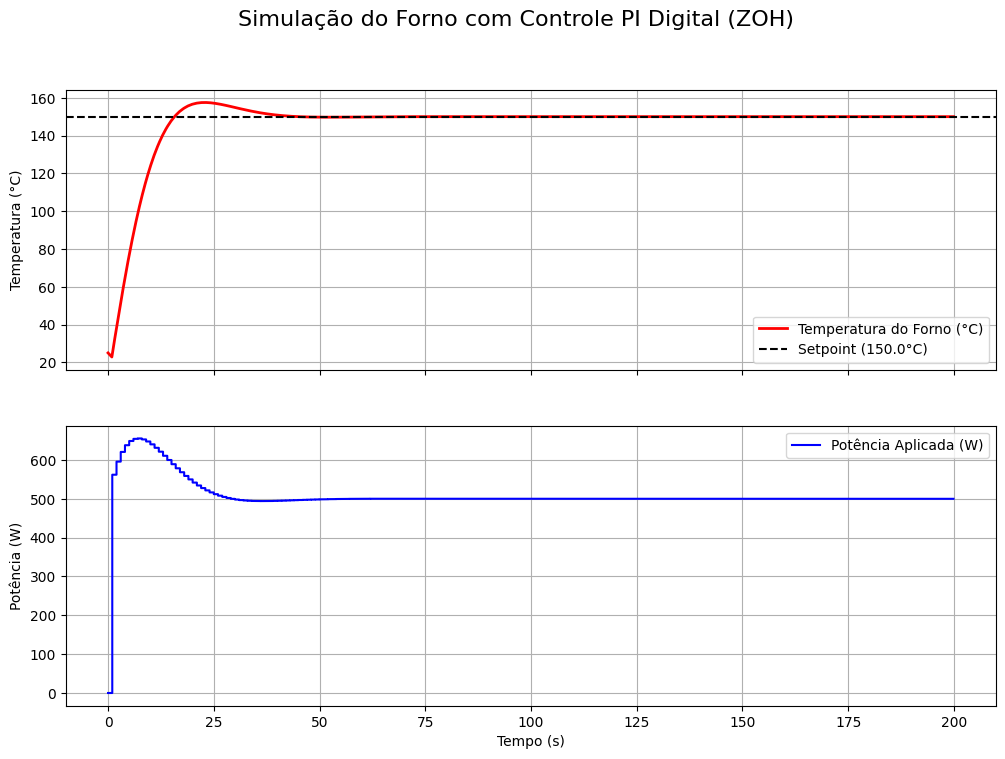

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def simula_sistema_pi_zoh(K, tau, Kp, Ki, setpoint, t_final, potencia_max=1000):
    """
    Simula um sistema de 1ª ordem controlado por um PI digital com Segurador de Ordem Zero (ZOH).

    A função simula o comportamento de uma planta contínua (como um forno) cujo
    controle é atualizado em intervalos discretos de tempo (Ts), com o sinal de
    controle sendo mantido constante entre as atualizações (ZOH).

    Parâmetros:
    -----------
    K : float
        Ganho estático da planta (°C/W).
    tau : float
        Constante de tempo da planta (τ_min em segundos).
    Kp : float
        Ganho proporcional do controlador PI.
    Ki : float
        Ganho integral do controlador PI.
    setpoint : float
        Valor de referência desejado para a saída (ex: 100 °C).
    t_final : float
        Tempo total de simulação (em segundos).
    potencia_max : float, opcional
        Potência máxima do atuador (ex: 1000 W). Usado para saturação e anti-windup.

    Retorna:
    --------
    t : np.ndarray
        Vetor de tempo da simulação.
    y : np.ndarray
        Vetor da saída do sistema (temperatura).
    u : np.ndarray
        Vetor do sinal de controle (potência).
    e : np.ndarray
        Vetor do erro (setpoint - y).
    """
    # 1. Definição dos Parâmetros de Simulação conforme o enunciado
    h = tau / 100.0  # Passo de integração da planta (simulação contínua)
    Ts = tau / 10.0   # Período de amostragem do controlador (atuação digital)

    # Número de passos da simulação da planta por período de amostragem do controlador
    passos_por_amostra = int(Ts / h)

    # 2. Inicialização dos Vetores e Variáveis
    t = np.arange(0, t_final, h) # Vetor de tempo
    n_pontos = len(t)

    y = np.zeros(n_pontos) # Saída (temperatura)
    u = np.zeros(n_pontos) # Sinal de controle (potência)
    e = np.zeros(n_pontos) # Erro

    # Condições iniciais
    integral_sum = 0.0     # Acumulador para o termo integral do PI
    u_held = 0.0           # Valor do controle mantido pelo ZOH

    # Assumindo que o forno começa na temperatura ambiente (ex: 25 °C)
    y[0] = 25.0

    # 3. Loop Principal da Simulação (iterando a cada passo 'h')
    for k in range(1, n_pontos):

        # --- Lógica do Controlador Digital (executa a cada 'Ts' segundos) ---
        # Verificamos se estamos em um instante de amostragem
        if k % passos_por_amostra == 0:
            # 3.1. Medir o erro
            # O erro é calculado com base na medição mais recente y[k-1]
            erro_atual = setpoint - y[k-1]

            # 3.2. Calcular o termo integral com anti-windup
            # O anti-windup evita que o termo integral cresça indefinidamente se o atuador saturar
            integral_sum += Ki * Ts * erro_atual
            if integral_sum > potencia_max:
                integral_sum = potencia_max
            elif integral_sum < 0:
                integral_sum = 0

            # 3.3. Calcular o sinal de controle
            u_calculado = Kp * erro_atual + integral_sum

            # 3.4. Saturação do Atuador
            # A potência não pode ser negativa nem maior que a máxima
            if u_calculado > potencia_max:
                u_held = potencia_max
            elif u_calculado < 0:
                u_held = 0
            else:
                u_held = u_calculado

        # O sinal de controle `u[k]` é sempre o valor mantido pelo ZOH
        u[k] = u_held

        # --- Lógica da Planta Contínua (executa a cada 'h' segundos) ---
        # 4. Simulação da planta usando o método de Euler para a EDO:
        # τ * dy/dt + y = K * u  =>  dy/dt = (K*u - y) / τ
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + h * dy_dt

        # O erro é atualizado a cada passo para fins de plotagem
        e[k] = setpoint - y[k]

    return t, y, u, e

# --- Exemplo de Uso (para teste e para o seu relatório) ---
if __name__ == '__main__':
    # Parâmetros da Planta (Forno Elétrico)
    K_planta = 0.3   # °C/W
    TAU_planta = 10.0  # s

    # Parâmetros do Controlador PI (calculados previamente)
    Kp_controlador = 3.67
    Ki_controlador = 0.75

    # Parâmetros da Simulação
    SETPOINT = 150.0 # °C
    T_FINAL = 200    # s
    POT_MAX = 1000   # W

    # Executar a simulação
    t, y, u, e = simula_sistema_pi_zoh(
        K=K_planta,
        tau=TAU_planta,
        Kp=Kp_controlador,
        Ki=Ki_controlador,
        setpoint=SETPOINT,
        t_final=T_FINAL,
        potencia_max=POT_MAX
    )

    # --- Plotar os Resultados ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('Simulação do Forno com Controle PI Digital (ZOH)', fontsize=16)

    # Gráfico da Temperatura
    ax1.plot(t, y, label='Temperatura do Forno (°C)', color='red', lw=2)
    ax1.axhline(y=SETPOINT, color='k', linestyle='--', label=f'Setpoint ({SETPOINT}°C)')
    ax1.set_ylabel('Temperatura (°C)')
    ax1.grid(True)
    ax1.legend()

    # Gráfico do Sinal de Controle (Potência)
    ax2.plot(t, u, label='Potência Aplicada (W)', color='blue', drawstyle='steps-post')
    ax2.set_xlabel('Tempo (s)')
    ax2.set_ylabel('Potência (W)')
    ax2.grid(True)
    ax2.legend()

    # Exibe o gráfico
    plt.show()



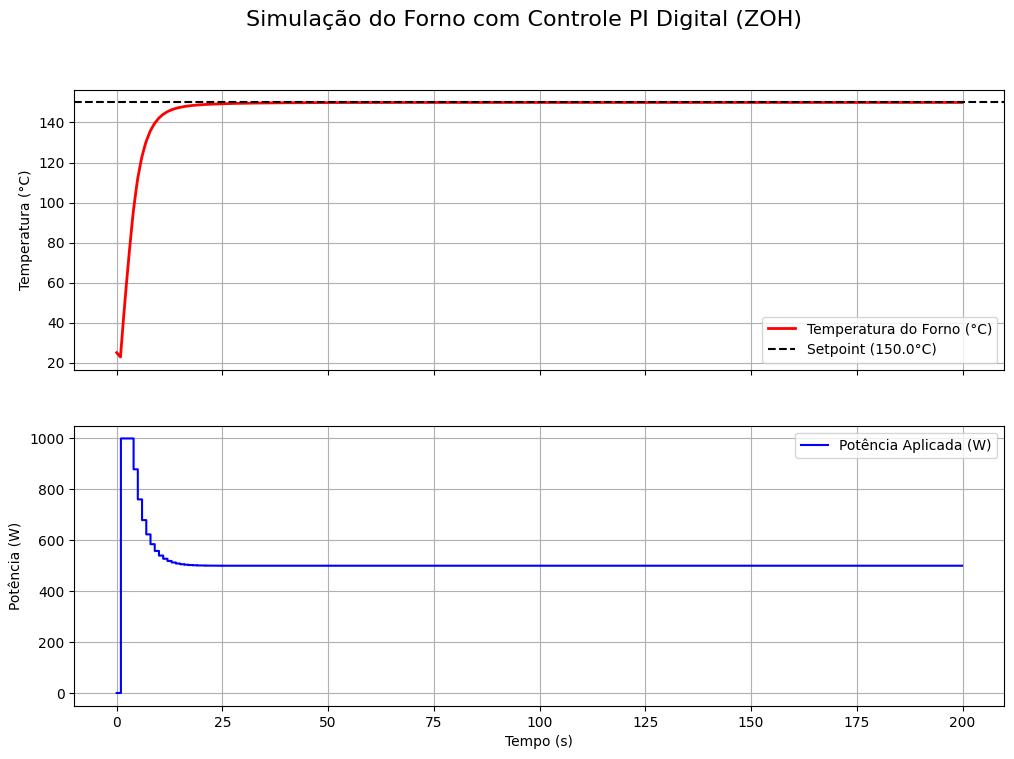

In [ ]:

import numpy as np
import matplotlib.pyplot as plt

def simula_sistema_pi_zoh(K, tau, Kp, Ki, setpoint, t_final, potencia_max=1000):
    """
    Simula um sistema de 1ª ordem controlado por um PI digital com Segurador de Ordem Zero (ZOH).

    A função simula o comportamento de uma planta contínua (como um forno) cujo
    controle é atualizado em intervalos discretos de tempo (Ts), com o sinal de
    controle sendo mantido constante entre as atualizações (ZOH).

    Parâmetros:
    -----------
    K : float
        Ganho estático da planta (°C/W).
    tau : float
        Constante de tempo da planta (τ_min em segundos).
    Kp : float
        Ganho proporcional do controlador PI.
    Ki : float
        Ganho integral do controlador PI.
    setpoint : float
        Valor de referência desejado para a saída (ex: 100 °C).
    t_final : float
        Tempo total de simulação (em segundos).
    potencia_max : float, opcional
        Potência máxima do atuador (ex: 1000 W). Usado para saturação e anti-windup.

    Retorna:
    --------
    t : np.ndarray
        Vetor de tempo da simulação.
    y : np.ndarray
        Vetor da saída do sistema (temperatura).
    u : np.ndarray
        Vetor do sinal de controle (potência).
    e : np.ndarray
        Vetor do erro (setpoint - y).
    """
    # 1. Definição dos Parâmetros de Simulação conforme o enunciado
    h = tau / 100.0  # Passo de integração da planta (simulação contínua)
    Ts = tau / 10.0   # Período de amostragem do controlador (atuação digital)

    # Número de passos da simulação da planta por período de amostragem do controlador
    passos_por_amostra = int(Ts / h)

    # 2. Inicialização dos Vetores e Variáveis
    t = np.arange(0, t_final, h) # Vetor de tempo
    n_pontos = len(t)

    y = np.zeros(n_pontos) # Saída (temperatura)
    u = np.zeros(n_pontos) # Sinal de controle (potência)
    e = np.zeros(n_pontos) # Erro

    # Condições iniciais
    integral_sum = 0.0     # Acumulador para o termo integral do PI
    u_held = 0.0           # Valor do controle mantido pelo ZOH

    # Assumindo que o forno começa na temperatura ambiente (ex: 25 °C)
    y[0] = 25.0

    # 3. Loop Principal da Simulação (iterando a cada passo 'h')
    for k in range(1, n_pontos):

        # --- Lógica do Controlador Digital (executa a cada 'Ts' segundos) ---
        # Verificamos se estamos em um instante de amostragem
        if k % passos_por_amostra == 0:
            # 3.1. Medir o erro
            # O erro é calculado com base na medição mais recente y[k-1]
            erro_atual = setpoint - y[k-1]

            # 3.2. Calcular o termo integral com anti-windup
            # O anti-windup evita que o termo integral cresça indefinidamente se o atuador saturar
            integral_sum += Ki * Ts * erro_atual
            if integral_sum > potencia_max:
                integral_sum = potencia_max
            elif integral_sum < 0:
                integral_sum = 0

            # 3.3. Calcular o sinal de controle
            u_calculado = Kp * erro_atual + integral_sum

            # 3.4. Saturação do Atuador
            # A potência não pode ser negativa nem maior que a máxima
            if u_calculado > potencia_max:
                u_held = potencia_max
            elif u_calculado < 0:
                u_held = 0
            else:
                u_held = u_calculado

        # O sinal de controle `u[k]` é sempre o valor mantido pelo ZOH
        u[k] = u_held

        # --- Lógica da Planta Contínua (executa a cada 'h' segundos) ---
        # 4. Simulação da planta usando o método de Euler para a EDO:
        # τ * dy/dt + y = K * u  =>  dy/dt = (K*u - y) / τ
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + h * dy_dt

        # O erro é atualizado a cada passo para fins de plotagem
        e[k] = setpoint - y[k]

    return t, y, u, e

# --- Exemplo de Uso (para teste e para o seu relatório) ---
if __name__ == '__main__':
    # Parâmetros da Planta (Forno Elétrico)
    K_planta = 0.3   # °C/W
    TAU_planta = 10.0  # s

    # Parâmetros do Controlador PI (calculados previamente)
    Kp_controlador = 3.67
    Ki_controlador = 0.75

    Kp_controlador = 9.6603
    Ki_controlador = 0.9660

    # Parâmetros da Simulação
    SETPOINT = 150.0 # °C
    T_FINAL = 200    # s
    POT_MAX = 1000   # W

    # Executar a simulação
    t, y, u, e = simula_sistema_pi_zoh(
        K=K_planta,
        tau=TAU_planta,
        Kp=Kp_controlador,
        Ki=Ki_controlador,
        setpoint=SETPOINT,
        t_final=T_FINAL,
        potencia_max=POT_MAX
    )

    # --- Plotar os Resultados ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
    fig.suptitle('Simulação do Forno com Controle PI Digital (ZOH)', fontsize=16)

    # Gráfico da Temperatura
    ax1.plot(t, y, label='Temperatura do Forno (°C)', color='red', lw=2)
    ax1.axhline(y=SETPOINT, color='k', linestyle='--', label=f'Setpoint ({SETPOINT}°C)')
    ax1.set_ylabel('Temperatura (°C)')
    ax1.grid(True)
    ax1.legend()

    # Gráfico do Sinal de Controle (Potência)
    ax2.plot(t, u, label='Potência Aplicada (W)', color='blue', drawstyle='steps-post')
    ax2.set_xlabel('Tempo (s)')
    ax2.set_ylabel('Potência (W)')
    ax2.grid(True)
    ax2.legend()

    # Exibe o gráfico
    plt.show()



--- Controlador PI Projetado ---
Kp = 9.6603
Ki = 0.9660

Executando simulações...
Simulações concluídas.

--- Análise das Métricas de Desempenho ---

Malha Aberta:
Valor de regime permanente: 0.00 °C
Tempo de Acomodação (ts2): 37.12 s

Malha Fechada Sem Controlador:
Sobressinal (PO): 0.00 %
Tempo de Acomodação (ts2): 200.00 s

Malha Fechada com PI Contínuo:
Sobressinal (PO): 0.00 %
Tempo de Acomodação (ts2): 16.51 s

Malha Fechada com PI Digital (ZOH):
Sobressinal (PO): 0.00 %
Tempo de Acomodação (ts2): 13.80 s


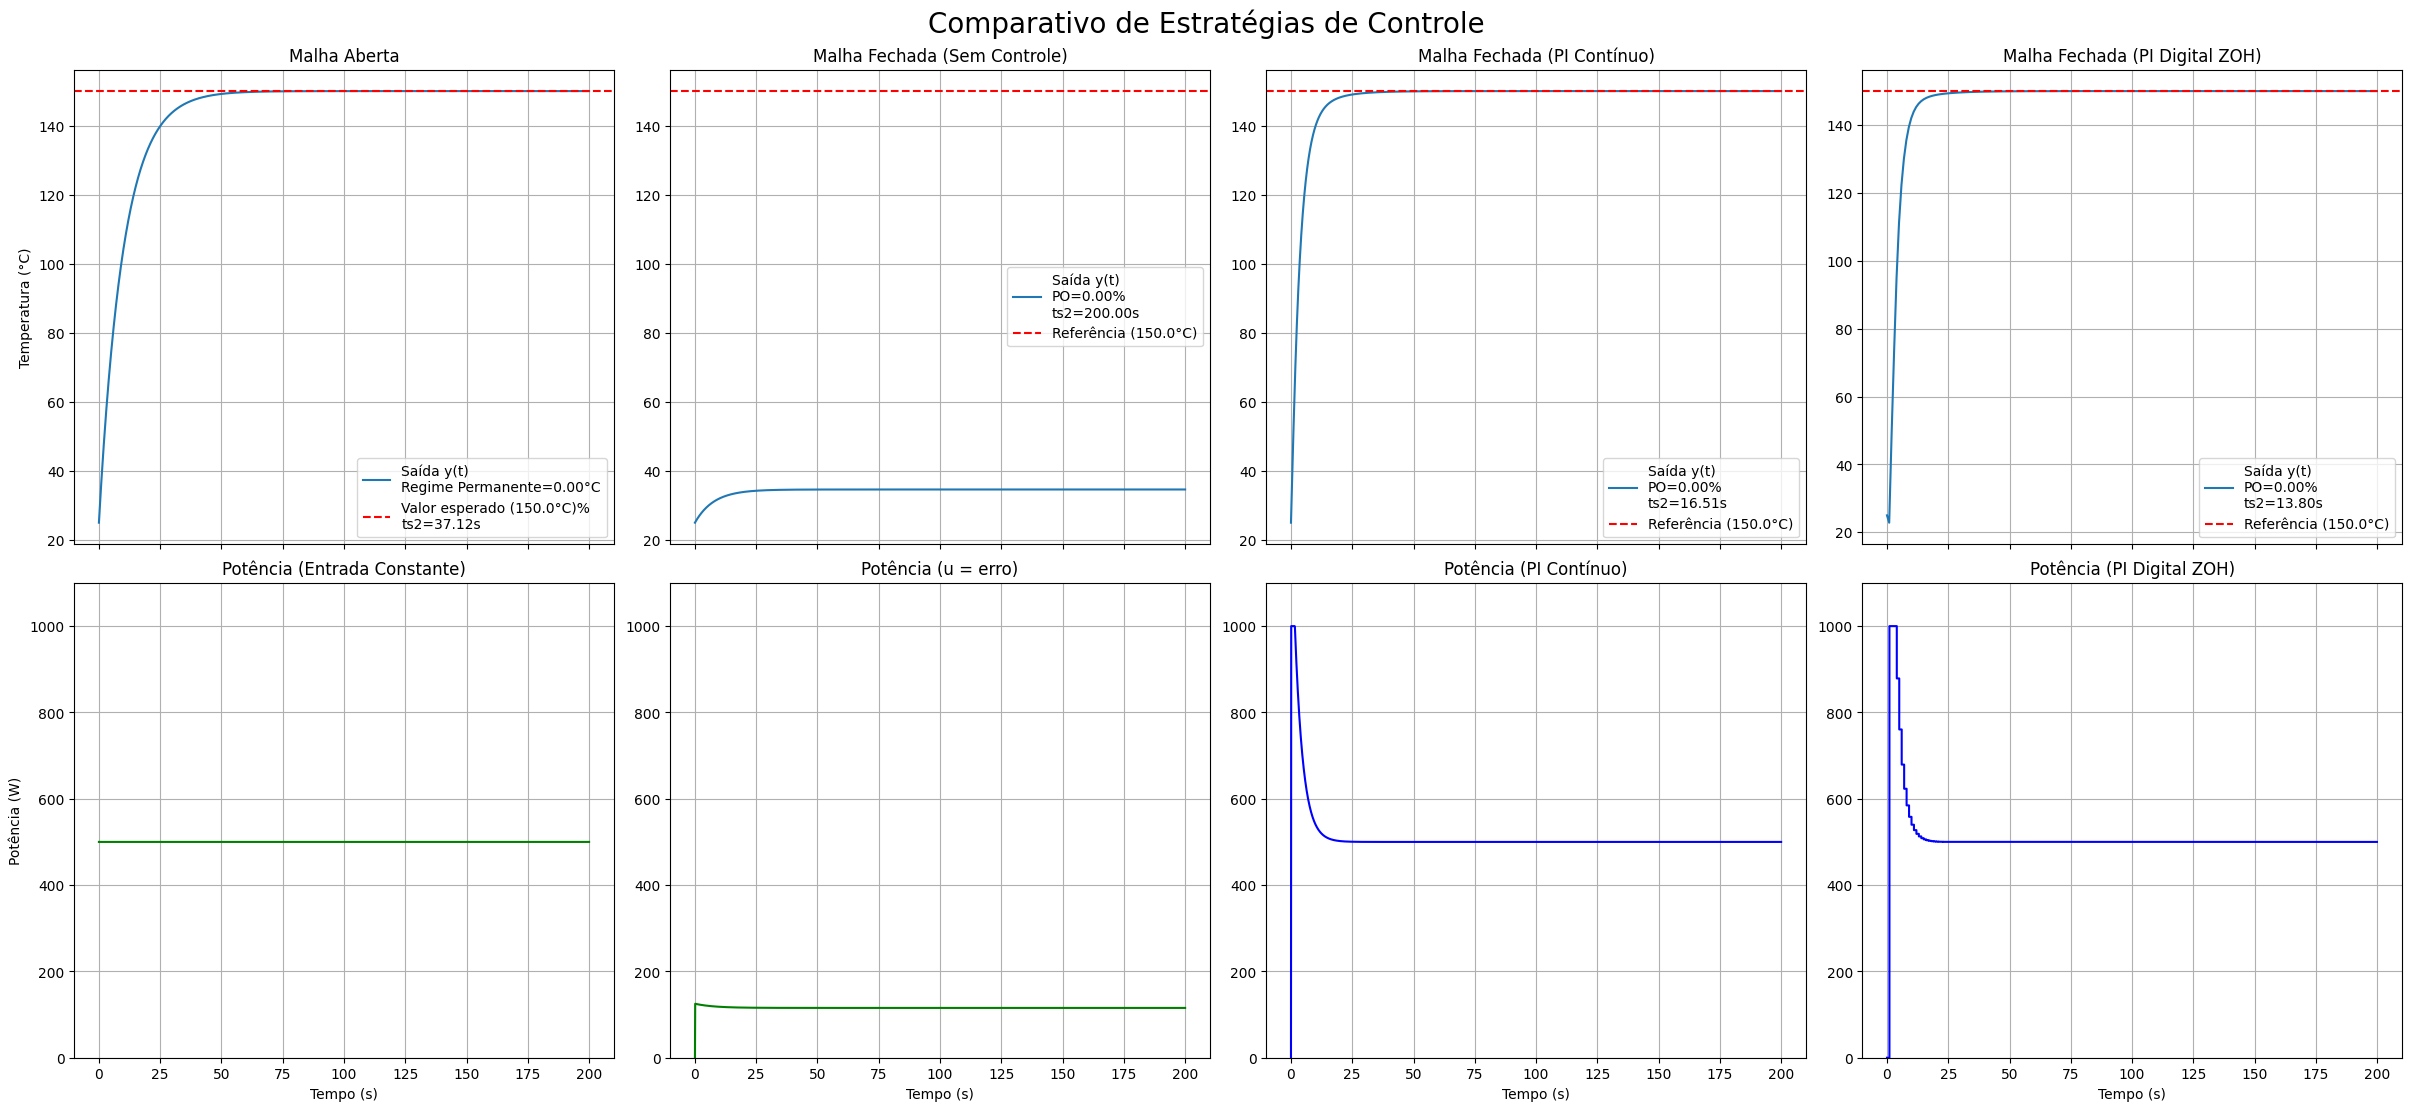

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import math

# =============================================================================
# FUNÇÕES AUXILIARES E DE SIMULAÇÃO (COM CORREÇÕES)
# =============================================================================

def projetar_controlador_raizes(num, den, PO, t2p):
    """
    Projeta um controlador PI por lugar das raízes para planta de 1ª ordem.
    Retorna os ganhos Kp e Ki.
    """
    # 1. Parâmetros de desempenho
    zeta = -np.log(PO / 100) / np.sqrt(np.pi**2 + (np.log(PO / 100))**2)
    wn = 4 / (zeta * t2p)
    wd = wn * np.sqrt(1 - zeta**2)

    # 2. Extrai parâmetros da planta G(s) = K_planta / (tau*s + 1)
    K_planta = num[0] / den[1]
    tau = den[0] / den[1]

    # 3. Define o zero do controlador PI para cancelar o polo da planta
    z = 1 / tau

    # 4. Polos dominantes desejados em malha fechada
    sd = -zeta * wn + 1j * wd

    # 5. Condição de magnitude para encontrar Kp
    # Com o cancelamento, L(s) = Kp * K_planta / (tau * s)
    Kp = abs(tau * sd) / K_planta
    Ki = Kp * z

    return Kp, Ki

def malha_aberta(y0, potencia_constante, T_int, n_int, K, tau):
    """Simula a resposta em malha aberta. RETORNA y E u."""
    y = np.zeros(n_int)
    u = np.full(n_int, potencia_constante)
    y[0] = y0

    for k in range(1, n_int):
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return y, u  # <-- CORREÇÃO APLICADA

def malha_fechada_sem_controlador(y0, r, T_int, n_int, K, tau):
    """Simula a malha fechada sem controlador. RETORNA y E u."""
    y = np.zeros(n_int)
    u = np.zeros(n_int)
    y[0] = y0

    for k in range(1, n_int):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return y, u  # <-- CORREÇÃO APLICADA

def malha_fechada_com_controlador_pi(y0, r, T_int, n_int, K, tau, Kp, Ki, potencia_max=1000):
    """Simula a malha fechada com PI contínuo. RETORNA y E u."""
    y = np.zeros(n_int)
    u = np.zeros(n_int)
    y[0] = y0
    integral_erro = 0.0

    for k in range(1, n_int):
        erro = r - y[k-1]
        integral_erro += erro * T_int
        u_calculado = Kp * erro + Ki * integral_erro

        if u_calculado > potencia_max: u_calculado = potencia_max
        if u_calculado < 0: u_calculado = 0
        u[k] = u_calculado

        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return y, u  # <-- CORREÇÃO APLICADA

def simula_sistema_pi_zoh(K, tau, Kp, Ki, setpoint, t_final, y0=25.0, potencia_max=1000):
    """Simula o sistema com PI digital e ZOH. Esta função já estava correta."""
    h = tau / 100.0
    Ts = tau / 10.0
    passos_por_amostra = int(Ts / h)
    t = np.arange(0, t_final, h)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    e = np.zeros(n_pontos)
    y[0] = y0
    integral_sum = 0.0
    u_held = 0.0

    for k in range(1, n_pontos):
        if k > 0 and k % passos_por_amostra == 0:
            erro_atual = setpoint - y[k-1]
            integral_sum += Ki * Ts * erro_atual
            if integral_sum > potencia_max: integral_sum = potencia_max
            elif integral_sum < 0: integral_sum = 0
            u_calculado = Kp * erro_atual + integral_sum
            if u_calculado > potencia_max: u_held = potencia_max
            elif u_calculado < 0: u_held = 0
            else: u_held = u_calculado
        u[k] = u_held
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + h * dy_dt
        e[k] = setpoint - y[k]
    return t, y, u, e

def medir_metricas(t, y, r):
    """
    Calcula o sobressinal percentual (PO) e o tempo de acomodação de 2% (ts2).

    Args:
        t (array): Vetor de tempo.
        y (array): Vetor da resposta do sistema.
        r (float): Valor da referência (regime permanente esperado).

    Returns:
        tuple: (PO, ts2)
    """
    # Cálculo do Sobressinal (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100) # Garante que não seja negativo se não houver sobressinal

    # Cálculo do Tempo de Acomodação (ts2)
    ts2 = None
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Encontra o último momento em que a resposta esteve fora da faixa de 2%
    for i in range(len(y) - 1, -1, -1):
        if y[i] > limite_superior or y[i] < limite_inferior:
            ts2 = t[i]
            break

    return po, ts2

# =============================================================================
# BLOCO PRINCIPAL DE EXECUÇÃO (SEU CÓDIGO, AGORA FUNCIONAL)
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta ---
    K_planta = .3
    tau = 10.0
    num_planta = [K_planta]
    den_planta = [tau, 1]

    # --- 2. Definição das Especificações de Desempenho ---
    PO_desejado = 5.0
    t2p_desejado = 20.0

    # --- 3. Projeto do Controlador PI ---
    Kp, Ki = projetar_controlador_raizes(num_planta, den_planta, PO_desejado, t2p_desejado)
    print("--- Controlador PI Projetado ---")
    print(f"Kp = {Kp:.4f}")
    print(f"Ki = {Ki:.4f}")

    # --- 4. Configuração da Simulação ---
    T_sim = 200 # Tempo maior para ver a estabilização completa
    T_int = tau / 100.0
    n_int = int(T_sim / T_int)
    t_continuo = np.linspace(0, T_sim, n_int)
    y0 = 25.0
    r = 150.0  # Referência de temperatura
    potencia_max = 1000.0

    # Potência constante para a simulação de malha aberta
    potencia_ma = r / K_planta

    # --- 5. Simulações principais ---
    print("\nExecutando simulações...")
    y_ma, u_ma = malha_aberta(y0, potencia_ma, T_int, n_int, K_planta, tau)
    y_mf_sc, u_mf_sc = malha_fechada_sem_controlador(y0, r, T_int, n_int, K_planta, tau)
    y_mf_cc, u_mf_cc = malha_fechada_com_controlador_pi(y0, r, T_int, n_int, K_planta, tau, Kp, Ki, potencia_max)
    t_zoh, y_zoh, u_zoh, e_zoh = simula_sistema_pi_zoh(K_planta, tau, Kp, Ki, r, T_sim, y0, potencia_max)
    print("Simulações concluídas.")
    # Calculate and display metrics for each simulation
    print("\n--- Análise das Métricas de Desempenho ---")

    # Malha Aberta
    # Para malha aberta, não há sobressinal nem tempo de acomodação no sentido tradicional de controle de malha fechada.
    # O valor de regime permanente é K*potencia_ma.
    y_ma_final, ts2_ma = medir_metricas(t_continuo, y_ma, r)
    print("\nMalha Aberta:")
    print(f"Valor de regime permanente: {y_ma_final:.2f} °C")
    print(f"Tempo de Acomodação (ts2): {ts2_ma:.2f} s")


    # Malha Fechada Sem Controlador
    po_mf_sc, ts2_mf_sc = medir_metricas(t_continuo, y_mf_sc, r)
    print("\nMalha Fechada Sem Controlador:")
    print(f"Sobressinal (PO): {po_mf_sc:.2f} %")
    print(f"Tempo de Acomodação (ts2): {ts2_mf_sc:.2f} s")


    # Malha Fechada com PI Contínuo
    po_mf_cc, ts2_mf_cc = medir_metricas(t_continuo, y_mf_cc, r)
    print("\nMalha Fechada com PI Contínuo:")
    print(f"Sobressinal (PO): {po_mf_cc:.2f} %")
    print(f"Tempo de Acomodação (ts2): {ts2_mf_cc:.2f} s")

    # Malha Fechada com PI Digital (ZOH)
    # Usar o vetor de tempo e resposta da simulação ZOH
    po_zoh, ts2_zoh = medir_metricas(t_zoh, y_zoh, r)
    print("\nMalha Fechada com PI Digital (ZOH):")
    print(f"Sobressinal (PO): {po_zoh:.2f} %")
    print(f"Tempo de Acomodação (ts2): {ts2_zoh:.2f} s")
    # --- 6. Plotagem no Grid 2x4 ---
    fig, axs = plt.subplots(2, 4, figsize=(24, 11), sharex=True, constrained_layout=True)
    fig.suptitle('Comparativo de Estratégias de Controle', fontsize=20)

    # --- Coluna 1: Malha Aberta ---
    axs[0, 0].plot(t_continuo, y_ma, label=f'Saída y(t)\nRegime Permanente={y_ma_final:.2f}°C')
    axs[0, 0].axhline(y=potencia_ma * K_planta, color='r', linestyle='--', label=f'Valor esperado ({potencia_ma*K_planta:.1f}°C)%\nts2={ts2_ma:.2f}s')
    axs[0, 0].set_title('Malha Aberta')
    axs[0, 0].set_ylabel('Temperatura (°C)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    axs[1, 0].plot(t_continuo, u_ma, color='g')
    axs[1, 0].set_title('Potência (Entrada Constante)')
    axs[1, 0].set_ylabel('Potência (W)')
    axs[1, 0].set_xlabel('Tempo (s)')
    axs[1, 0].grid(True)
    axs[1, 0].set_ylim(0, potencia_max * 1.1)

    # --- Coluna 2: Malha Fechada Sem Controlador ---
    axs[0, 1].plot(t_continuo, y_mf_sc, label=f'Saída y(t)\nPO={po_mf_sc:.2f}%\nts2={ts2_mf_sc:.2f}s')
    axs[0, 1].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r}°C)')
    axs[0, 1].set_title('Malha Fechada (Sem Controle)')
    axs[0, 1].grid(True)
    axs[0, 1].legend()
    axs[1, 1].plot(t_continuo, u_mf_sc, color='g')
    axs[1, 1].set_title('Potência (u = erro)')
    axs[1, 1].set_xlabel('Tempo (s)')
    axs[1, 1].grid(True)
    axs[1, 1].set_ylim(0, potencia_max * 1.1)

    # --- Coluna 3: Malha Fechada com PI Contínuo ---
    axs[0, 2].plot(t_continuo, y_mf_cc, label=f'Saída y(t)\nPO={po_mf_cc:.2f}%\nts2={ts2_mf_cc:.2f}s')
    axs[0, 2].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r}°C)')
    axs[0, 2].set_title('Malha Fechada (PI Contínuo)')
    axs[0, 2].grid(True)
    axs[0, 2].legend()
    axs[1, 2].plot(t_continuo, u_mf_cc, color='b')
    axs[1, 2].set_title('Potência (PI Contínuo)')
    axs[1, 2].set_xlabel('Tempo (s)')
    axs[1, 2].grid(True)
    axs[1, 2].set_ylim(0, potencia_max * 1.1)

    # --- Coluna 4: Malha Fechada com PI Digital (ZOH) ---
    axs[0, 3].plot(t_zoh, y_zoh, label=f'Saída y(t)\nPO={po_zoh:.2f}%\nts2={ts2_zoh:.2f}s')
    axs[0, 3].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r}°C)')
    axs[0, 3].set_title('Malha Fechada (PI Digital ZOH)')
    axs[0, 3].grid(True)
    axs[0, 3].legend()
    axs[1, 3].plot(t_zoh, u_zoh, color='b', drawstyle='steps-post')
    axs[1, 3].set_title('Potência (PI Digital ZOH)')
    axs[1, 3].set_xlabel('Tempo (s)')
    axs[1, 3].grid(True)
    axs[1, 3].set_ylim(0, potencia_max * 1.1)

    plt.show()

Professor quer em C também, pode transformar? Se forneça tabelas ao invés de gráficos

--- 1. Descrição da Planta e Especificações ---
Planta: G(s) = 0.3 / (40.0s + 1)
Especificações: PO <= 5.0%, ts_2% <= 30.0 s

--- 2. Projeto do Controlador Original ---
Ganho Proporcional Projetado (Kp) = 32.2222
Ganho Integral Projetado (Ki)     = 4.9772

--- 3. Análise de Sensibilidade da Sintonia ---

Executando simulações...

Resultados para: PI Projetado (Original)
  - Kp = 32.22, Ki = 4.98
  - Sobressinal (PO): 8.84%
  - Tempo de Acomodação (ts_2%): 68.40 s
  - Erro em Regime Permanente: -0.04 °C

Resultados para: Kp Aumentado (2x)
  - Kp = 64.44, Ki = 4.98
  - Sobressinal (PO): 13.48%
  - Tempo de Acomodação (ts_2%): 108.00 s
  - Erro em Regime Permanente: 0.80 °C

Resultados para: Kp Diminuído (0.5x)
  - Kp = 16.11, Ki = 4.98
  - Sobressinal (PO): 11.56%
  - Tempo de Acomodação (ts_2%): 57.60 s
  - Erro em Regime Permanente: -0.00 °C

Resultados para: Ki Aumentado (2x)
  - Kp = 32.22, Ki = 9.95
  - Sobressinal (PO): 8.84%
  - Tempo de Acomodação (ts_2%): 68.40 s
  - Erro em Reg

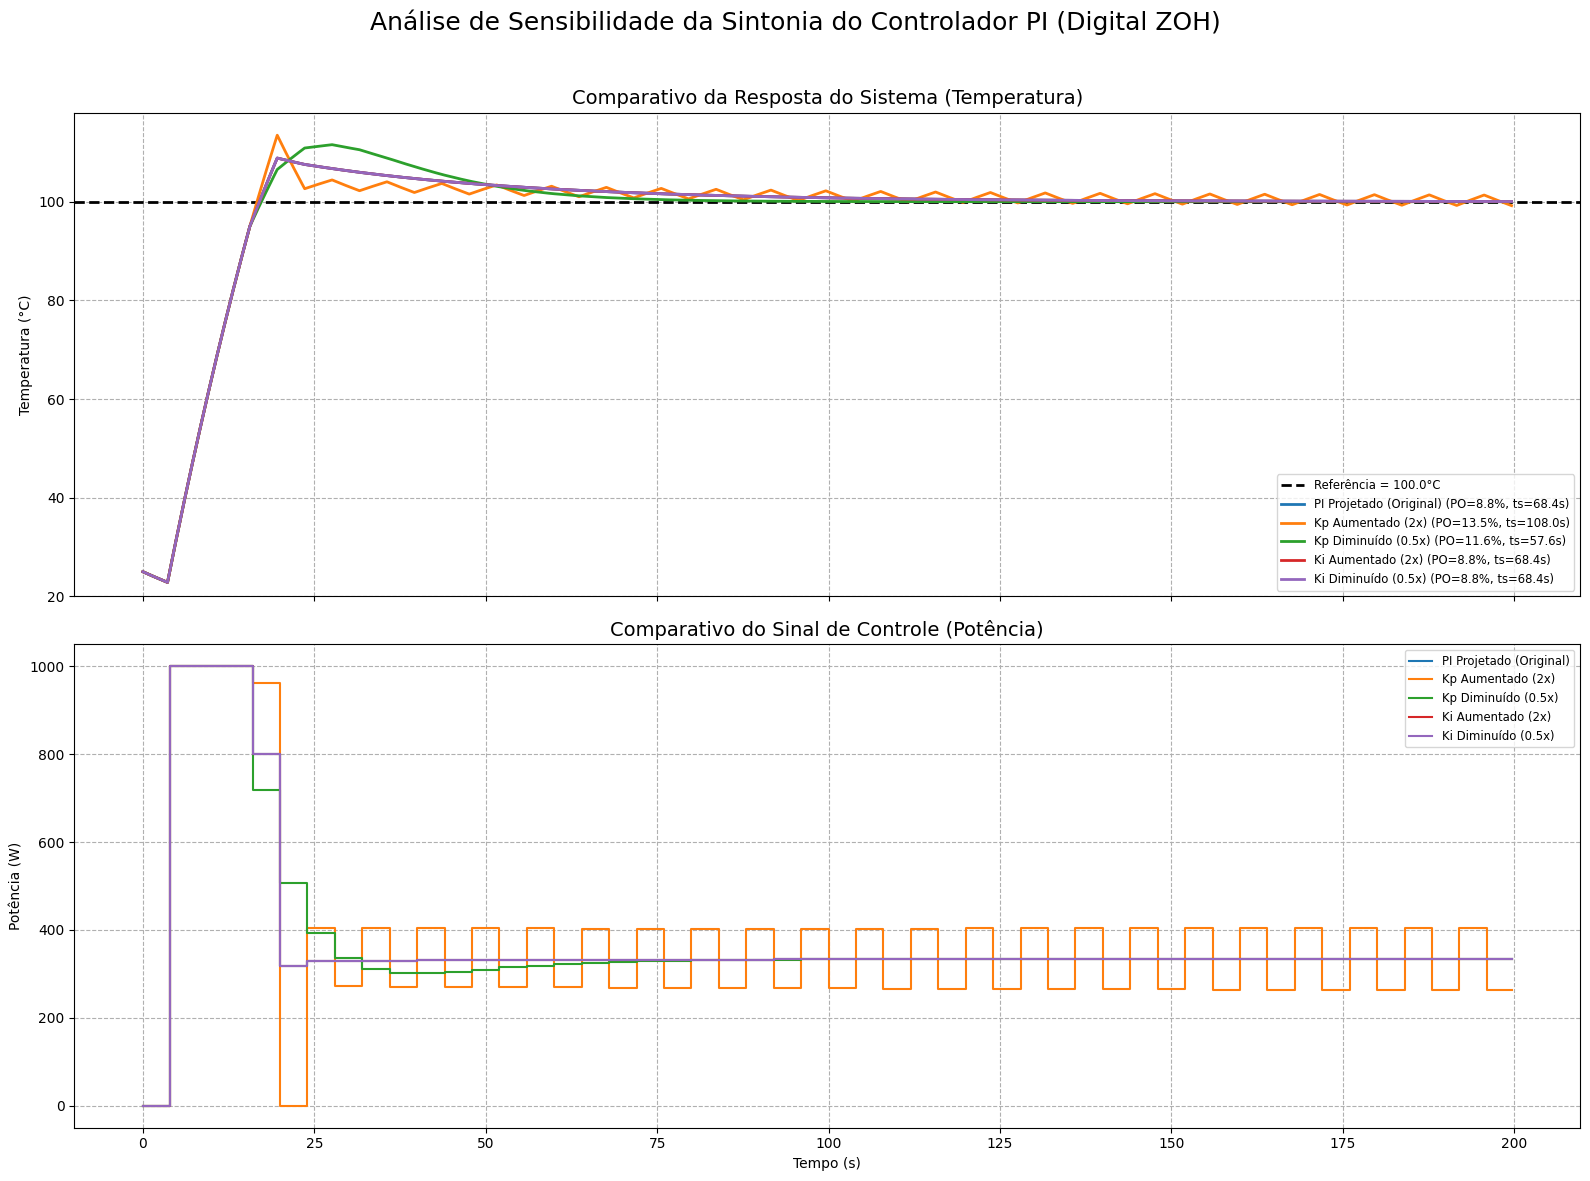

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: DESCRIÇÃO DA PLANTA E ESPECIFICAÇÕES (Inalterado)
# =============================================================================
K_planta = 0.3
tau = 40.0
num_planta = [K_planta]
den_planta = [tau, 1]
PO_desejado = 5.0
t_s_desejado = 30.0

print("--- 1. Descrição da Planta e Especificações ---")
print(f"Planta: G(s) = {K_planta} / ({tau}s + 1)")
print(f"Especificações: PO <= {PO_desejado}%, ts_2% <= {t_s_desejado} s\n")

# =============================================================================
# PARTE 2: PROJETO DO CONTROLADOR (Inalterado)
# =============================================================================
def projetar_controlador_pi_alocacao(K, tau, PO, ts):
    zeta = -np.log(PO / 100) / np.sqrt(np.pi**2 + (np.log(PO / 100))**2)
    wn = 4 / (zeta * ts)
    ki = (wn**2 * tau) / K
    kp = (2 * zeta * wn * tau - 1) / K
    return kp, ki

Kp_proj, Ki_proj = projetar_controlador_pi_alocacao(K_planta, tau, PO_desejado, t_s_desejado)

print("--- 2. Projeto do Controlador Original ---")
print(f"Ganho Proporcional Projetado (Kp) = {Kp_proj:.4f}")
print(f"Ganho Integral Projetado (Ki)     = {Ki_proj:.4f}\n")

# =============================================================================
# PARTE 3: CONFIGURAÇÃO DA SIMULAÇÃO (Inalterado)
# =============================================================================
T_int = tau / 100.0
Ts = tau / 10.0
passos_por_amostra = int(Ts / T_int)
T_sim = 200.0
t_vetor = np.arange(0, T_sim, T_int)
n_pontos = len(t_vetor)
y0 = 25.0
r = 100.0
potencia_max = 1000

# --- Algoritmo de Simulação (Inalterado) ---
def simular_sistema_zoh(K, tau, Kp, Ki):
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    y[0] = y0
    integral_erro = 0.0
    u_held = 0.0
    for k in range(1, n_pontos):
        if k % passos_por_amostra == 0:
            erro = r - y[k-1]
            integral_erro += erro * Ts
            u_calc = Kp * erro + integral_erro
            u_held = np.clip(u_calc, 0, potencia_max) # np.clip simplifica a saturação
        u[k] = u_held
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return y, u

# --- Análise de Desempenho (Inalterado) ---
def analisar_desempenho(t, y, r):
    pico = np.max(y)
    po = ((pico - r) / r) * 100 if pico > r else 0
    limite_sup = r * 1.02
    limite_inf = r * 0.98
    ts = t[-1]
    indices_fora_faixa = np.where((y > limite_sup) | (y < limite_inf))[0]
    if len(indices_fora_faixa) > 0:
        ultimo_fora = indices_fora_faixa[-1]
        if ultimo_fora + 1 < len(t):
            ts = t[ultimo_fora + 1]
    erro_ss = r - y[-1]
    return po, ts, erro_ss

# =============================================================================
# PARTE 4: SIMULAÇÃO COM VARIAÇÕES DE SINTONIA (NOVO)
# =============================================================================
print("--- 3. Análise de Sensibilidade da Sintonia ---")
# Define os 5 casos a serem testados
casos_de_sintonia = {
    "PI Projetado (Original)": (Kp_proj, Ki_proj),
    "Kp Aumentado (2x)":       (Kp_proj * 2.0, Ki_proj),
    "Kp Diminuído (0.5x)":     (Kp_proj * 0.5, Ki_proj),
    "Ki Aumentado (2x)":       (Kp_proj, Ki_proj * 2.0),
    "Ki Diminuído (0.5x)":     (Kp_proj, Ki_proj * 0.5),
}

# Dicionário para armazenar todos os resultados
resultados_simulacao = {}

# Executa a simulação e a análise para cada caso
print("\nExecutando simulações...")
for nome_caso, (kp, ki) in casos_de_sintonia.items():
    y, u = simular_sistema_zoh(K_planta, tau, kp, ki)
    po, ts, err_ss = analisar_desempenho(t_vetor, y, r)

    resultados_simulacao[nome_caso] = {
        'y': y, 'u': u, 'po': po, 'ts': ts, 'err_ss': err_ss
    }

    print(f"\nResultados para: {nome_caso}")
    print(f"  - Kp = {kp:.2f}, Ki = {ki:.2f}")
    print(f"  - Sobressinal (PO): {po:.2f}%")
    print(f"  - Tempo de Acomodação (ts_2%): {ts:.2f} s")
    print(f"  - Erro em Regime Permanente: {err_ss:.2f} °C")

# =============================================================================
# PARTE 5: PLOTAGEM COMPARATIVA (NOVO)
# =============================================================================
print("\nGerando gráficos comparativos...")
fig, axs = plt.subplots(2, 1, figsize=(16, 12), sharex=True)
fig.suptitle("Análise de Sensibilidade da Sintonia do Controlador PI (Digital ZOH)", fontsize=18)

# --- Gráfico 1: Respostas do Sistema (Temperatura) ---
ax1 = axs[0]
ax1.set_title("Comparativo da Resposta do Sistema (Temperatura)", fontsize=14)
ax1.axhline(y=r, color='black', linestyle='--', linewidth=2, label=f'Referência = {r}°C')

for nome_caso, res in resultados_simulacao.items():
    label_text = f"{nome_caso} (PO={res['po']:.1f}%, ts={res['ts']:.1f}s)"
    ax1.plot(t_vetor, res['y'], label=label_text, linewidth=2)

ax1.set_ylabel("Temperatura (°C)")
ax1.legend(loc='best', fontsize='small')
ax1.grid(True, which='both', linestyle='--')
ax1.set_ylim(bottom=y0-5) # Ajusta o limite inferior para melhor visualização

# --- Gráfico 2: Sinais de Controle (Potência) ---
ax2 = axs[1]
ax2.set_title("Comparativo do Sinal de Controle (Potência)", fontsize=14)

for nome_caso, res in resultados_simulacao.items():
    ax2.plot(t_vetor, res['u'], label=nome_caso, drawstyle='steps-post', linewidth=1.5)

ax2.set_ylabel("Potência (W)")
ax2.set_xlabel("Tempo (s)")
ax2.legend(loc='best', fontsize='small')
ax2.grid(True, which='both', linestyle='--')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

--- Controlador PI Projetado ---
Kp = 9.6603
Ki = 0.9660

Executando simulações...
Simulações concluídas.

--- Análise das Métricas de Desempenho ---

Malha Aberta:
Valor de regime permanente: 0.00 °C
Tempo de Acomodação (ts2): 37.12 s

Malha Fechada Sem Controlador:
Sobressinal (PO): 0.00 %
Tempo de Acomodação (ts2): 200.00 s

Malha Fechada com PI Contínuo:
Sobressinal (PO): 0.00 %
Tempo de Acomodação (ts2): 16.51 s

Malha Fechada com PI Digital (ZOH):
Sobressinal (PO): 0.00 %
Tempo de Acomodação (ts2): 13.80 s


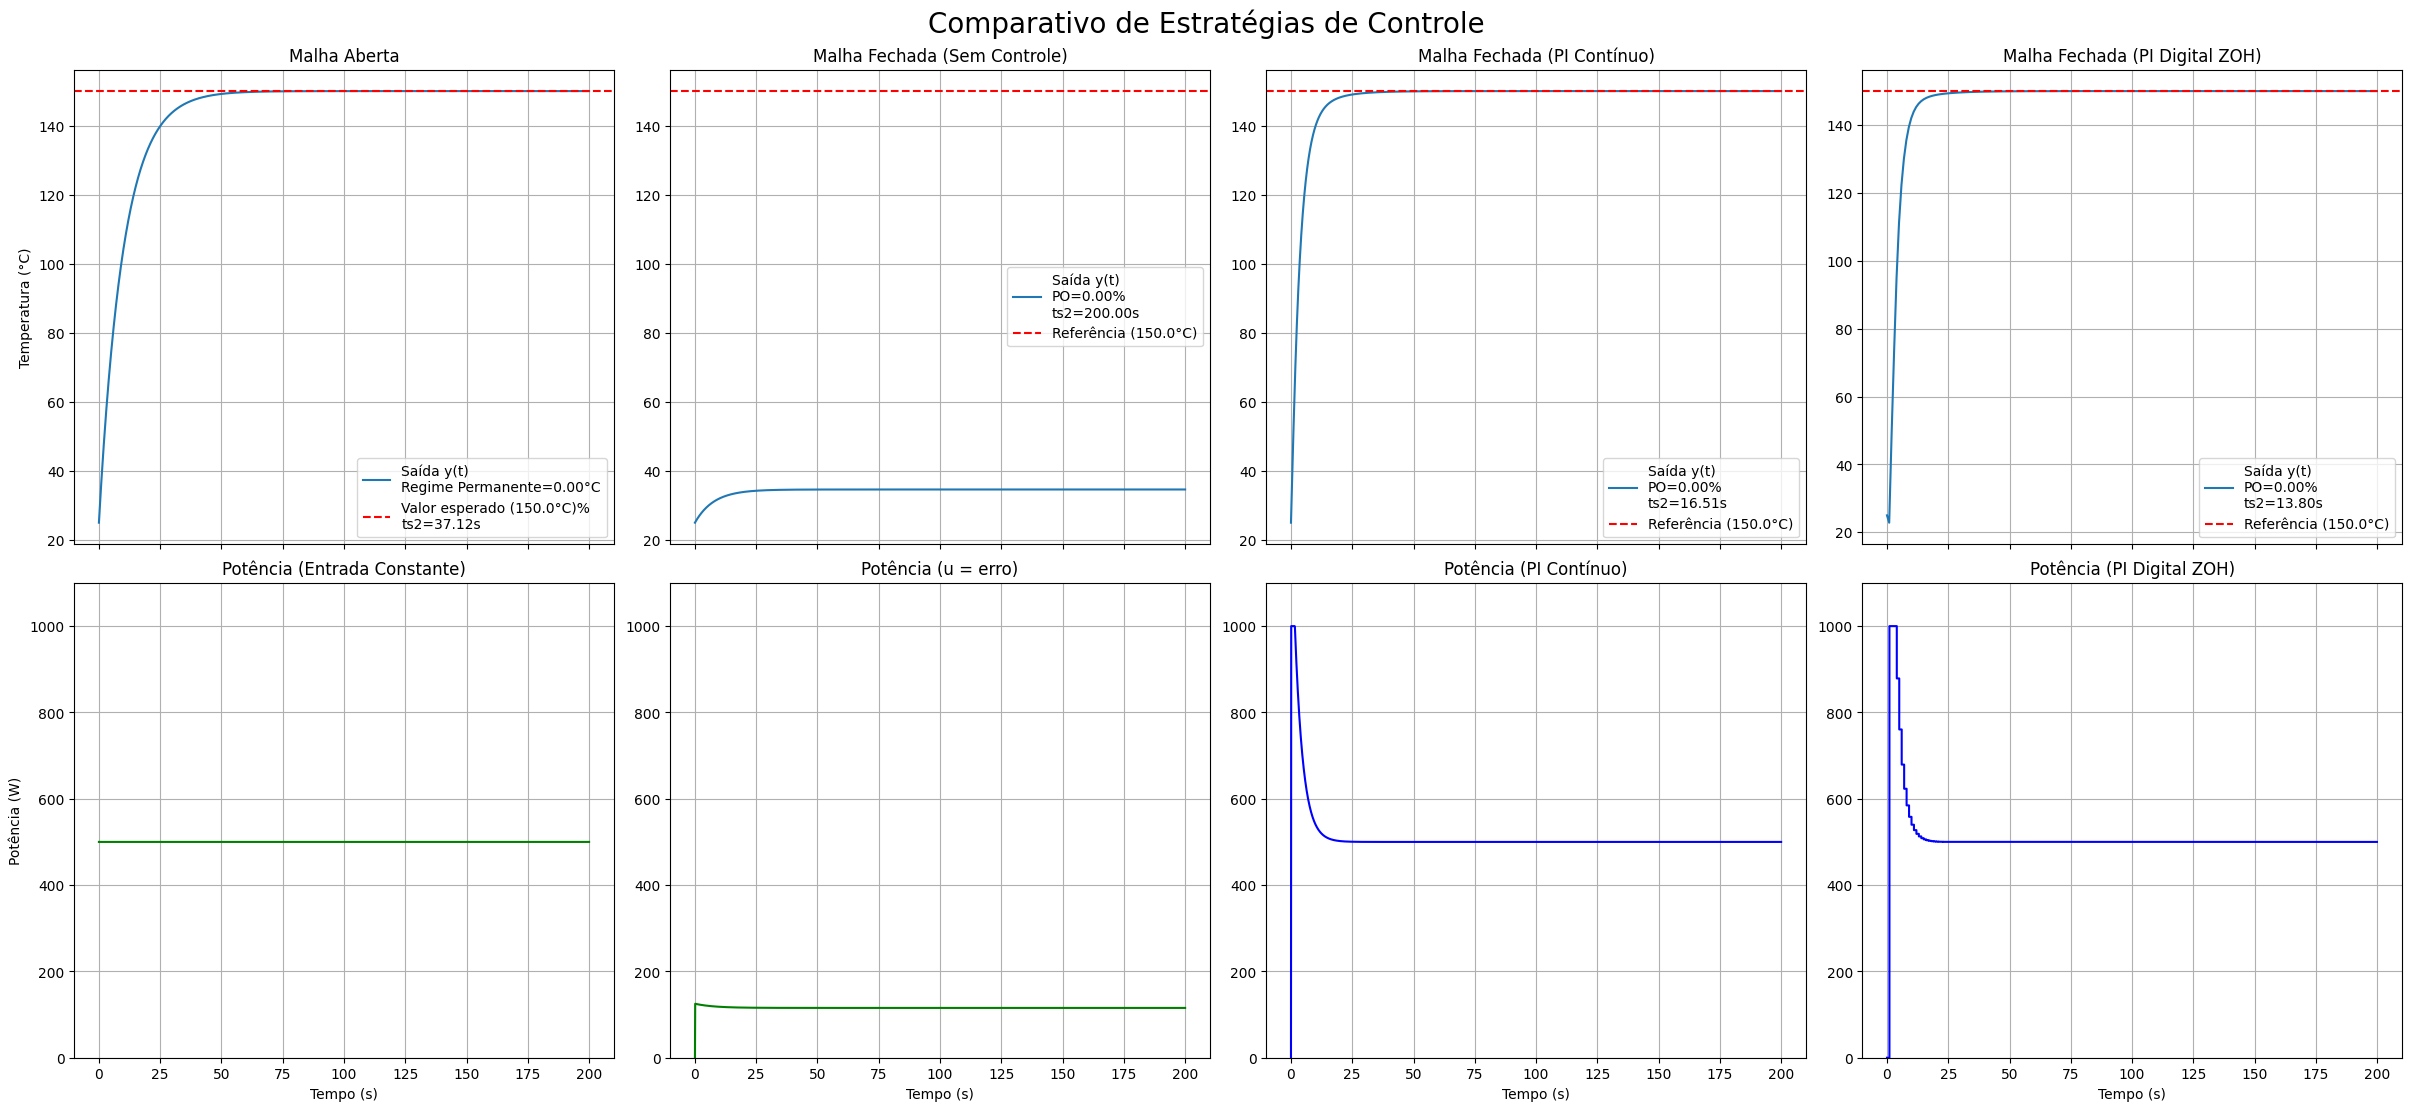


Gerando gráficos em grid separado...


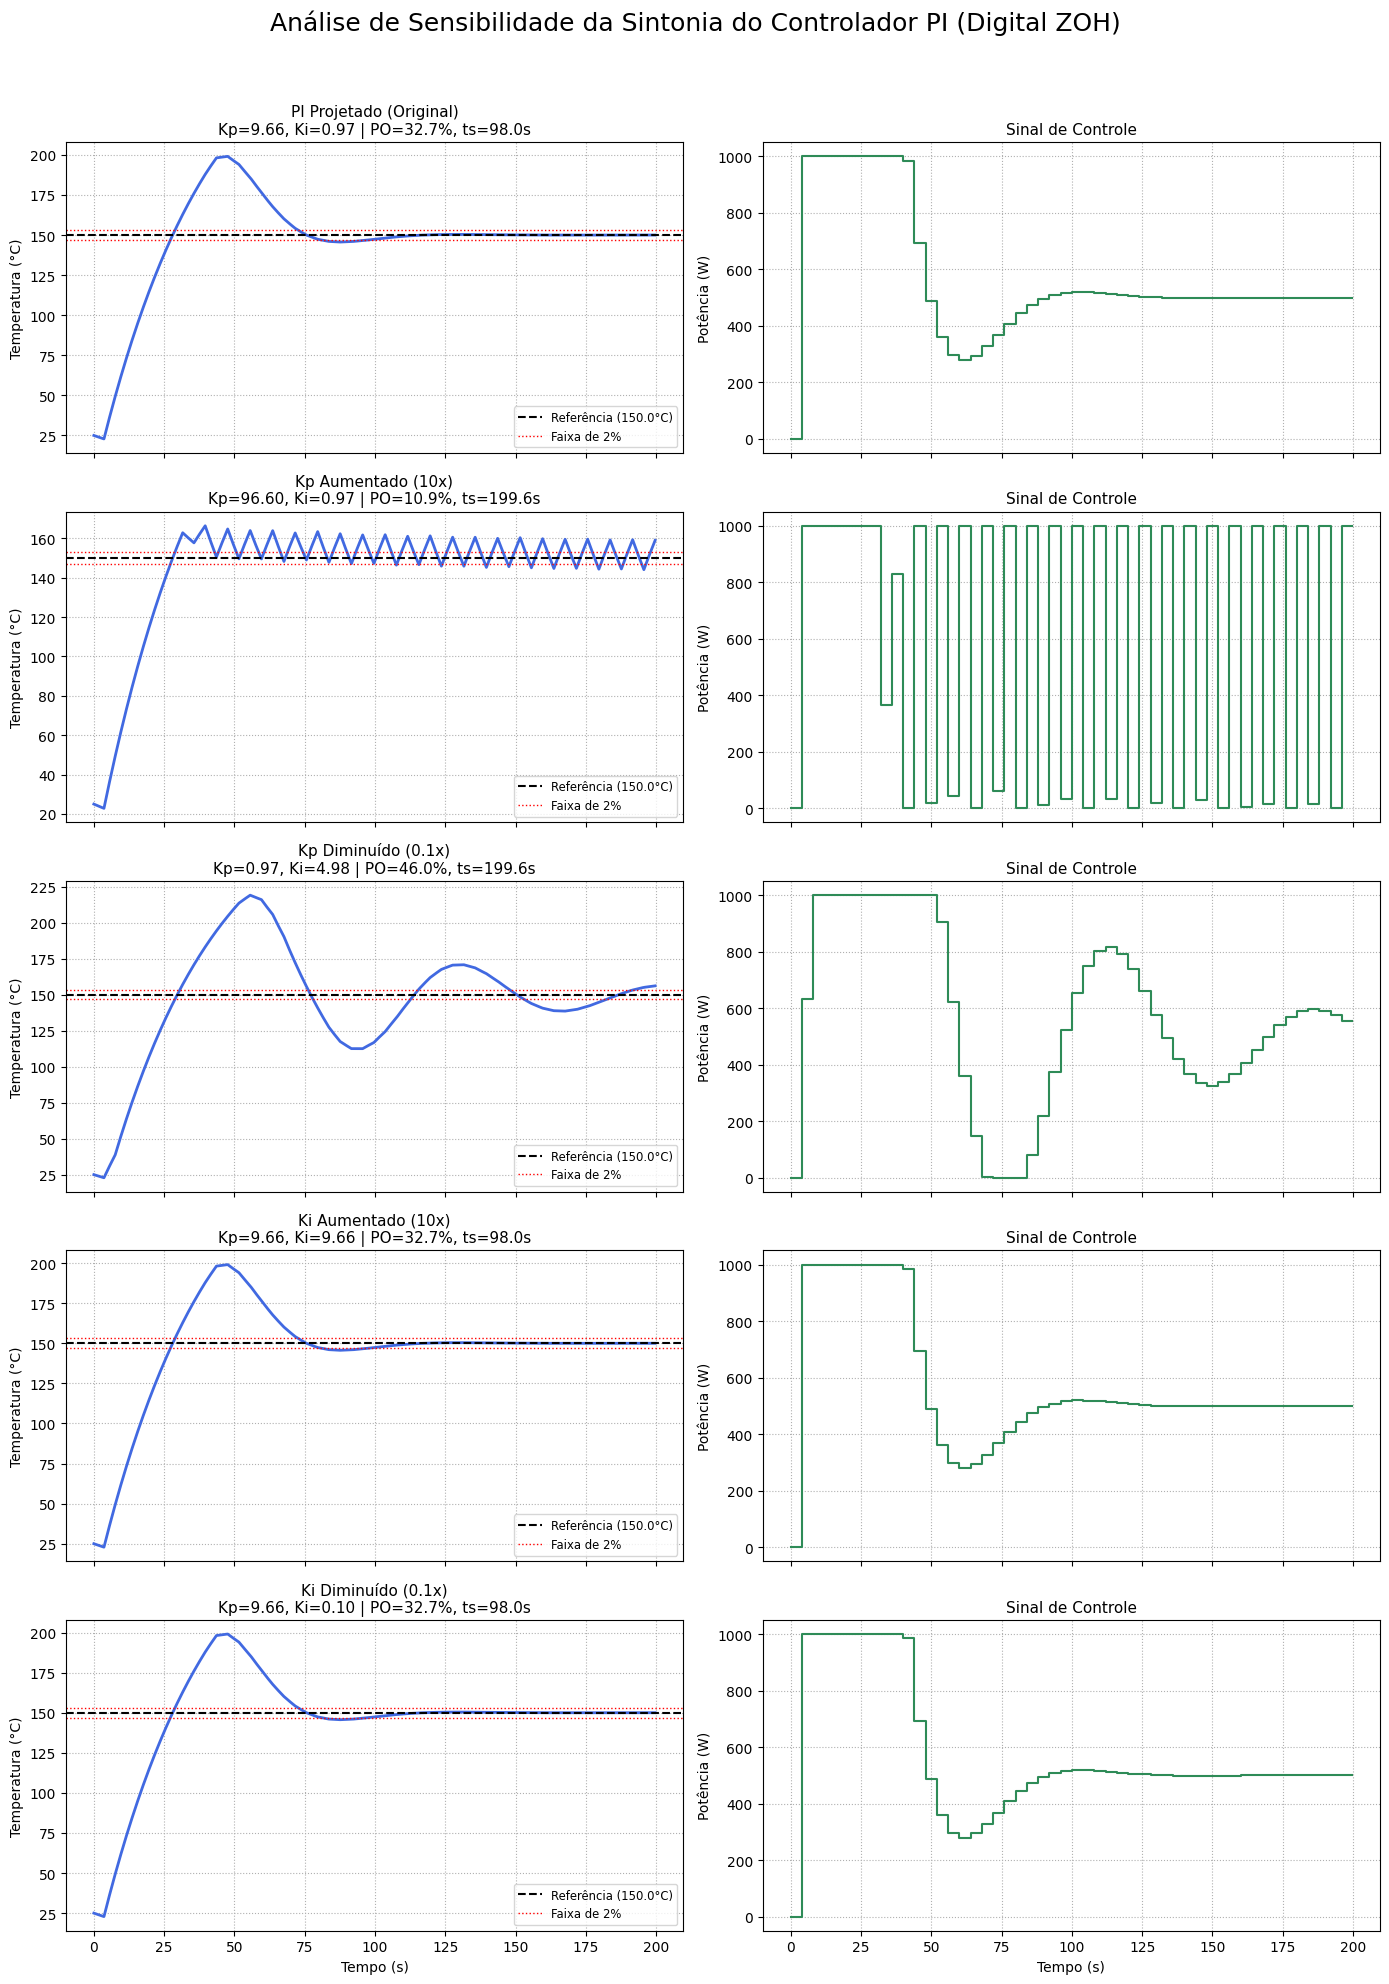

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
import math

# =============================================================================
# FUNÇÕES AUXILIARES E DE SIMULAÇÃO (COM CORREÇÕES)
# =============================================================================

def projetar_controlador_raizes(num, den, PO, t2p):
    """
    Projeta um controlador PI por lugar das raízes para planta de 1ª ordem.
    Retorna os ganhos Kp e Ki.
    """
    # 1. Parâmetros de desempenho
    zeta = -np.log(PO / 100) / np.sqrt(np.pi**2 + (np.log(PO / 100))**2)
    wn = 4 / (zeta * t2p)
    wd = wn * np.sqrt(1 - zeta**2)

    # 2. Extrai parâmetros da planta G(s) = K_planta / (tau*s + 1)
    K_planta = num[0] / den[1]
    tau = den[0] / den[1]

    # 3. Define o zero do controlador PI para cancelar o polo da planta
    z = 1 / tau

    # 4. Polos dominantes desejados em malha fechada
    sd = -zeta * wn + 1j * wd

    # 5. Condição de magnitude para encontrar Kp
    # Com o cancelamento, L(s) = Kp * K_planta / (tau * s)
    Kp = abs(tau * sd) / K_planta
    Ki = Kp * z

    return Kp, Ki

def malha_aberta(y0, potencia_constante, T_int, n_int, K, tau):
    """Simula a resposta em malha aberta. RETORNA y E u."""
    y = np.zeros(n_int)
    u = np.full(n_int, potencia_constante)
    y[0] = y0

    for k in range(1, n_int):
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return y, u  # <-- CORREÇÃO APLICADA

def malha_fechada_sem_controlador(y0, r, T_int, n_int, K, tau):
    """Simula a malha fechada sem controlador. RETORNA y E u."""
    y = np.zeros(n_int)
    u = np.zeros(n_int)
    y[0] = y0

    for k in range(1, n_int):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return y, u  # <-- CORREÇÃO APLICADA

def malha_fechada_com_controlador_pi(y0, r, T_int, n_int, K, tau, Kp, Ki, potencia_max=1000):
    """Simula a malha fechada com PI contínuo. RETORNA y E u."""
    y = np.zeros(n_int)
    u = np.zeros(n_int)
    y[0] = y0
    integral_erro = 0.0

    for k in range(1, n_int):
        erro = r - y[k-1]
        integral_erro += erro * T_int
        u_calculado = Kp * erro + Ki * integral_erro

        if u_calculado > potencia_max: u_calculado = potencia_max
        if u_calculado < 0: u_calculado = 0
        u[k] = u_calculado

        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return y, u  # <-- CORREÇÃO APLICADA

def simula_sistema_pi_zoh(K, tau, Kp, Ki, setpoint, t_final, y0=25.0, potencia_max=1000):
    """Simula o sistema com PI digital e ZOH. Esta função já estava correta."""
    h = tau / 100.0
    Ts = tau / 10.0
    passos_por_amostra = int(Ts / h)
    t = np.arange(0, t_final, h)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    e = np.zeros(n_pontos)
    y[0] = y0
    integral_sum = 0.0
    u_held = 0.0

    for k in range(1, n_pontos):
        if k > 0 and k % passos_por_amostra == 0:
            erro_atual = setpoint - y[k-1]
            integral_sum += Ki * Ts * erro_atual
            if integral_sum > potencia_max: integral_sum = potencia_max
            elif integral_sum < 0: integral_sum = 0
            u_calculado = Kp * erro_atual + integral_sum
            if u_calculado > potencia_max: u_held = potencia_max
            elif u_calculado < 0: u_held = 0
            else: u_held = u_calculado
        u[k] = u_held
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + h * dy_dt
        e[k] = setpoint - y[k]
    return t, y, u, e

def medir_metricas(t, y, r):
    """
    Calcula o sobressinal percentual (PO) e o tempo de acomodação de 2% (ts2).

    Args:
        t (array): Vetor de tempo.
        y (array): Vetor da resposta do sistema.
        r (float): Valor da referência (regime permanente esperado).

    Returns:
        tuple: (PO, ts2)
    """
    # Cálculo do Sobressinal (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100) # Garante que não seja negativo se não houver sobressinal

    # Cálculo do Tempo de Acomodação (ts2)
    ts2 = None
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Encontra o último momento em que a resposta esteve fora da faixa de 2%
    for i in range(len(y) - 1, -1, -1):
        if y[i] > limite_superior or y[i] < limite_inferior:
            ts2 = t[i]
            break

    return po, ts2

# =============================================================================
# BLOCO PRINCIPAL DE EXECUÇÃO (SEU CÓDIGO, AGORA FUNCIONAL)
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta ---
    K_planta = .3
    tau = 10.0
    num_planta = [K_planta]
    den_planta = [tau, 1]

    # --- 2. Definição das Especificações de Desempenho ---
    PO_desejado = 5.0
    t2p_desejado = 20.0

    # --- 3. Projeto do Controlador PI ---
    Kp, Ki = projetar_controlador_raizes(num_planta, den_planta, PO_desejado, t2p_desejado)
    print("--- Controlador PI Projetado ---")
    print(f"Kp = {Kp:.4f}")
    print(f"Ki = {Ki:.4f}")

    # --- 4. Configuração da Simulação ---
    T_sim = 200 # Tempo maior para ver a estabilização completa
    T_int = tau / 100.0
    n_int = int(T_sim / T_int)
    t_continuo = np.linspace(0, T_sim, n_int)
    y0 = 25.0
    r = 150.0  # Referência de temperatura
    potencia_max = 1000.0

    # Potência constante para a simulação de malha aberta
    potencia_ma = r / K_planta

    # --- 5. Simulações principais ---
    print("\nExecutando simulações...")
    y_ma, u_ma = malha_aberta(y0, potencia_ma, T_int, n_int, K_planta, tau)
    y_mf_sc, u_mf_sc = malha_fechada_sem_controlador(y0, r, T_int, n_int, K_planta, tau)
    y_mf_cc, u_mf_cc = malha_fechada_com_controlador_pi(y0, r, T_int, n_int, K_planta, tau, Kp, Ki, potencia_max)
    t_zoh, y_zoh, u_zoh, e_zoh = simula_sistema_pi_zoh(K_planta, tau, Kp, Ki, r, T_sim, y0, potencia_max)
    print("Simulações concluídas.")
    # Calculate and display metrics for each simulation
    print("\n--- Análise das Métricas de Desempenho ---")

    # Malha Aberta
    # Para malha aberta, não há sobressinal nem tempo de acomodação no sentido tradicional de controle de malha fechada.
    # O valor de regime permanente é K*potencia_ma.
    y_ma_final, ts2_ma = medir_metricas(t_continuo, y_ma, r)
    print("\nMalha Aberta:")
    print(f"Valor de regime permanente: {y_ma_final:.2f} °C")
    print(f"Tempo de Acomodação (ts2): {ts2_ma:.2f} s")


    # Malha Fechada Sem Controlador
    po_mf_sc, ts2_mf_sc = medir_metricas(t_continuo, y_mf_sc, r)
    print("\nMalha Fechada Sem Controlador:")
    print(f"Sobressinal (PO): {po_mf_sc:.2f} %")
    print(f"Tempo de Acomodação (ts2): {ts2_mf_sc:.2f} s")


    # Malha Fechada com PI Contínuo
    po_mf_cc, ts2_mf_cc = medir_metricas(t_continuo, y_mf_cc, r)
    print("\nMalha Fechada com PI Contínuo:")
    print(f"Sobressinal (PO): {po_mf_cc:.2f} %")
    print(f"Tempo de Acomodação (ts2): {ts2_mf_cc:.2f} s")

    # Malha Fechada com PI Digital (ZOH)
    # Usar o vetor de tempo e resposta da simulação ZOH
    po_zoh, ts2_zoh = medir_metricas(t_zoh, y_zoh, r)
    print("\nMalha Fechada com PI Digital (ZOH):")
    print(f"Sobressinal (PO): {po_zoh:.2f} %")
    print(f"Tempo de Acomodação (ts2): {ts2_zoh:.2f} s")
    # --- 6. Plotagem no Grid 2x4 ---
    fig, axs = plt.subplots(2, 4, figsize=(24, 11), sharex=True, constrained_layout=True)
    fig.suptitle('Comparativo de Estratégias de Controle', fontsize=20)

    # --- Coluna 1: Malha Aberta ---
    axs[0, 0].plot(t_continuo, y_ma, label=f'Saída y(t)\nRegime Permanente={y_ma_final:.2f}°C')
    axs[0, 0].axhline(y=potencia_ma * K_planta, color='r', linestyle='--', label=f'Valor esperado ({potencia_ma*K_planta:.1f}°C)%\nts2={ts2_ma:.2f}s')
    axs[0, 0].set_title('Malha Aberta')
    axs[0, 0].set_ylabel('Temperatura (°C)')
    axs[0, 0].grid(True)
    axs[0, 0].legend()
    axs[1, 0].plot(t_continuo, u_ma, color='g')
    axs[1, 0].set_title('Potência (Entrada Constante)')
    axs[1, 0].set_ylabel('Potência (W)')
    axs[1, 0].set_xlabel('Tempo (s)')
    axs[1, 0].grid(True)
    axs[1, 0].set_ylim(0, potencia_max * 1.1)

    # --- Coluna 2: Malha Fechada Sem Controlador ---
    axs[0, 1].plot(t_continuo, y_mf_sc, label=f'Saída y(t)\nPO={po_mf_sc:.2f}%\nts2={ts2_mf_sc:.2f}s')
    axs[0, 1].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r}°C)')
    axs[0, 1].set_title('Malha Fechada (Sem Controle)')
    axs[0, 1].grid(True)
    axs[0, 1].legend()
    axs[1, 1].plot(t_continuo, u_mf_sc, color='g')
    axs[1, 1].set_title('Potência (u = erro)')
    axs[1, 1].set_xlabel('Tempo (s)')
    axs[1, 1].grid(True)
    axs[1, 1].set_ylim(0, potencia_max * 1.1)

    # --- Coluna 3: Malha Fechada com PI Contínuo ---
    axs[0, 2].plot(t_continuo, y_mf_cc, label=f'Saída y(t)\nPO={po_mf_cc:.2f}%\nts2={ts2_mf_cc:.2f}s')
    axs[0, 2].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r}°C)')
    axs[0, 2].set_title('Malha Fechada (PI Contínuo)')
    axs[0, 2].grid(True)
    axs[0, 2].legend()
    axs[1, 2].plot(t_continuo, u_mf_cc, color='b')
    axs[1, 2].set_title('Potência (PI Contínuo)')
    axs[1, 2].set_xlabel('Tempo (s)')
    axs[1, 2].grid(True)
    axs[1, 2].set_ylim(0, potencia_max * 1.1)

    # --- Coluna 4: Malha Fechada com PI Digital (ZOH) ---
    axs[0, 3].plot(t_zoh, y_zoh, label=f'Saída y(t)\nPO={po_zoh:.2f}%\nts2={ts2_zoh:.2f}s')
    axs[0, 3].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r}°C)')
    axs[0, 3].set_title('Malha Fechada (PI Digital ZOH)')
    axs[0, 3].grid(True)
    axs[0, 3].legend()
    axs[1, 3].plot(t_zoh, u_zoh, color='b', drawstyle='steps-post')
    axs[1, 3].set_title('Potência (PI Digital ZOH)')
    axs[1, 3].set_xlabel('Tempo (s)')
    axs[1, 3].grid(True)
    axs[1, 3].set_ylim(0, potencia_max * 1.1)

    plt.show()
# --- PARTE 4: SIMULAÇÃO COM VARIAÇÕES ---
casos_de_sintonia = {
    "PI Projetado (Original)": (Kp, Ki),
    "Kp Aumentado (10x)":       (Kp * 10.0, Ki),
    "Kp Diminuído (0.1x)":     (Kp * 0.1, Ki_proj),
    "Ki Aumentado (10x)":       (Kp, Ki * 10.0),
    "Ki Diminuído (0.1x)":     (Kp, Ki * 0.1),
}
resultados_simulacao = {}
for nome_caso, (kp, ki) in casos_de_sintonia.items():
    y, u = simular_sistema_zoh(K_planta, tau, kp, ki)
    po, ts, err_ss = analisar_desempenho(t_vetor, y, r)
    resultados_simulacao[nome_caso] = {
        'y': y, 'u': u, 'po': po, 'ts': ts, 'err_ss': err_ss, 'kp': kp, 'ki': ki
    }

# =============================================================================
# PARTE 5: PLOTAGEM EM GRID SEPARADO (NOVO)
# =============================================================================
print("\nGerando gráficos em grid separado...")

# Número de casos para determinar o tamanho do grid
num_casos = len(casos_de_sintonia)
fig, axs = plt.subplots(
    num_casos, 2,
    figsize=(14, 4 * num_casos),
    sharex=True # Compartilha o eixo x entre todos os plots
)

# Título geral da figura
fig.suptitle("Análise de Sensibilidade da Sintonia do Controlador PI (Digital ZOH)", fontsize=18, y=0.99)

# Loop para preencher cada linha do grid
for i, (nome_caso, res) in enumerate(resultados_simulacao.items()):
    # --- Coluna 1: Resposta do Sistema (Temperatura) ---
    ax_resp = axs[i, 0]
    ax_resp.plot(t_vetor, res['y'], color='royalblue', linewidth=2)
    ax_resp.axhline(y=r, color='black', linestyle='--', label=f'Referência ({r}°C)')

    # Linhas de especificação de acomodação
    ax_resp.axhline(y=r*1.02, color='red', linestyle=':', linewidth=1)
    ax_resp.axhline(y=r*0.98, color='red', linestyle=':', linewidth=1, label='Faixa de 2%')

    # Adiciona título com os ganhos e métricas
    titulo_resp = (f"{nome_caso}\n"
                   f"Kp={res['kp']:.2f}, Ki={res['ki']:.2f} | "
                   f"PO={res['po']:.1f}%, ts={res['ts']:.1f}s")
    ax_resp.set_title(titulo_resp, fontsize=11)
    ax_resp.set_ylabel("Temperatura (°C)")
    ax_resp.grid(True, which='both', linestyle=':')
    ax_resp.legend(loc='lower right', fontsize='small')

    # --- Coluna 2: Sinal de Controle (Potência) ---
    ax_ctrl = axs[i, 1]
    ax_ctrl.plot(t_vetor, res['u'], color='seagreen', drawstyle='steps-post', linewidth=1.5)
    ax_ctrl.set_title("Sinal de Controle", fontsize=11)
    ax_ctrl.set_ylabel("Potência (W)")
    ax_ctrl.grid(True, which='both', linestyle=':')
    ax_ctrl.set_ylim(-50, potencia_max * 1.05) # Garante uma boa visualização do limite

# Adiciona o label do eixo x apenas no último subplot para não poluir
axs[num_casos-1, 0].set_xlabel("Tempo (s)")
axs[num_casos-1, 1].set_xlabel("Tempo (s)")

# Ajusta o layout para evitar sobreposição de títulos
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

--- Controlador PI Projetado ---
Ganho Proporcional (Kp): 10.00
Ganho Integral (Ki):     0.70

Executando simulações comparativas...

Executando simulações para análise de sensibilidade...


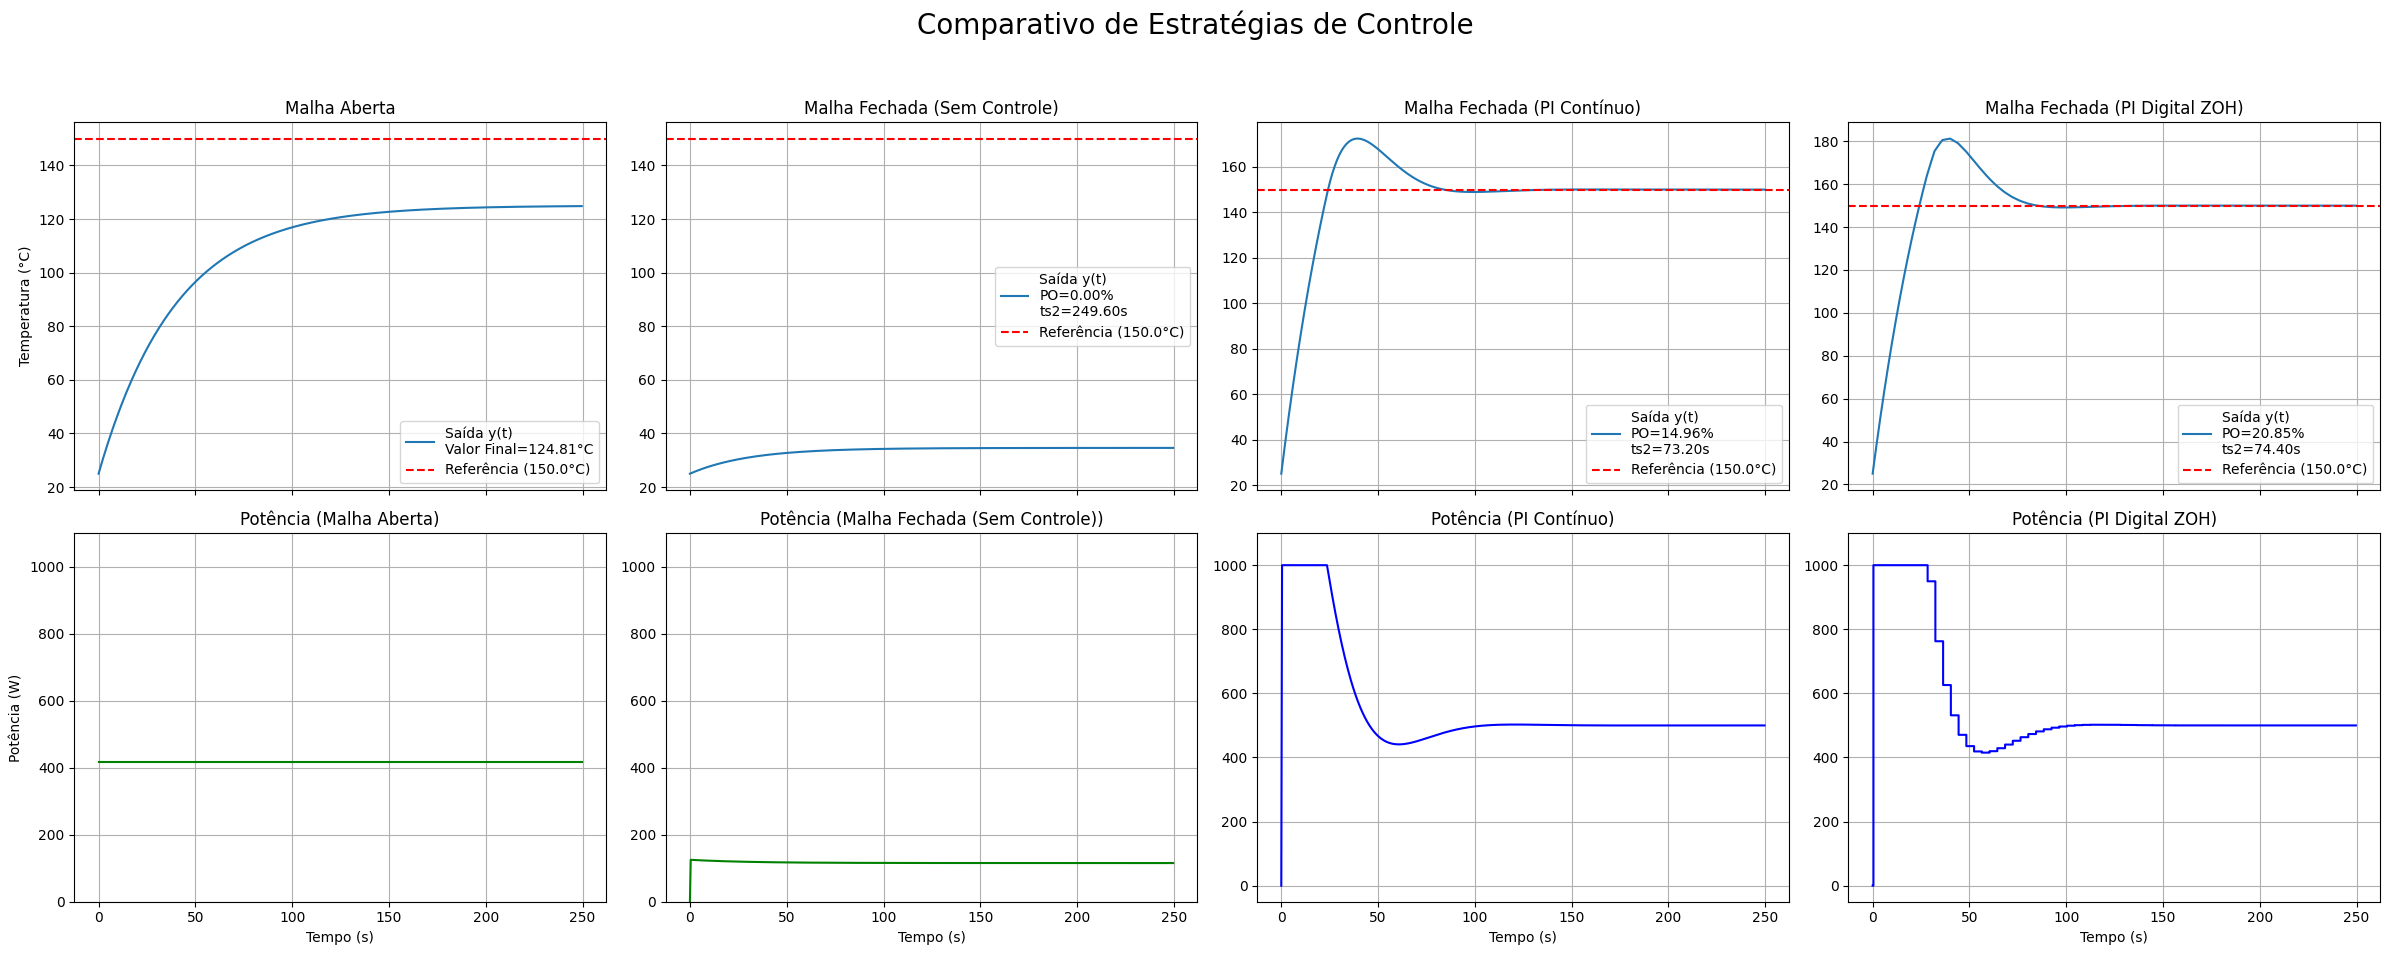

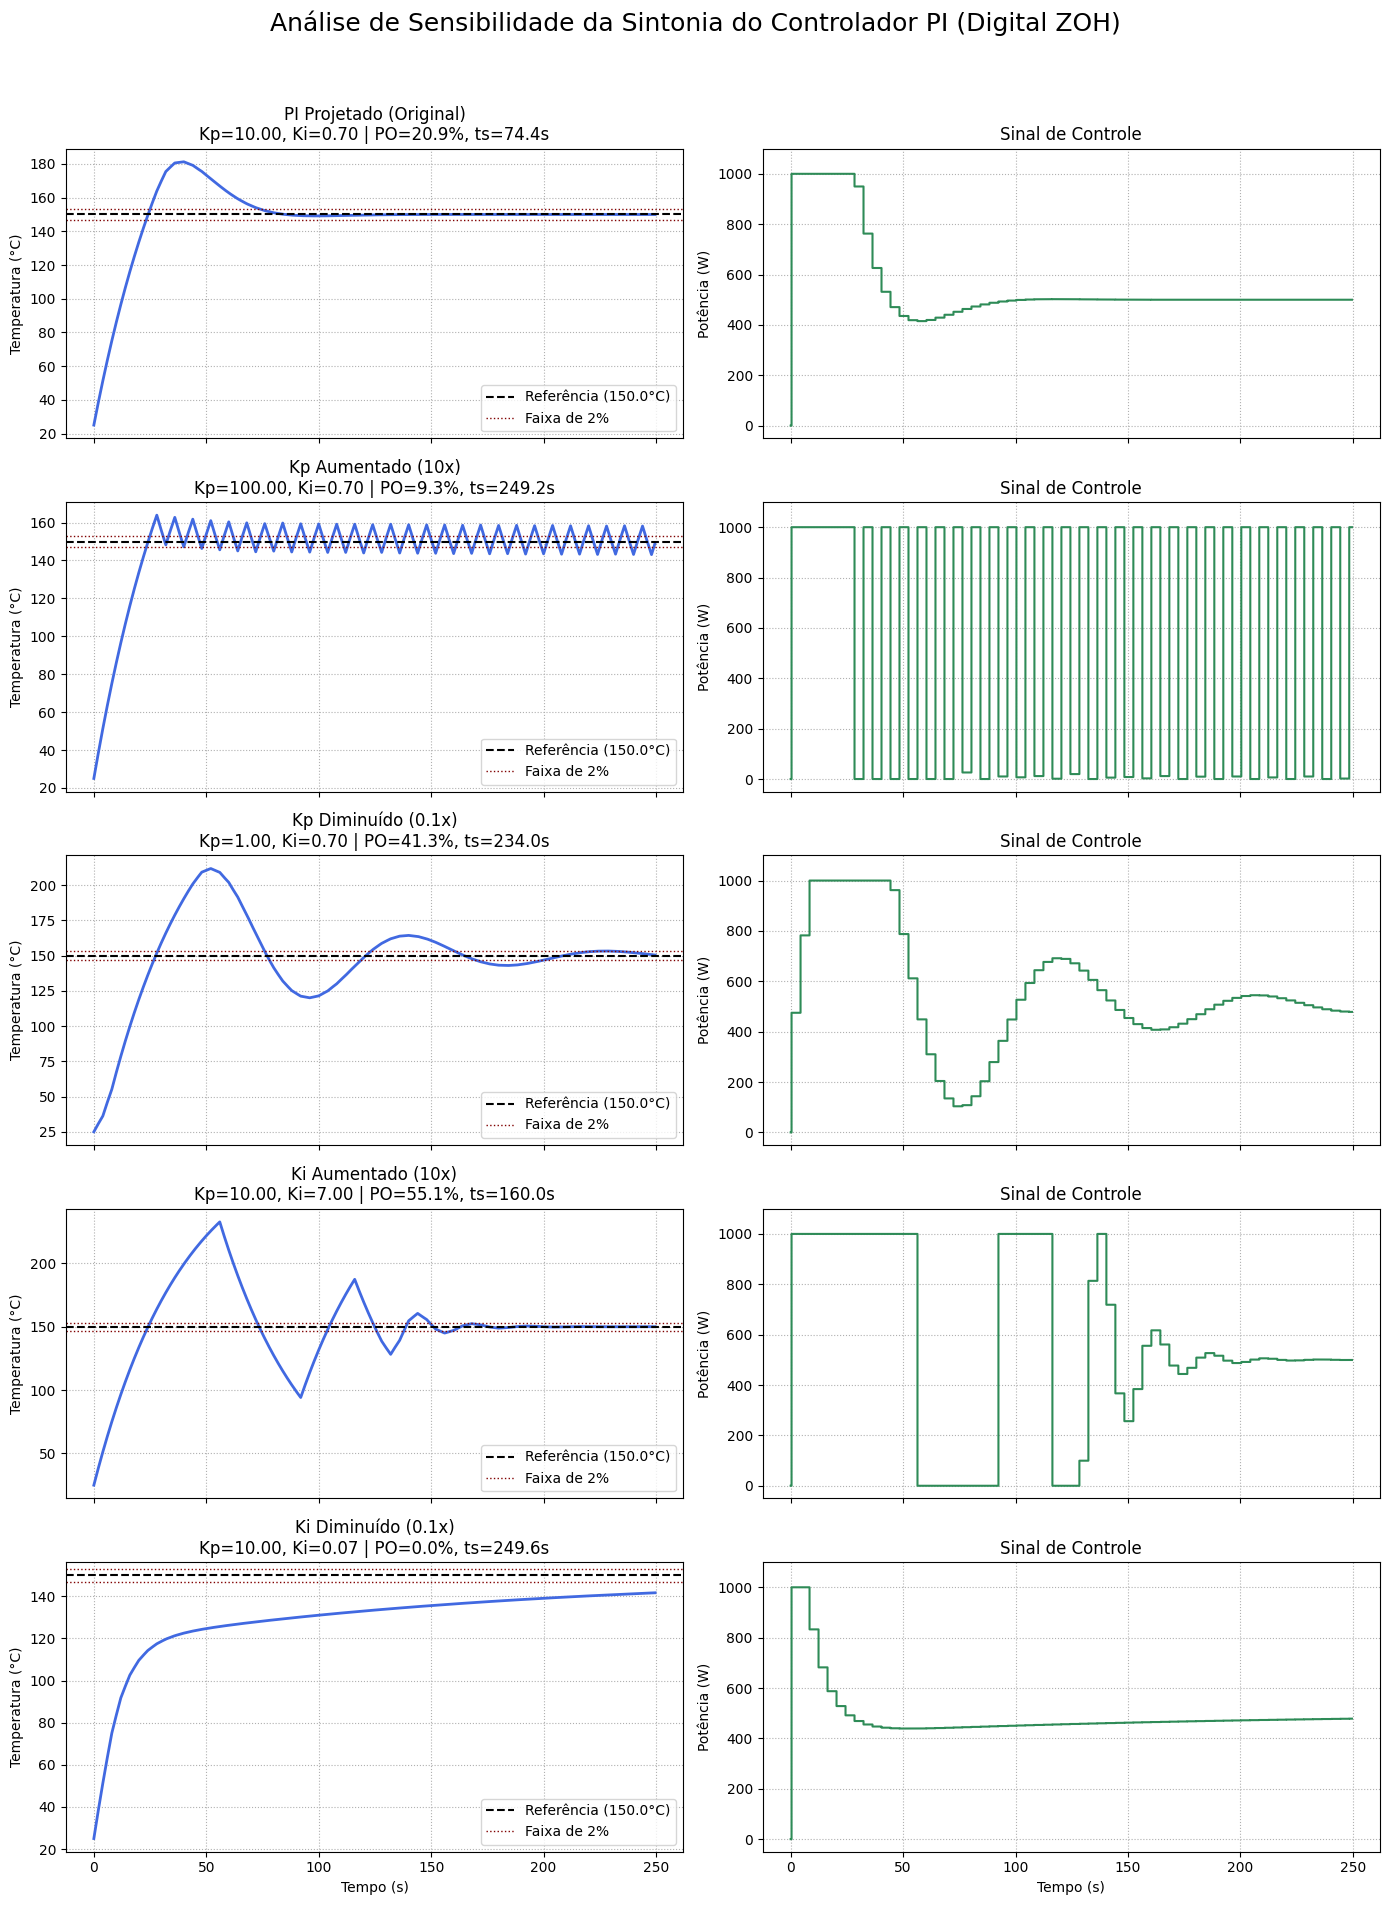

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (CORRIGIDAS E COMPLETAS)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    para atender a especificações de desempenho de 2ª ordem (PO, ts).

    Args:
        K_planta (float): Ganho estático da planta.
        tau_planta (float): Constante de tempo da planta.
        PO_desejado (float): Sobressinal percentual desejado (ex: 15 para 15%).
        ts_desejado (float): Tempo de acomodação de 2% desejado.

    Returns:
        tuple: Ganhos (Kp, Ki) do controlador PI.
    """
    # 1. Converter especificações de desempenho em parâmetros de 2ª ordem (zeta, wn)
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1 # Criticamente amortecido se não houver sobressinal

    wn = 4 / (zeta * ts_desejado)

    # 2. A equação característica da malha fechada é: tau*s^2 + (1 + K*Kp)s + K*Ki = 0
    #    Normalizando: s^2 + (1 + K*Kp)/tau * s + (K*Ki)/tau = 0
    # 3. A equação característica desejada é: s^2 + 2*zeta*wn*s + wn^2 = 0
    # 4. Igualando os coeficientes para encontrar Kp e Ki:

    # A partir de wn^2 = (K_planta * Ki) / tau_planta
    ki = (wn**2 * tau_planta) / K_planta

    # A partir de 2*zeta*wn = (1 + K_planta * Kp) / tau_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta

    return kp, ki

def simular_malha_aberta(y0, u_const, t_sim, T_int, K, tau):
    """Simula a resposta da planta em malha aberta a uma entrada constante."""
    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.full(n_pontos, u_const)
    y[0] = y0

    for k in range(1, n_pontos):
        dydt = (K * u[k-1] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_sem_controle(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada sem controlador (equivale a um P com Kp=1)."""
    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    y[0] = y0

    for k in range(1, n_pontos):
        erro = r - y[k-1]
        u[k] = erro  # Ação de controle é o próprio erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_continuo(y0, r, t_sim, T_int, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com um controlador PI 'contínuo' (passo de integração pequeno)."""
    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    y[0] = y0
    integral_erro = 0.0

    for k in range(1, n_pontos):
        erro = r - y[k-1]
        integral_erro += erro * T_int
        u_calculado = Kp * erro + Ki * integral_erro

        # Saturação do atuador
        u[k] = np.clip(u_calculado, 0, u_max)

        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH)."""
    # Parâmetros de simulação conforme especificação do trabalho
    T_int = tau / 100.0  # Passo de integração da planta
    Ts = tau / 10.0      # Intervalo de amostragem do controlador
    passos_por_amostra = int(round(Ts / T_int))

    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    y[0] = y0

    integral_sum = 0.0
    u_held = 0.0  # Sinal de controle mantido pelo ZOH

    for k in range(1, n_pontos):
        # Controlador atualiza o sinal de controle a cada 'Ts' segundos
        if (k - 1) % passos_por_amostra == 0:
            erro_atual = r - y[k-1]

            # Equação do PI digital (forma posicional)
            # A integral é a soma acumulada do erro vezes o período de amostragem
            integral_sum += Ki * Ts * erro_atual
            u_calculado = Kp * erro_atual + integral_sum

            # Saturação do atuador e armazenamento no ZOH
            u_held = np.clip(u_calculado, 0, u_max)

        u[k] = u_held  # Aplica o sinal do ZOH à planta

        # Simulação da planta com o passo de integração pequeno
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt

    return t, y, u

def medir_metricas(t, y, r):
    """Calcula o sobressinal percentual (PO) e o tempo de acomodação de 2% (ts2)."""
    # Sobressinal Percentual (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100) if r > 0 else 0.0

    # Tempo de Acomodação (ts2)
    ts2 = t[-1]  # Valor padrão se nunca estabilizar na faixa
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Itera de trás para frente para encontrar o último ponto fora da faixa
    for i in range(len(y) - 1, -1, -1):
        if y[i] > limite_superior or y[i] < limite_inferior:
            ts2 = t[i+1] if i + 1 < len(t) else t[-1]
            break
        if i == 0: # Se esteve sempre na faixa
             ts2 = t[0]

    # Valor final para referência
    valor_final = y[-1]

    return po, ts2, valor_final

# =============================================================================
# PARTE 2: BLOCO PRINCIPAL DE EXECUÇÃO
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta ---
    K_planta = .3
    tau = 10.0
    num_planta = [K_planta]
    den_planta = [tau, 1]

    # --- 2. Definição das Especificações de Desempenho ---
    PO_desejado = 5.0
    t2p_desejado = 20.0

    # --- 3. Projeto do Controlador PI ---
    Kp, Ki = projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado)
    print("--- Controlador PI Projetado ---")
    print(f"Ganho Proporcional (Kp): {Kp:.2f}")
    print(f"Ganho Integral (Ki):     {Ki:.2f}")

    # --- 4. Parâmetros Gerais da Simulação ---
    T_sim = 250.0       # Tempo total de simulação
    y0 = 25.0           # Temperatura inicial (°C)
    r = 150.0           # Referência de temperatura (°C)
    potencia_max = 1000.0 # Potência máxima do atuador (W)
    T_int_continuo = tau_planta / 100.0 # Passo para simulações 'contínuas'

    # --- 5. Execução das Simulações para Comparativo ---
    print("\nExecutando simulações comparativas...")
    # Malha Aberta (entrada para atingir a referência em regime permanente)
    u_ma = (r - y0) / K_planta
    t_ma, y_ma, u_ma_plot = simular_malha_aberta(y0, u_ma, T_sim, T_int_continuo, K_planta, tau_planta)

    # Malha Fechada sem controlador
    t_mfsc, y_mfsc, u_mfsc = simular_malha_fechada_sem_controle(y0, r, T_sim, T_int_continuo, K_planta, tau_planta)

    # Malha Fechada com PI Contínuo
    t_pic, y_pic, u_pic = simular_pi_continuo(y0, r, T_sim, T_int_continuo, K_planta, tau_planta, Kp, Ki, potencia_max)

    # Malha Fechada com PI Digital (ZOH)
    t_zoh, y_zoh, u_zoh = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, Kp, Ki, potencia_max)

    # --- 6. Cálculo das Métricas para os Gráficos ---
    po_ma, ts_ma, yf_ma = medir_metricas(t_ma, y_ma, r)
    po_mfsc, ts_mfsc, yf_mfsc = medir_metricas(t_mfsc, y_mfsc, r)
    po_pic, ts_pic, yf_pic = medir_metricas(t_pic, y_pic, r)
    po_zoh, ts_zoh, yf_zoh = medir_metricas(t_zoh, y_zoh, r)

    # --- 7. Plotagem do Gráfico Comparativo (Figura 1) ---
    fig1, axs1 = plt.subplots(2, 4, figsize=(24, 10), sharex=True)
    fig1.suptitle('Comparativo de Estratégias de Controle', fontsize=20)

    # Coluna 1: Malha Aberta
    axs1[0, 0].plot(t_ma, y_ma, label=f'Saída y(t)\nValor Final={yf_ma:.2f}°C')
    axs1[0, 0].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)')
    axs1[0, 0].set_title('Malha Aberta')
    axs1[0, 0].set_ylabel('Temperatura (°C)')
    axs1[0, 0].grid(True); axs1[0, 0].legend()
    axs1[1, 0].plot(t_ma, u_ma_plot, 'g')
    axs1[1, 0].set_title('Potência (Malha Aberta)')
    axs1[1, 0].set_ylabel('Potência (W)'); axs1[1, 0].set_xlabel('Tempo (s)')
    axs1[1, 0].grid(True); axs1[1, 0].set_ylim(0, potencia_max * 1.1)

    # Coluna 2: Malha Fechada (Sem Controle)
    axs1[0, 1].plot(t_mfsc, y_mfsc, label=f'Saída y(t)\nPO={po_mfsc:.2f}%\nts2={ts_mfsc:.2f}s')
    axs1[0, 1].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)')
    axs1[0, 1].set_title('Malha Fechada (Sem Controle)')
    axs1[0, 1].grid(True); axs1[0, 1].legend()
    axs1[1, 1].plot(t_mfsc, u_mfsc, 'g')
    axs1[1, 1].set_title('Potência (Malha Fechada (Sem Controle))')
    axs1[1, 1].set_xlabel('Tempo (s)'); axs1[1, 1].grid(True); axs1[1, 1].set_ylim(0, potencia_max * 1.1)

    # Coluna 3: Malha Fechada (PI Contínuo)
    axs1[0, 2].plot(t_pic, y_pic, label=f'Saída y(t)\nPO={po_pic:.2f}%\nts2={ts_pic:.2f}s')
    axs1[0, 2].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)')
    axs1[0, 2].set_title('Malha Fechada (PI Contínuo)')
    axs1[0, 2].grid(True); axs1[0, 2].legend()
    axs1[1, 2].plot(t_pic, u_pic, 'b')
    axs1[1, 2].set_title('Potência (PI Contínuo)')
    axs1[1, 2].set_xlabel('Tempo (s)'); axs1[1, 2].grid(True); axs1[1, 2].set_ylim(-50, potencia_max * 1.1)

    # Coluna 4: Malha Fechada (PI Digital ZOH)
    axs1[0, 3].plot(t_zoh, y_zoh, label=f'Saída y(t)\nPO={po_zoh:.2f}%\nts2={ts_zoh:.2f}s')
    axs1[0, 3].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)')
    axs1[0, 3].set_title('Malha Fechada (PI Digital ZOH)')
    axs1[0, 3].grid(True); axs1[0, 3].legend()
    axs1[1, 3].plot(t_zoh, u_zoh, 'b', drawstyle='steps-post')
    axs1[1, 3].set_title('Potência (PI Digital ZOH)')
    axs1[1, 3].set_xlabel('Tempo (s)'); axs1[1, 3].grid(True); axs1[1, 3].set_ylim(-50, potencia_max * 1.1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # --- 8. Simulações para Análise de Sensibilidade ---
    print("\nExecutando simulações para análise de sensibilidade...")
    casos_sintonia = {
        "PI Projetado (Original)": (Kp, Ki),
        "Kp Aumentado (10x)": (Kp * 10, Ki),
        "Kp Diminuído (0.1x)": (Kp * 0.1, Ki),
        "Ki Aumentado (10x)": (Kp, Ki * 10),
        "Ki Diminuído (0.1x)": (Kp, Ki * 0.1),
    }

    resultados_sensibilidade = {}
    for nome, (kp_caso, ki_caso) in casos_sintonia.items():
        t, y, u = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, kp_caso, ki_caso, potencia_max)
        po, ts, _ = medir_metricas(t, y, r)
        resultados_sensibilidade[nome] = {'t': t, 'y': y, 'u': u, 'po': po, 'ts': ts, 'kp': kp_caso, 'ki': ki_caso}

    # --- 9. Plotagem do Gráfico de Sensibilidade (Figura 2) ---
    num_casos = len(casos_sintonia)
    fig2, axs2 = plt.subplots(num_casos, 2, figsize=(14, 4 * num_casos), sharex=True)
    fig2.suptitle('Análise de Sensibilidade da Sintonia do Controlador PI (Digital ZOH)', fontsize=18)

    for i, (nome_caso, res) in enumerate(resultados_sensibilidade.items()):
        # Coluna 1: Resposta da Temperatura
        ax_resp = axs2[i, 0]
        ax_resp.plot(res['t'], res['y'], 'royalblue', linewidth=2)
        ax_resp.axhline(y=r, color='black', linestyle='--', label=f'Referência ({r}°C)')
        ax_resp.axhline(y=r * 1.02, color='maroon', linestyle=':', linewidth=1)
        ax_resp.axhline(y=r * 0.98, color='maroon', linestyle=':', linewidth=1, label='Faixa de 2%')
        titulo = f"{nome_caso}\nKp={res['kp']:.2f}, Ki={res['ki']:.2f} | PO={res['po']:.1f}%, ts={res['ts']:.1f}s"
        ax_resp.set_title(titulo)
        ax_resp.set_ylabel("Temperatura (°C)")
        ax_resp.grid(True, linestyle=':')
        ax_resp.legend(loc='lower right')

        # Coluna 2: Sinal de Controle
        ax_ctrl = axs2[i, 1]
        ax_ctrl.plot(res['t'], res['u'], 'seagreen', drawstyle='steps-post')
        ax_ctrl.set_title("Sinal de Controle")
        ax_ctrl.set_ylabel("Potência (W)")
        ax_ctrl.grid(True, linestyle=':')
        ax_ctrl.set_ylim(-50, potencia_max * 1.1)

    axs2[-1, 0].set_xlabel("Tempo (s)")
    axs2[-1, 1].set_xlabel("Tempo (s)")

    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    plt.show()

--- Controlador PI Projetado ---
Planta: K=0.3, tau=10.0
Especificações: PO<=5.0%, ts<=20.0s
Ganhos Calculados: Kp = 10.0000, Ki = 2.7997

Executando simulações comparativas...


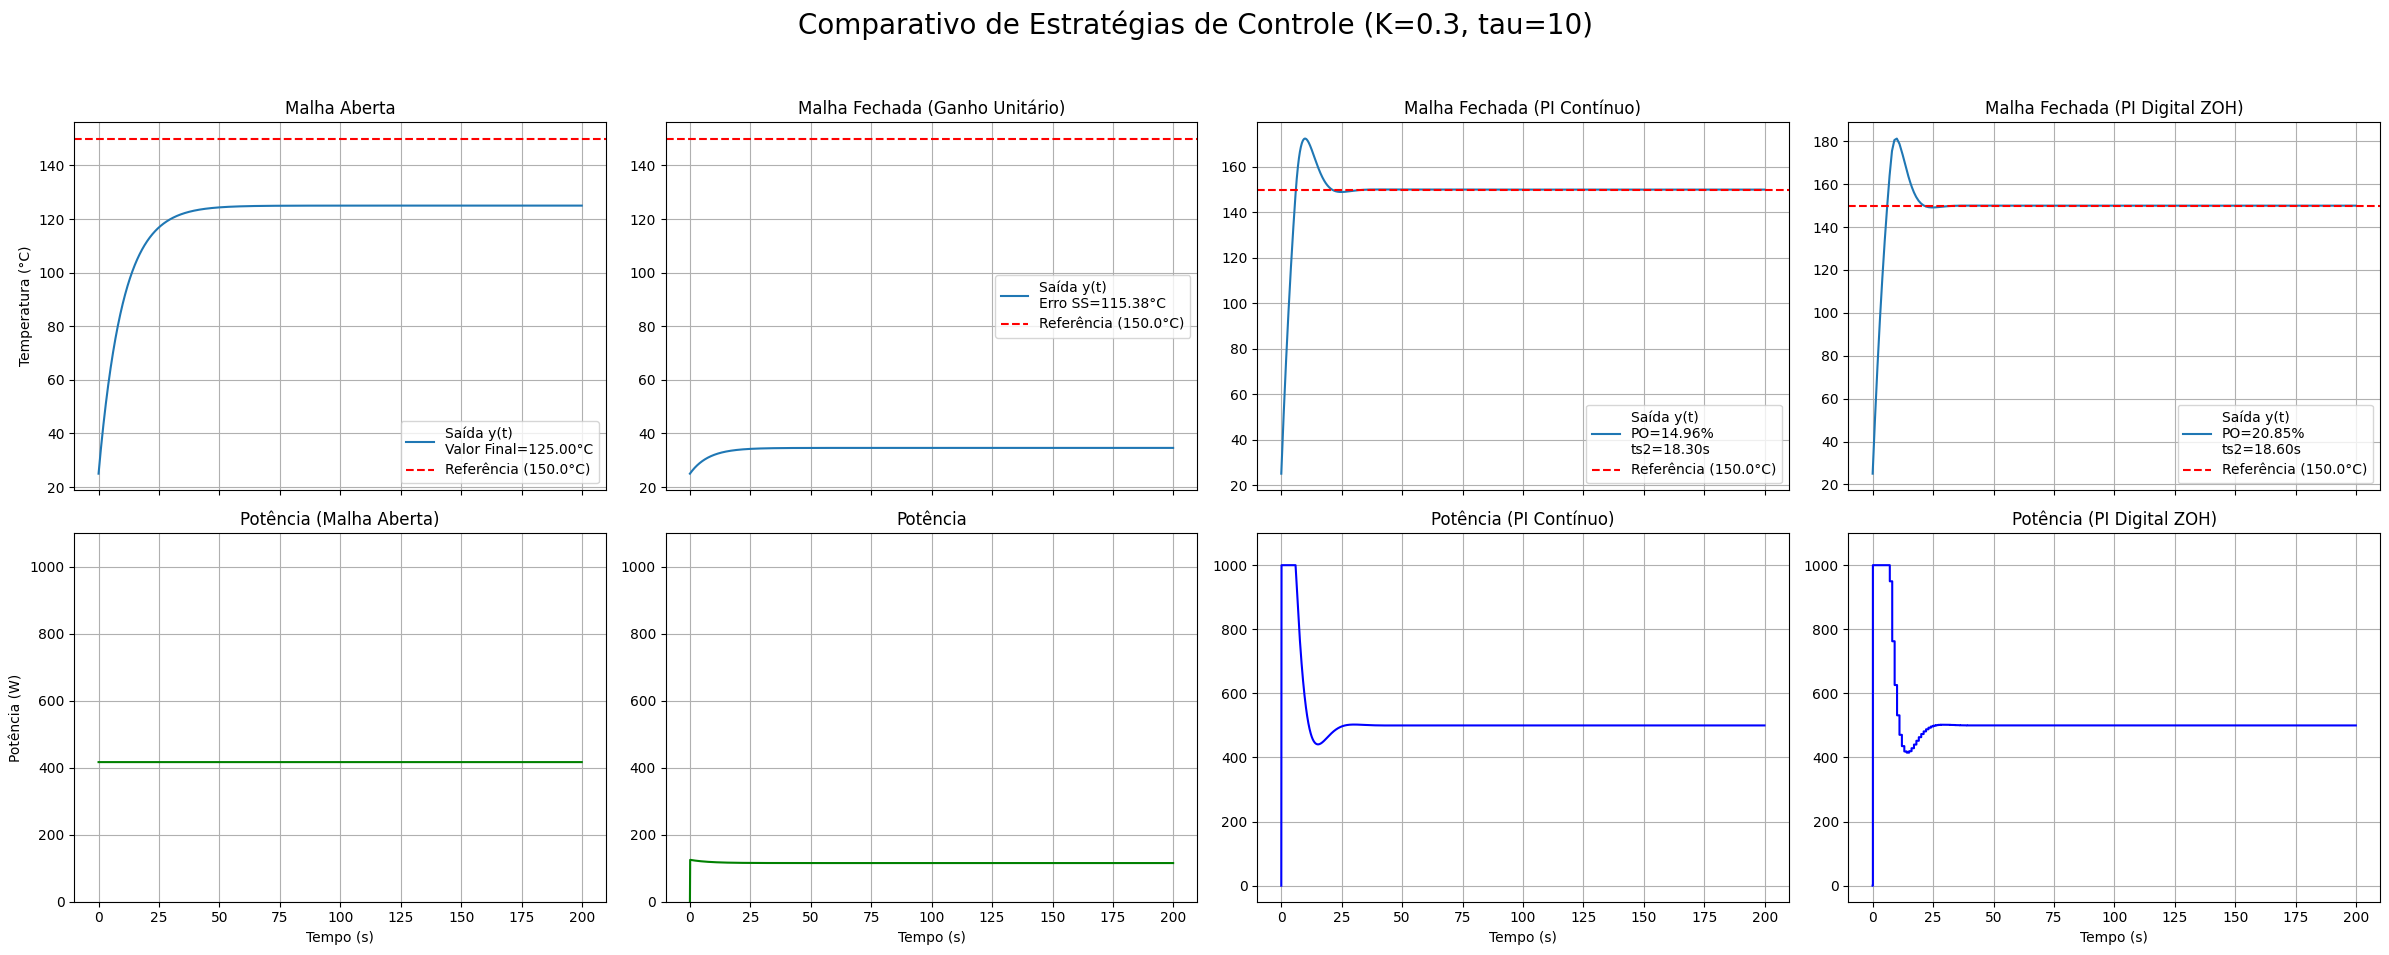

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (CORRIGIDAS E COMPLETAS)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    para atender a especificações de desempenho de 2ª ordem (PO, ts).
    """
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1
    wn = 4 / (zeta * ts_desejado)
    ki = (wn**2 * tau_planta) / K_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta
    return kp, ki

def simular_malha_aberta(y0, u_const, t_sim, T_int, K, tau):
    """Simula a resposta da planta em malha aberta a uma entrada constante."""
    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.full(n_pontos, u_const)
    y[0] = y0
    for k in range(1, n_pontos):
        dydt = (K * u[k-1] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_ganho_unitario(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com ganho unitário (sem controlador PI)."""
    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    y[0] = y0
    for k in range(1, n_pontos):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_continuo(y0, r, t_sim, T_int, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com um controlador PI 'contínuo'."""
    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    y[0] = y0
    integral_erro = 0.0
    for k in range(1, n_pontos):
        erro = r - y[k-1]
        integral_erro += erro * T_int
        u_calculado = Kp * erro + Ki * integral_erro
        u[k] = np.clip(u_calculado, 0, u_max)
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH)."""
    T_int = tau / 100.0
    Ts = tau / 10.0
    passos_por_amostra = int(round(Ts / T_int))
    t = np.arange(0, t_sim, T_int)
    n_pontos = len(t)
    y = np.zeros(n_pontos)
    u = np.zeros(n_pontos)
    y[0] = y0
    integral_sum = 0.0
    u_held = 0.0
    for k in range(1, n_pontos):
        if (k - 1) % passos_por_amostra == 0:
            erro_atual = r - y[k-1]
            integral_sum += Ki * Ts * erro_atual
            u_calculado = Kp * erro_atual + integral_sum
            u_held = np.clip(u_calculado, 0, u_max)
        u[k] = u_held
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt
    return t, y, u

def medir_metricas(t, y, r):
    """Calcula PO, ts2 e o erro de regime permanente."""
    po = max(0, ((np.max(y) - r) / r) * 100) if r > 0 else 0.0

    ts2 = np.nan # Retorna NaN (Not a Number) se nunca acomodar
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    for i in range(len(y) - 1, -1, -1):
        if y[i] > limite_superior or y[i] < limite_inferior:
            # Se encontrar um ponto fora da faixa, o ts é o próximo ponto no tempo
            if i + 1 < len(t):
                ts2 = t[i+1]
            else: # Se o último ponto estiver fora, ts é o tempo final
                ts2 = t[-1]
            break
        if i == 0: # Se esteve sempre dentro, ts é 0
             ts2 = t[0]

    valor_final = y[-1]
    erro_ss = r - valor_final
    return po, ts2, valor_final, erro_ss

# =============================================================================
# PARTE 2: BLOCO PRINCIPAL DE EXECUÇÃO COM SEUS PARÂMETROS
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta (CONFORME SOLICITADO) ---
    K_planta = 0.3
    tau_planta = 10.0

    # --- 2. Especificações de Desempenho Desejadas (CONFORME SOLICITADO) ---
    PO_desejado = 5.0
    ts_desejado = 20.0

    # --- 3. Projeto do Controlador PI ---
    Kp, Ki = projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado)
    print("--- Controlador PI Projetado ---")
    print(f"Planta: K={K_planta}, tau={tau_planta}")
    print(f"Especificações: PO<={PO_desejado}%, ts<={ts_desejado}s")
    print(f"Ganhos Calculados: Kp = {Kp:.4f}, Ki = {Ki:.4f}")

    # --- 4. Parâmetros Gerais da Simulação ---
    T_sim = 200.0
    y0 = 25.0
    r = 150.0
    potencia_max = 1000.0
    T_int_continuo = tau_planta / 100.0

    # --- 5. Execução das Simulações para Comparativo ---
    print("\nExecutando simulações comparativas...")
    u_ma = (r - y0) / K_planta
    t_ma, y_ma, u_ma_plot = simular_malha_aberta(y0, u_ma, T_sim, T_int_continuo, K_planta, tau_planta)
    t_mfgu, y_mfgu, u_mfgu = simular_malha_fechada_ganho_unitario(y0, r, T_sim, T_int_continuo, K_planta, tau_planta)
    t_pic, y_pic, u_pic = simular_pi_continuo(y0, r, T_sim, T_int_continuo, K_planta, tau_planta, Kp, Ki, potencia_max)
    t_zoh, y_zoh, u_zoh = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, Kp, Ki, potencia_max)

    # --- 6. Cálculo das Métricas para os Gráficos ---
    po_ma, ts_ma, yf_ma, ess_ma = medir_metricas(t_ma, y_ma, r)
    po_mfgu, ts_mfgu, yf_mfgu, ess_mfgu = medir_metricas(t_mfgu, y_mfgu, r)
    po_pic, ts_pic, yf_pic, ess_pic = medir_metricas(t_pic, y_pic, r)
    po_zoh, ts_zoh, yf_zoh, ess_zoh = medir_metricas(t_zoh, y_zoh, r)

    # --- 7. Plotagem do Gráfico Comparativo ---
    fig1, axs1 = plt.subplots(2, 4, figsize=(24, 10), sharex=True)
    fig1.suptitle('Comparativo de Estratégias de Controle (K=0.3, tau=10)', fontsize=20)

    # Malha Aberta
    axs1[0, 0].plot(t_ma, y_ma, label=f'Saída y(t)\nValor Final={yf_ma:.2f}°C')
    axs1[0, 0].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)')
    axs1[0, 0].set_title('Malha Aberta'); axs1[0, 0].set_ylabel('Temperatura (°C)'); axs1[0, 0].grid(True); axs1[0, 0].legend()
    axs1[1, 0].plot(t_ma, u_ma_plot, 'g'); axs1[1, 0].set_title('Potência (Malha Aberta)'); axs1[1, 0].set_ylabel('Potência (W)'); axs1[1, 0].set_xlabel('Tempo (s)'); axs1[1, 0].grid(True); axs1[1, 0].set_ylim(0, potencia_max * 1.1)

    # Malha Fechada com Ganho Unitário
    axs1[0, 1].plot(t_mfgu, y_mfgu, label=f'Saída y(t)\nErro SS={ess_mfgu:.2f}°C')
    axs1[0, 1].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)')
    axs1[0, 1].set_title('Malha Fechada (Ganho Unitário)'); axs1[0, 1].grid(True); axs1[0, 1].legend()
    axs1[1, 1].plot(t_mfgu, u_mfgu, 'g'); axs1[1, 1].set_title('Potência'); axs1[1, 1].set_xlabel('Tempo (s)'); axs1[1, 1].grid(True); axs1[1, 1].set_ylim(0, potencia_max * 1.1)

    # PI Contínuo
    axs1[0, 2].plot(t_pic, y_pic, label=f'Saída y(t)\nPO={po_pic:.2f}%\nts2={ts_pic:.2f}s')
    axs1[0, 2].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)'); axs1[0, 2].set_title('Malha Fechada (PI Contínuo)'); axs1[0, 2].grid(True); axs1[0, 2].legend()
    axs1[1, 2].plot(t_pic, u_pic, 'b'); axs1[1, 2].set_title('Potência (PI Contínuo)'); axs1[1, 2].set_xlabel('Tempo (s)'); axs1[1, 2].grid(True); axs1[1, 2].set_ylim(-50, potencia_max * 1.1)

    # PI Digital (ZOH)
    axs1[0, 3].plot(t_zoh, y_zoh, label=f'Saída y(t)\nPO={po_zoh:.2f}%\nts2={ts_zoh:.2f}s')
    axs1[0, 3].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)'); axs1[0, 3].set_title('Malha Fechada (PI Digital ZOH)'); axs1[0, 3].grid(True); axs1[0, 3].legend()
    axs1[1, 3].plot(t_zoh, u_zoh, 'b', drawstyle='steps-post'); axs1[1, 3].set_title('Potência (PI Digital ZOH)'); axs1[1, 3].set_xlabel('Tempo (s)'); axs1[1, 3].grid(True); axs1[1, 3].set_ylim(-50, potencia_max * 1.1)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- Controlador PI Projetado ---
Ganhos Calculados: Kp = 10.0000, Ki = 2.7997

Gerando Figura 1: Comparativo de Estratégias...

Gerando Figura 2: Análise de Sensibilidade...


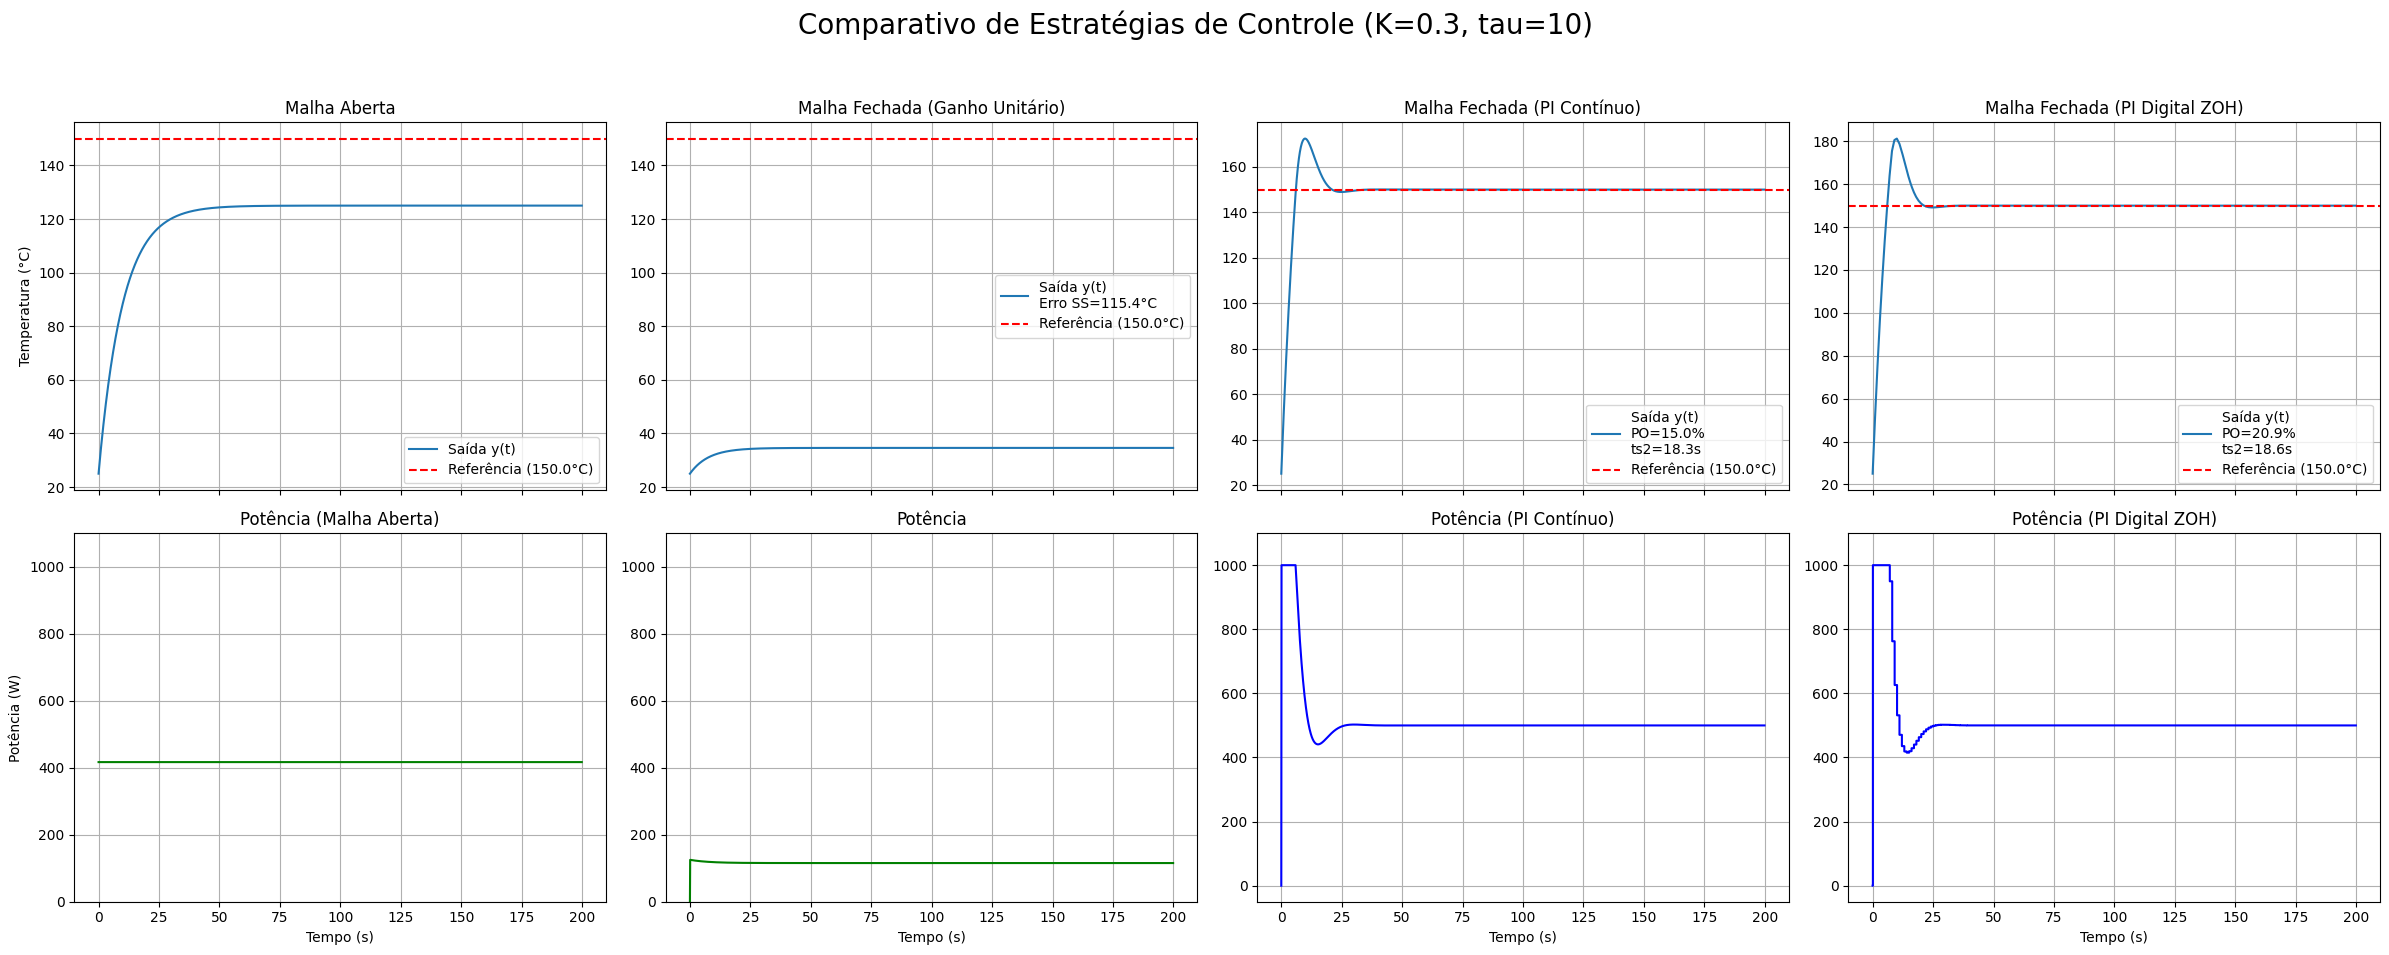

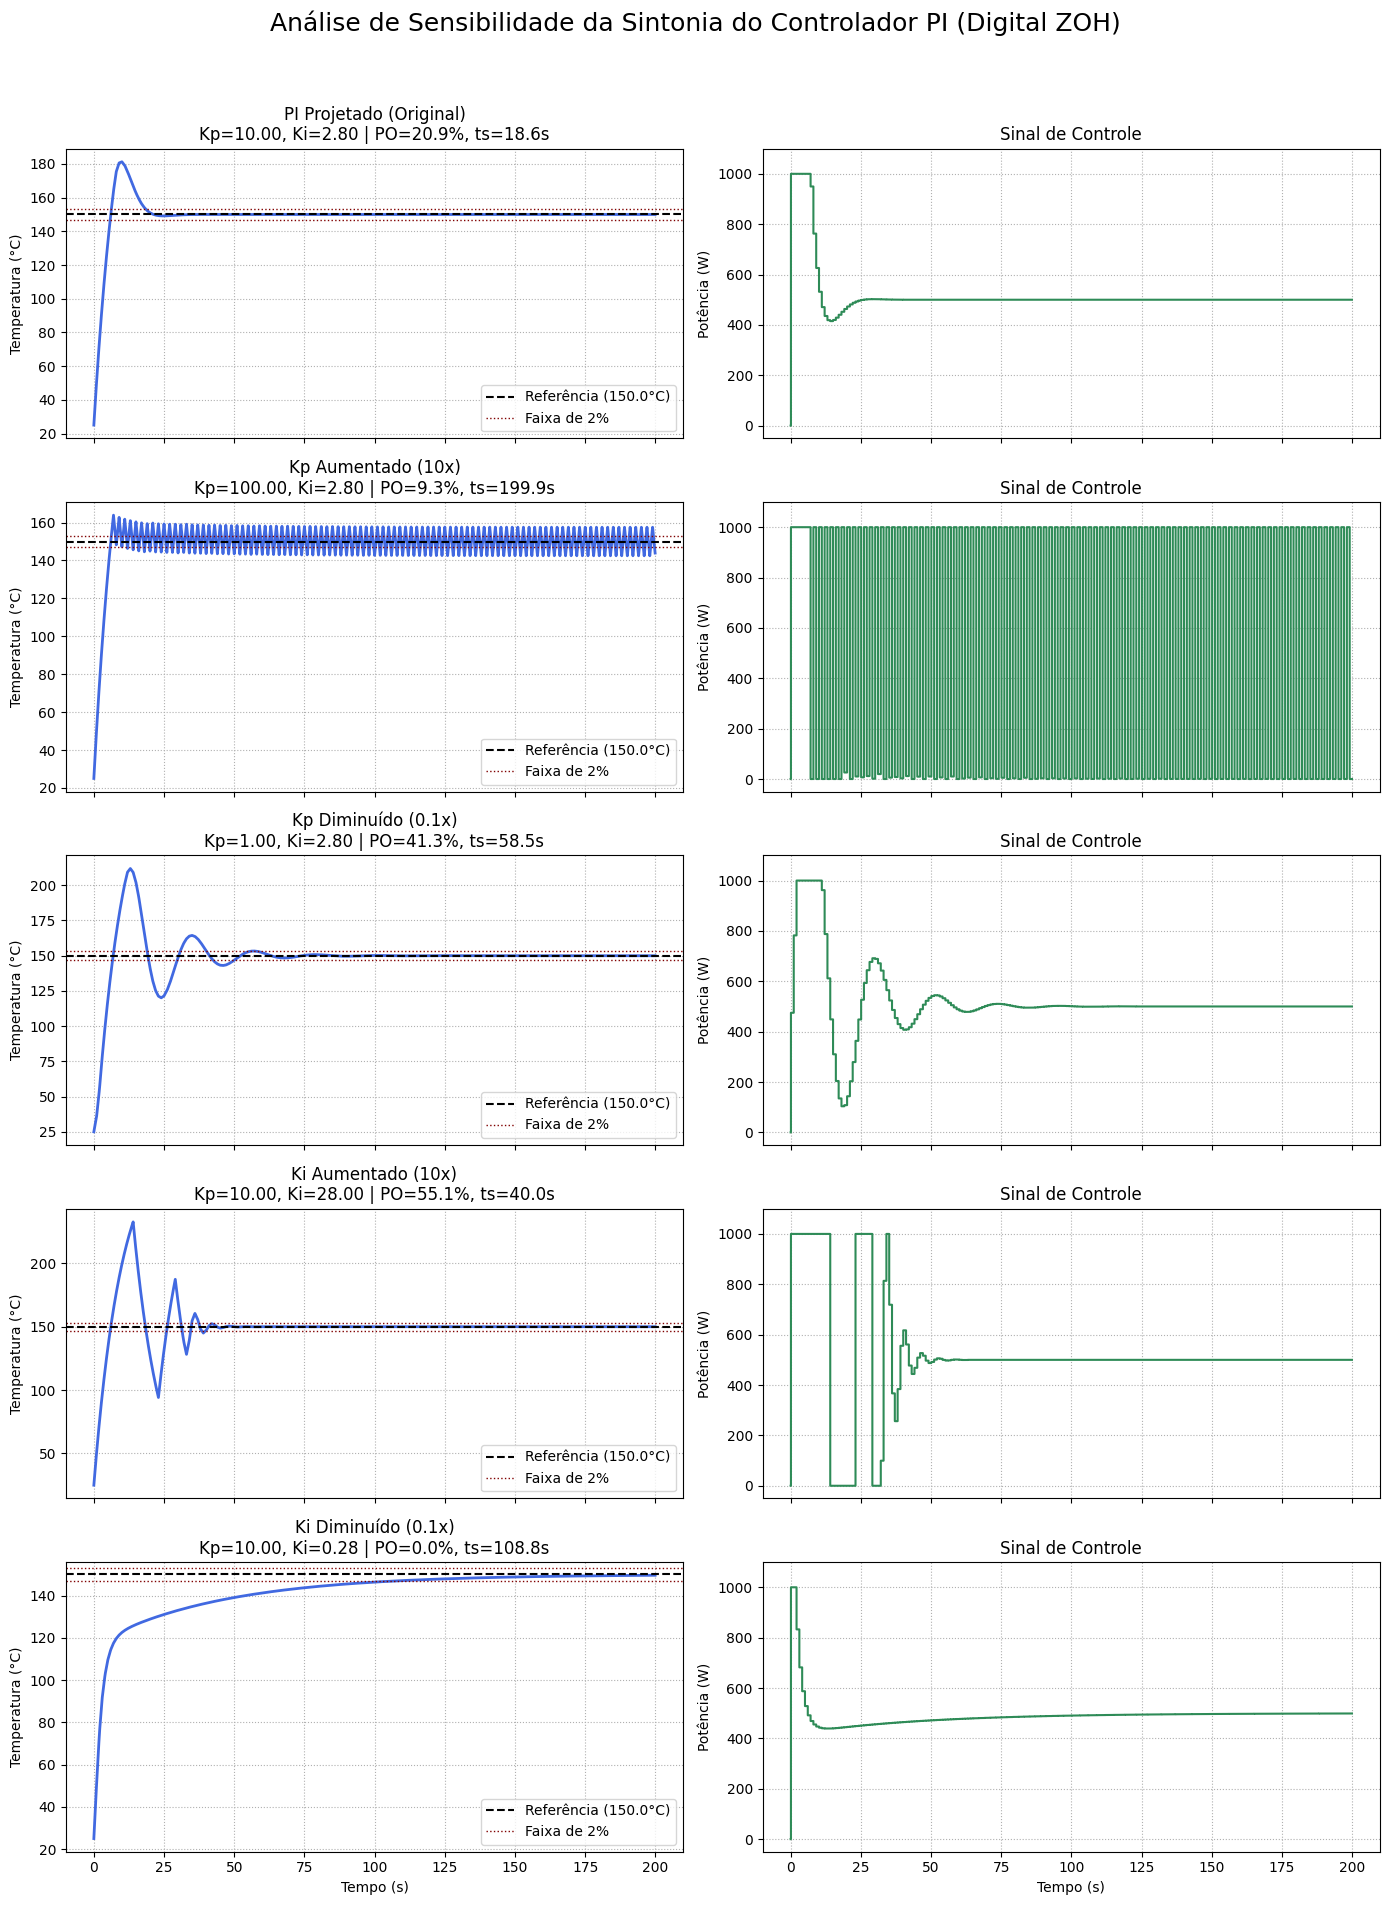

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (CORRIGIDAS E COMPLETAS)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    para atender a especificações de desempenho de 2ª ordem (PO, ts).
    """
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1
    wn = 4 / (zeta * ts_desejado)
    ki = (wn**2 * tau_planta) / K_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta
    return kp, ki

def simular_malha_aberta(y0, u_const, t_sim, T_int, K, tau):
    """Simula a resposta da planta em malha aberta a uma entrada constante."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.full(len(t), u_const)
    y[0] = y0
    for k in range(1, len(t)):
        dydt = (K * u[k-1] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_ganho_unitario(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com ganho unitário (sem controlador PI)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_continuo(y0, r, t_sim, T_int, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com um controlador PI 'contínuo'."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    integral_erro = 0.0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        integral_erro += erro * T_int
        u_calculado = Kp * erro + Ki * integral_erro
        u[k] = np.clip(u_calculado, 0, u_max)
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH)."""
    T_int = tau / 100.0
    Ts = tau / 10.0
    passos_por_amostra = int(round(Ts / T_int))
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    integral_sum = 0.0
    u_held = 0.0
    for k in range(1, len(t)):
        if (k - 1) % passos_por_amostra == 0:
            erro_atual = r - y[k-1]
            integral_sum += Ki * Ts * erro_atual
            u_calculado = Kp * erro_atual + integral_sum
            u_held = np.clip(u_calculado, 0, u_max)
        u[k] = u_held
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt
    return t, y, u

def medir_metricas(t, y, r):
    """Calcula PO, ts2 e o erro de regime permanente."""
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100) if r > 0 else 0.0

    ts2 = np.nan
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    for i in range(len(y) - 1, -1, -1):
        if y[i] > limite_superior or y[i] < limite_inferior:
            if i + 1 < len(t): ts2 = t[i+1]
            else: ts2 = t[-1]
            break
        if i == 0: ts2 = t[0]

    valor_final = y[-1]
    erro_ss = r - valor_final
    return po, ts2, valor_final, erro_ss

# =============================================================================
# PARTE 2: BLOCO PRINCIPAL DE EXECUÇÃO
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta e Especificações ---
    K_planta = 0.3
    tau_planta = 10.0
    PO_desejado = 5.0
    ts_desejado = 20.0

    # --- 2. Projeto do Controlador PI ---
    Kp, Ki = projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado)
    print("--- Controlador PI Projetado ---")
    print(f"Ganhos Calculados: Kp = {Kp:.4f}, Ki = {Ki:.4f}")

    # --- 3. Parâmetros Gerais da Simulação ---
    T_sim = 200.0
    y0 = 25.0
    r = 150.0
    potencia_max = 1000.0

    # --- 4. GERAÇÃO DA FIGURA 1: COMPARATIVO DE ESTRATÉGIAS ---
    print("\nGerando Figura 1: Comparativo de Estratégias...")
    T_int_continuo = tau_planta / 100.0

    t_ma, y_ma, u_ma_plot = simular_malha_aberta(y0, (r-y0)/K_planta, T_sim, T_int_continuo, K_planta, tau_planta)
    t_mfgu, y_mfgu, u_mfgu = simular_malha_fechada_ganho_unitario(y0, r, T_sim, T_int_continuo, K_planta, tau_planta)
    t_pic, y_pic, u_pic = simular_pi_continuo(y0, r, T_sim, T_int_continuo, K_planta, tau_planta, Kp, Ki, potencia_max)
    t_zoh, y_zoh, u_zoh = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, Kp, Ki, potencia_max)

    po_mfgu, ts_mfgu, yf_mfgu, ess_mfgu = medir_metricas(t_mfgu, y_mfgu, r)
    po_pic, ts_pic, _, _ = medir_metricas(t_pic, y_pic, r)
    po_zoh, ts_zoh, _, _ = medir_metricas(t_zoh, y_zoh, r)

    fig1, axs1 = plt.subplots(2, 4, figsize=(24, 10), sharex=True)
    fig1.suptitle('Comparativo de Estratégias de Controle (K=0.3, tau=10)', fontsize=20)
    # ... (código de plotagem da Figura 1)
    # Malha Aberta
    axs1[0, 0].plot(t_ma, y_ma, label=f'Saída y(t)'); axs1[0, 0].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)'); axs1[0, 0].set_title('Malha Aberta'); axs1[0, 0].set_ylabel('Temperatura (°C)'); axs1[0, 0].grid(True); axs1[0, 0].legend()
    axs1[1, 0].plot(t_ma, u_ma_plot, 'g'); axs1[1, 0].set_title('Potência (Malha Aberta)'); axs1[1, 0].set_ylabel('Potência (W)'); axs1[1, 0].set_xlabel('Tempo (s)'); axs1[1, 0].grid(True); axs1[1, 0].set_ylim(0, potencia_max * 1.1)
    # Malha Fechada (Ganho Unitário)
    axs1[0, 1].plot(t_mfgu, y_mfgu, label=f'Saída y(t)\nErro SS={ess_mfgu:.1f}°C'); axs1[0, 1].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)'); axs1[0, 1].set_title('Malha Fechada (Ganho Unitário)'); axs1[0, 1].grid(True); axs1[0, 1].legend()
    axs1[1, 1].plot(t_mfgu, u_mfgu, 'g'); axs1[1, 1].set_title('Potência'); axs1[1, 1].set_xlabel('Tempo (s)'); axs1[1, 1].grid(True); axs1[1, 1].set_ylim(0, potencia_max * 1.1)
    # PI Contínuo
    axs1[0, 2].plot(t_pic, y_pic, label=f'Saída y(t)\nPO={po_pic:.1f}%\nts2={ts_pic:.1f}s'); axs1[0, 2].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)'); axs1[0, 2].set_title('Malha Fechada (PI Contínuo)'); axs1[0, 2].grid(True); axs1[0, 2].legend()
    axs1[1, 2].plot(t_pic, u_pic, 'b'); axs1[1, 2].set_title('Potência (PI Contínuo)'); axs1[1, 2].set_xlabel('Tempo (s)'); axs1[1, 2].grid(True); axs1[1, 2].set_ylim(-50, potencia_max * 1.1)
    # PI Digital (ZOH)
    axs1[0, 3].plot(t_zoh, y_zoh, label=f'Saída y(t)\nPO={po_zoh:.1f}%\nts2={ts_zoh:.1f}s'); axs1[0, 3].axhline(y=r, color='r', linestyle='--', label=f'Referência ({r:.1f}°C)'); axs1[0, 3].set_title('Malha Fechada (PI Digital ZOH)'); axs1[0, 3].grid(True); axs1[0, 3].legend()
    axs1[1, 3].plot(t_zoh, u_zoh, 'b', drawstyle='steps-post'); axs1[1, 3].set_title('Potência (PI Digital ZOH)'); axs1[1, 3].set_xlabel('Tempo (s)'); axs1[1, 3].grid(True); axs1[1, 3].set_ylim(-50, potencia_max * 1.1)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # --- 5. GERAÇÃO DA FIGURA 2: ANÁLISE DE SENSIBILIDADE ---
    print("\nGerando Figura 2: Análise de Sensibilidade...")

    casos_sintonia = {
        "PI Projetado (Original)": (Kp, Ki),
        "Kp Aumentado (10x)": (Kp * 10, Ki),
        "Kp Diminuído (0.1x)": (Kp * 0.1, Ki),
        "Ki Aumentado (10x)": (Kp, Ki * 10),
        "Ki Diminuído (0.1x)": (Kp, Ki * 0.1),
    }

    resultados_sensibilidade = {}
    for nome, (kp_caso, ki_caso) in casos_sintonia.items():
        t, y, u = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, kp_caso, ki_caso, potencia_max)
        po, ts, _, _ = medir_metricas(t, y, r)
        resultados_sensibilidade[nome] = {'t': t, 'y': y, 'u': u, 'po': po, 'ts': ts, 'kp': kp_caso, 'ki': ki_caso}

    num_casos = len(casos_sintonia)
    fig2, axs2 = plt.subplots(num_casos, 2, figsize=(14, 4 * num_casos), sharex=True)
    fig2.suptitle('Análise de Sensibilidade da Sintonia do Controlador PI (Digital ZOH)', fontsize=18)

    for i, (nome_caso, res) in enumerate(resultados_sensibilidade.items()):
        ax_resp = axs2[i, 0]
        ax_resp.plot(res['t'], res['y'], 'royalblue', linewidth=2)
        ax_resp.axhline(y=r, color='black', linestyle='--', label=f'Referência ({r}°C)')
        ax_resp.axhline(y=r * 1.02, color='maroon', linestyle=':', linewidth=1)
        ax_resp.axhline(y=r * 0.98, color='maroon', linestyle=':', linewidth=1, label='Faixa de 2%')
        titulo = f"{nome_caso}\nKp={res['kp']:.2f}, Ki={res['ki']:.2f} | PO={res['po']:.1f}%, ts={res['ts']:.1f}s"
        ax_resp.set_title(titulo); ax_resp.set_ylabel("Temperatura (°C)"); ax_resp.grid(True, linestyle=':'); ax_resp.legend(loc='lower right')

        ax_ctrl = axs2[i, 1]
        ax_ctrl.plot(res['t'], res['u'], 'seagreen', drawstyle='steps-post')
        ax_ctrl.set_title("Sinal de Controle"); ax_ctrl.set_ylabel("Potência (W)"); ax_ctrl.grid(True, linestyle=':'); ax_ctrl.set_ylim(-50, potencia_max * 1.1)

    axs2[-1, 0].set_xlabel("Tempo (s)")
    axs2[-1, 1].set_xlabel("Tempo (s)")
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])

    plt.show()

--- 1. PARÂMETROS DO PROJETO ---
Planta: K = 0.3, tau = 10.0 s
Especificações: PO <= 5.0%, ts(2%) <= 20.0 s

--- 2. PROJETO DO CONTROLADOR ---
Ganhos Calculados (método contínuo): Kp = 10.0000, Ki = 2.7997

--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---
Passo de Integração da Planta (T_int): 0.100 s (tau/100)
Período de Amostragem do Controlador (Ts): 1.00 s (tau/10)

--- 4. EXECUTANDO SIMULAÇÕES ---
Simulação SEM controlador... concluída.
Simulação COM controlador PI Digital... concluída.

--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---

Cenário 1: Malha Fechada SEM Controlador
  - Valor Final: 34.62 °C
  - Erro em Regime Permanente: 115.38 °C
  - Sobressinal (PO): 0.00 %
  - Tempo de Acomodação (ts): 99.90 s

Cenário 2: Malha Fechada COM Controlador PI Digital
  - Valor Final: 150.00 °C
  - Erro em Regime Permanente: -0.00 °C
  - Sobressinal (PO): 3.32 % (Especificado: <= 5.0%)
  - Tempo de Acomodação (ts): 15.50 s (Especificado: <= 20.0 s)

[AVALIAÇÃO]: As especificações de desempenho FO

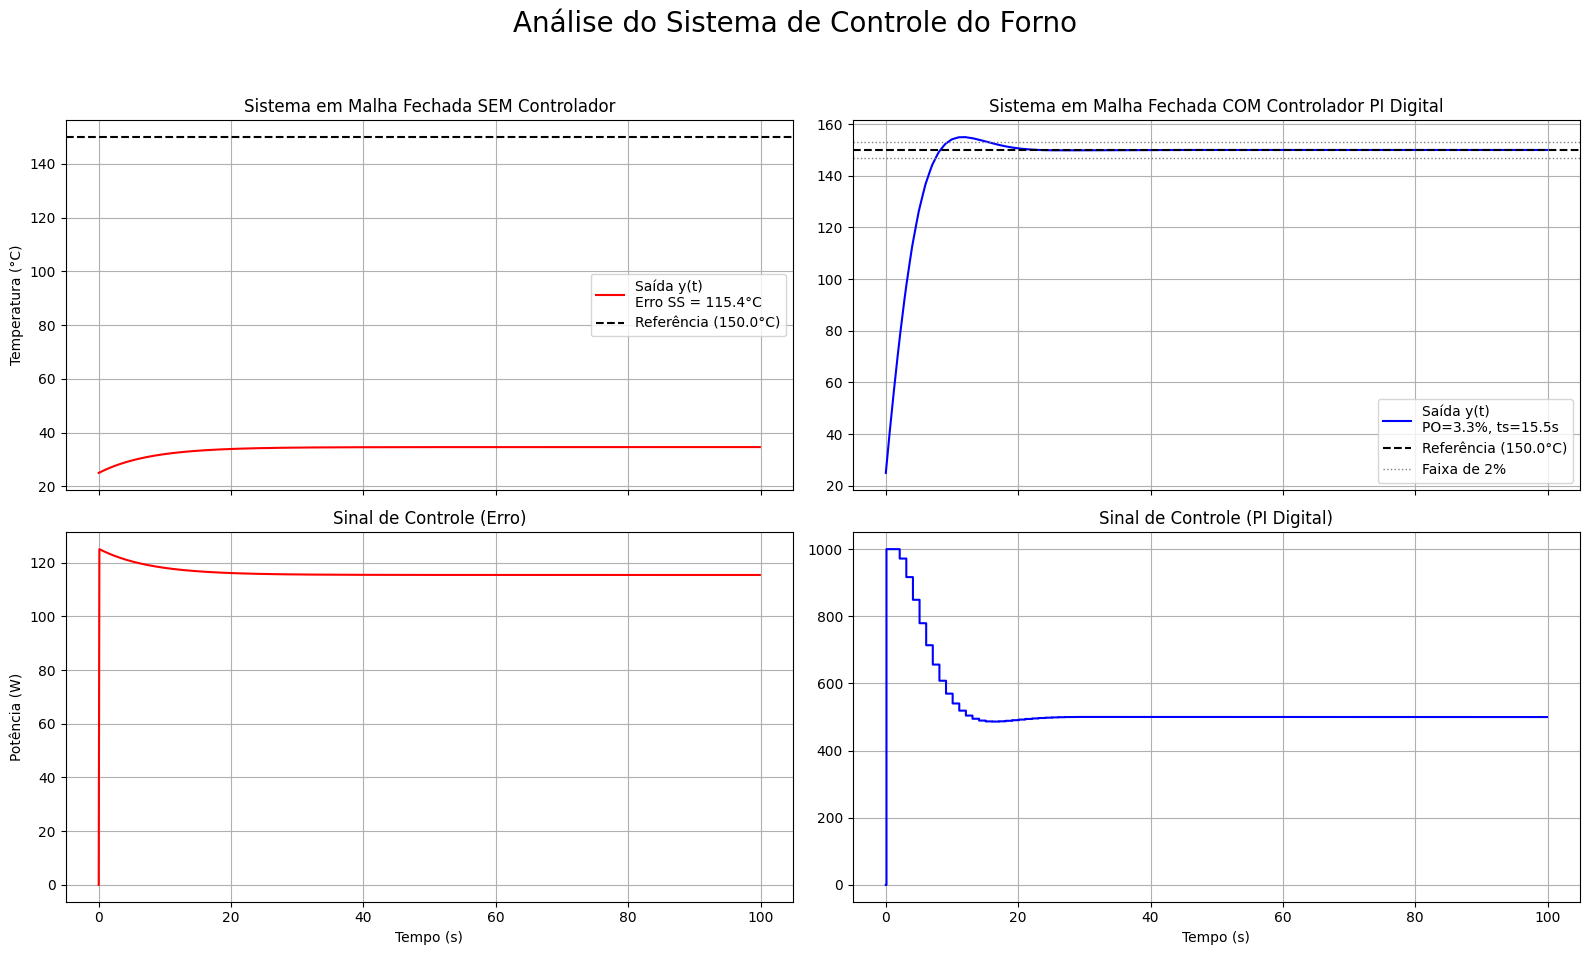

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (Mantidas, pois estão corretas)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    usando um método de alocação de polos baseado em especificações de 2ª ordem.
    """
    # Calcula os parâmetros do sistema de 2ª ordem desejado (zeta e wn)
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1 # Criticamente amortecido se PO = 0

    wn = 4 / (zeta * ts_desejado) # Tempo de acomodação (2% critério)

    # Calcula os ganhos Kp e Ki por alocação de polos
    # Equação característica: s*(tau*s+1) + K*(Kp*s + Ki) = 0
    # tau*s^2 + (1 + K*Kp)*s + K*Ki = 0
    # Comparando com s^2 + 2*zeta*wn*s + wn^2 = 0
    ki = (wn**2 * tau_planta) / K_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta
    return kp, ki

def simular_malha_aberta(y0, u_const, t_sim, T_int, K, tau):
    """Simula a resposta da planta em malha aberta a uma entrada constante."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.full(len(t), u_const)
    y[0] = y0
    for k in range(1, len(t)):
        dydt = (K * u[k-1] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_ganho_unitario(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com ganho unitário (sem controlador PI)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_sem_controlador(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com realimentação unitária (sem controlador)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro  # Ação de controle é o próprio erro
        # Integração da equação diferencial da planta (Método de Euler)
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0, u_min=0.0):
    """
    Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH),
    seguindo as regras de amostragem do trabalho.
    """
    # Parâmetros de tempo conforme as regras do trabalho
    T_int = tau / 100.0  # Passo de integração da planta
    Ts = tau / 10.0      # Período de amostragem do controlador

    passos_por_amostra = int(round(Ts / T_int)) # Quantos passos da planta por amostra do controlador

    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0

    # Variáveis de estado do controlador PI digital
    erro_anterior = 0.0
    u_anterior = 0.0
    u_held = 0.0 # Valor da ação de controle mantido pelo ZOH

    for k in range(1, len(t)):
        # O controlador só executa a cada 'passos_por_amostra'
        if (k - 1) % passos_por_amostra == 0:
            # 1. Medir o erro
            erro_atual = r - y[k-1]

            # 2. Calcular a nova ação de controle (Equação de Diferenças do PI)
            # u(k) = u(k-1) + Kp*(e(k) - e(k-1)) + Ki*Ts*e(k)
            # Esta é a forma incremental (velocity form), robusta contra wind-up.
            u_calculado = u_anterior + Kp * (erro_atual - erro_anterior) + Ki * Ts * erro_atual

            # 3. Saturação do atuador (anti-windup implícito)
            u_held = np.clip(u_calculado, u_min, u_max)

            # 4. Atualizar estados do controlador
            erro_anterior = erro_atual
            u_anterior = u_held # Atualiza com o valor saturado para evitar wind-up

        # O ZOH mantém o valor da ação de controle até a próxima amostragem
        u[k] = u_held

        # Simulação da planta (ocorre a cada passo de integração T_int)
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt

    return t, y, u

def medir_metricas(t, y, r):
    """Calcula PO, ts2 e o erro de regime permanente."""
    # Garante que r não é zero para evitar divisão por zero
    if abs(r) < 1e-9:
        return 0.0, t[-1], y[-1], -y[-1]

    # Sobressinal Percentual (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100)

    # Tempo de Acomodação (ts, critério de 2%)
    ts2 = np.nan
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Encontra o último ponto fora da faixa de 2%
    indices_fora = np.where((y > limite_superior) | (y < limite_inferior))[0]
    if len(indices_fora) > 0:
        ultimo_fora = indices_fora[-1]
        if ultimo_fora + 1 < len(t):
            ts2 = t[ultimo_fora + 1]
        else: # Se a resposta nunca se acomoda
            ts2 = t[-1]
    else: # Se a resposta já começa dentro da faixa
        ts2 = t[0]

    # Erro em Regime Permanente (Erro SS)
    valor_final = y[-1]
    erro_ss = r - valor_final
    return po, ts2, valor_final, erro_ss

# =============================================================================
# PARTE 2: BLOCO PRINCIPAL DE EXECUÇÃO DO PROJETO
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta e Especificações (Conforme o enunciado) ---
    print("--- 1. PARÂMETROS DO PROJETO ---")
    K_planta = 0.3      # Ganho Estático (°C/W)
    tau_planta = 10.0   # Constante de Tempo (s)
    PO_desejado = 5.0   # Sobressinal Percentual Máximo (%)
    ts_desejado = 20.0  # Tempo de Acomodação Máximo (s)

    print(f"Planta: K = {K_planta}, tau = {tau_planta} s")
    print(f"Especificações: PO <= {PO_desejado}%, ts(2%) <= {ts_desejado} s")

    # --- 2. Projeto do Controlador PI ---
    print("\n--- 2. PROJETO DO CONTROLADOR ---")
    Kp, Ki = projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado)
    print(f"Ganhos Calculados (método contínuo): Kp = {Kp:.4f}, Ki = {Ki:.4f}")

    # --- 3. Parâmetros da Simulação (Conforme regras do trabalho) ---
    print("\n--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---")
    T_sim = 100.0                # Tempo total de simulação (s)
    y0 = 25.0                    # Temperatura inicial (°C)
    r = 150.0                    # Temperatura de referência (Setpoint °C)
    potencia_max = 1000.0        # Potência máxima do atuador (W)
    T_int_calculado = tau_planta / 100.0
    Ts_calculado = tau_planta / 10.0
    print(f"Passo de Integração da Planta (T_int): {T_int_calculado:.3f} s (tau/100)")
    print(f"Período de Amostragem do Controlador (Ts): {Ts_calculado:.2f} s (tau/10)")

    # --- 4. Execução das Simulações ---
    print("\n--- 4. EXECUTANDO SIMULAÇÕES ---")

    # Cenário 1: Malha fechada SEM controlador
    t_sem_c, y_sem_c, u_sem_c = simular_malha_fechada_sem_controlador(y0, r, T_sim, T_int_calculado, K_planta, tau_planta)
    po_sem_c, ts_sem_c, yf_sem_c, ess_sem_c = medir_metricas(t_sem_c, y_sem_c, r)
    print("Simulação SEM controlador... concluída.")

    # Cenário 2: Malha fechada COM o controlador PI digital
    t_com_c, y_com_c, u_com_c = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, Kp, Ki, u_max=potencia_max)
    po_com_c, ts_com_c, yf_com_c, ess_com_c = medir_metricas(t_com_c, y_com_c, r)
    print("Simulação COM controlador PI Digital... concluída.")

    # --- 5. Análise e Apresentação dos Resultados ---
    print("\n--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---")
    print("\nCenário 1: Malha Fechada SEM Controlador")
    print(f"  - Valor Final: {yf_sem_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_sem_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_sem_c:.2f} %")
    print(f"  - Tempo de Acomodação (ts): {ts_sem_c:.2f} s")

    print("\nCenário 2: Malha Fechada COM Controlador PI Digital")
    print(f"  - Valor Final: {yf_com_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_com_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_com_c:.2f} % (Especificado: <= {PO_desejado}%)")
    print(f"  - Tempo de Acomodação (ts): {ts_com_c:.2f} s (Especificado: <= {ts_desejado} s)")

    if po_com_c <= PO_desejado and ts_com_c <= ts_desejado:
        print("\n[AVALIAÇÃO]: As especificações de desempenho FORAM ATENDIDAS.")
    else:
        print("\n[AVALIAÇÃO]: As especificações de desempenho NÃO FORAM ATENDIDAS. Pode ser necessário um ajuste fino.")

    # --- 6. Geração dos Gráficos para o Relatório ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    fig.suptitle('Análise do Sistema de Controle do Forno', fontsize=20)

    # Gráfico 1: Resposta SEM Controlador
    ax_y1 = axs[0, 0]
    ax_y1.plot(t_sem_c, y_sem_c, 'r', label=f'Saída y(t)\nErro SS = {ess_sem_c:.1f}°C')
    ax_y1.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y1.set_title('Sistema em Malha Fechada SEM Controlador')
    ax_y1.set_ylabel('Temperatura (°C)')
    ax_y1.grid(True); ax_y1.legend()

    ax_u1 = axs[1, 0]
    ax_u1.plot(t_sem_c, u_sem_c, 'r')
    ax_u1.set_title('Sinal de Controle (Erro)')
    ax_u1.set_ylabel('Potência (W)')
    ax_u1.set_xlabel('Tempo (s)')
    ax_u1.grid(True)

    # Gráfico 2: Resposta COM Controlador
    ax_y2 = axs[0, 1]
    ax_y2.plot(t_com_c, y_com_c, 'b', label=f'Saída y(t)\nPO={po_com_c:.1f}%, ts={ts_com_c:.1f}s')
    ax_y2.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y2.axhline(y=r*1.02, color='gray', linestyle=':', lw=1, label='Faixa de 2%')
    ax_y2.axhline(y=r*0.98, color='gray', linestyle=':', lw=1)
    ax_y2.set_title('Sistema em Malha Fechada COM Controlador PI Digital')
    ax_y2.grid(True); ax_y2.legend()

    ax_u2 = axs[1, 1]
    # 'steps-post' visualiza perfeitamente o comportamento do ZOH
    ax_u2.plot(t_com_c, u_com_c, 'b', drawstyle='steps-post')
    ax_u2.set_title('Sinal de Controle (PI Digital)')
    ax_u2.set_xlabel('Tempo (s)')
    ax_u2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- 1. PARÂMETROS DO PROJETO ---
Planta: K = 0.3, tau = 10.0 s
Especificações: PO <= 5.0%, ts(2%) <= 20.0 s

--- 2. PROJETO DO CONTROLADOR ---
Ganhos Calculados (método contínuo): Kp = 10.0000, Ki = 2.7997

--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---
Passo de Integração da Planta (T_int): 0.100 s (tau/100)
Período de Amostragem do Controlador (Ts): 1.00 s (tau/10)

--- 4. EXECUTANDO SIMULAÇÕES ---
Simulação SEM controlador... concluída.
Simulação COM controlador PI Digital... concluída.

--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---

Cenário 1: Malha Fechada SEM Controlador
  - Valor Final: 34.62 °C
  - Erro em Regime Permanente: 115.38 °C
  - Sobressinal (PO): 0.00 %
  - Tempo de Acomodação (ts): 99.90 s

Cenário 2: Malha Fechada COM Controlador PI Digital
  - Valor Final: 150.00 °C
  - Erro em Regime Permanente: -0.00 °C
  - Sobressinal (PO): 3.32 % (Especificado: <= 5.0%)
  - Tempo de Acomodação (ts): 15.50 s (Especificado: <= 20.0 s)

[AVALIAÇÃO]: As especificações de desempenho FO

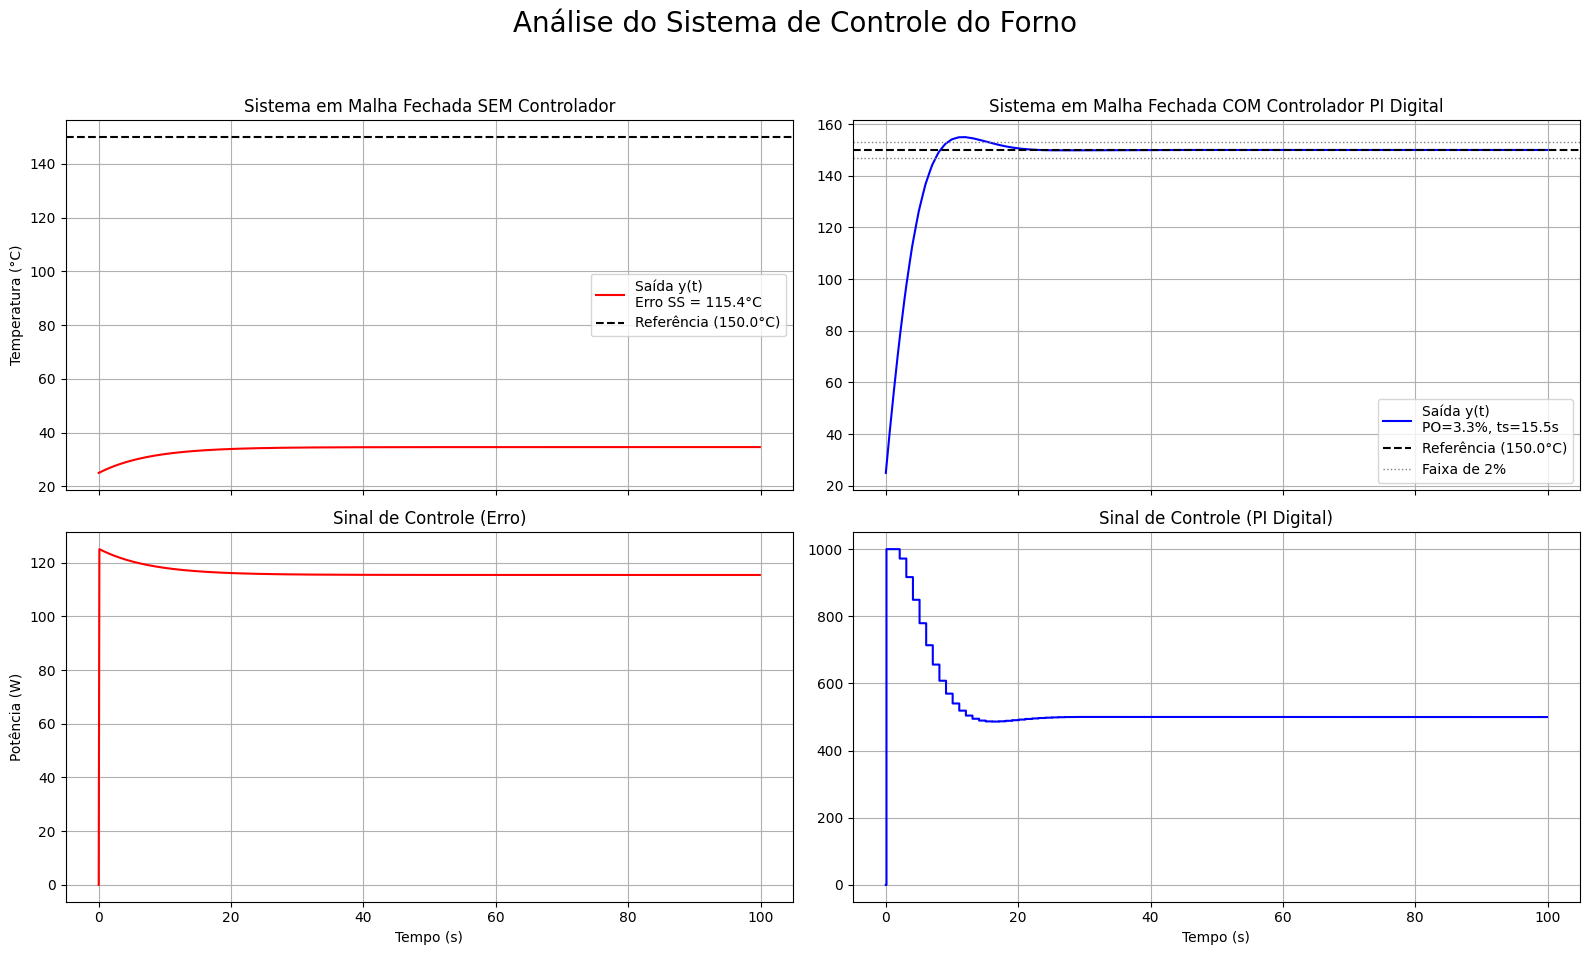

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (Mantidas, pois estão corretas)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    usando um método de alocação de polos baseado em especificações de 2ª ordem.
    """
    # Calcula os parâmetros do sistema de 2ª ordem desejado (zeta e wn)
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1 # Criticamente amortecido se PO = 0

    wn = 4 / (zeta * ts_desejado) # Tempo de acomodação (2% critério)

    # Calcula os ganhos Kp e Ki por alocação de polos
    # Equação característica: s*(tau*s+1) + K*(Kp*s + Ki) = 0
    # tau*s^2 + (1 + K*Kp)*s + K*Ki = 0
    # Comparando com s^2 + 2*zeta*wn*s + wn^2 = 0
    ki = (wn**2 * tau_planta) / K_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta
    return kp, ki

def simular_malha_aberta(y0, u_const, t_sim, T_int, K, tau):
    """Simula a resposta da planta em malha aberta a uma entrada constante."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.full(len(t), u_const)
    y[0] = y0
    for k in range(1, len(t)):
        dydt = (K * u[k-1] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_ganho_unitario(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com ganho unitário (sem controlador PI)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_continuo(y0, r, t_sim, T_int, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com um controlador PI 'contínuo'."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    integral_erro = 0.0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        integral_erro += erro * T_int
        u_calculado = Kp * erro + Ki * integral_erro
        u[k] = np.clip(u_calculado, 0, u_max)
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0, u_min=0.0):
    """
    Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH),
    seguindo as regras de amostragem do trabalho.
    """
    # Parâmetros de tempo conforme as regras do trabalho
    T_int = tau / 100.0  # Passo de integração da planta
    Ts = tau / 10.0      # Período de amostragem do controlador

    passos_por_amostra = int(round(Ts / T_int)) # Quantos passos da planta por amostra do controlador

    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0

    # Variáveis de estado do controlador PI digital
    erro_anterior = 0.0
    u_anterior = 0.0
    u_held = 0.0 # Valor da ação de controle mantido pelo ZOH

    for k in range(1, len(t)):
        # O controlador só executa a cada 'passos_por_amostra'
        if (k - 1) % passos_por_amostra == 0:
            # 1. Medir o erro
            erro_atual = r - y[k-1]

            # 2. Calcular a nova ação de controle (Equação de Diferenças do PI)
            # u(k) = u(k-1) + Kp*(e(k) - e(k-1)) + Ki*Ts*e(k)
            # Esta é a forma incremental (velocity form), robusta contra wind-up.
            u_calculado = u_anterior + Kp * (erro_atual - erro_anterior) + Ki * Ts * erro_atual

            # 3. Saturação do atuador (anti-windup implícito)
            u_held = np.clip(u_calculado, u_min, u_max)

            # 4. Atualizar estados do controlador
            erro_anterior = erro_atual
            u_anterior = u_held # Atualiza com o valor saturado para evitar wind-up

        # O ZOH mantém o valor da ação de controle até a próxima amostragem
        u[k] = u_held

        # Simulação da planta (ocorre a cada passo de integração T_int)
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt

    return t, y, u

def medir_metricas(t, y, r):
    """Calcula PO, ts2 e o erro de regime permanente."""
    # Garante que r não é zero para evitar divisão por zero
    if abs(r) < 1e-9:
        return 0.0, t[-1], y[-1], -y[-1]

    # Sobressinal Percentual (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100)

    # Tempo de Acomodação (ts, critério de 2%)
    ts2 = np.nan
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Encontra o último ponto fora da faixa de 2%
    indices_fora = np.where((y > limite_superior) | (y < limite_inferior))[0]
    if len(indices_fora) > 0:
        ultimo_fora = indices_fora[-1]
        if ultimo_fora + 1 < len(t):
            ts2 = t[ultimo_fora + 1]
        else: # Se a resposta nunca se acomoda
            ts2 = t[-1]
    else: # Se a resposta já começa dentro da faixa
        ts2 = t[0]

    # Erro em Regime Permanente (Erro SS)
    valor_final = y[-1]
    erro_ss = r - valor_final
    return po, ts2, valor_final, erro_ss

# =============================================================================
# PARTE 2: BLOCO PRINCIPAL DE EXECUÇÃO DO PROJETO
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta e Especificações (Conforme o enunciado) ---
    print("--- 1. PARÂMETROS DO PROJETO ---")
    K_planta = 0.3      # Ganho Estático (°C/W)
    tau_planta = 10.0   # Constante de Tempo (s)
    PO_desejado = 5.0   # Sobressinal Percentual Máximo (%)
    ts_desejado = 20.0  # Tempo de Acomodação Máximo (s)

    print(f"Planta: K = {K_planta}, tau = {tau_planta} s")
    print(f"Especificações: PO <= {PO_desejado}%, ts(2%) <= {ts_desejado} s")

    # --- 2. Projeto do Controlador PI ---
    print("\n--- 2. PROJETO DO CONTROLADOR ---")
    Kp, Ki = projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado)
    print(f"Ganhos Calculados (método contínuo): Kp = {Kp:.4f}, Ki = {Ki:.4f}")

    # --- 3. Parâmetros da Simulação (Conforme regras do trabalho) ---
    print("\n--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---")
    T_sim = 100.0                # Tempo total de simulação (s)
    y0 = 25.0                    # Temperatura inicial (°C)
    r = 150.0                    # Temperatura de referência (Setpoint °C)
    potencia_max = 1000.0        # Potência máxima do atuador (W)
    T_int_calculado = tau_planta / 100.0
    Ts_calculado = tau_planta / 10.0
    print(f"Passo de Integração da Planta (T_int): {T_int_calculado:.3f} s (tau/100)")
    print(f"Período de Amostragem do Controlador (Ts): {Ts_calculado:.2f} s (tau/10)")

    # --- 4. Execução das Simulações ---
    print("\n--- 4. EXECUTANDO SIMULAÇÕES ---")

    # Cenário 1: Malha fechada SEM controlador
    t_sem_c, y_sem_c, u_sem_c = simular_malha_fechada_sem_controlador(y0, r, T_sim, T_int_calculado, K_planta, tau_planta)
    po_sem_c, ts_sem_c, yf_sem_c, ess_sem_c = medir_metricas(t_sem_c, y_sem_c, r)
    print("Simulação SEM controlador... concluída.")

    # Cenário 2: Malha fechada COM o controlador PI digital
    t_com_c, y_com_c, u_com_c = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, Kp, Ki, u_max=potencia_max)
    po_com_c, ts_com_c, yf_com_c, ess_com_c = medir_metricas(t_com_c, y_com_c, r)
    print("Simulação COM controlador PI Digital... concluída.")

    # --- 5. Análise e Apresentação dos Resultados ---
    print("\n--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---")
    print("\nCenário 1: Malha Fechada SEM Controlador")
    print(f"  - Valor Final: {yf_sem_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_sem_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_sem_c:.2f} %")
    print(f"  - Tempo de Acomodação (ts): {ts_sem_c:.2f} s")

    print("\nCenário 2: Malha Fechada COM Controlador PI Digital")
    print(f"  - Valor Final: {yf_com_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_com_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_com_c:.2f} % (Especificado: <= {PO_desejado}%)")
    print(f"  - Tempo de Acomodação (ts): {ts_com_c:.2f} s (Especificado: <= {ts_desejado} s)")

    if po_com_c <= PO_desejado and ts_com_c <= ts_desejado:
        print("\n[AVALIAÇÃO]: As especificações de desempenho FORAM ATENDIDAS.")
    else:
        print("\n[AVALIAÇÃO]: As especificações de desempenho NÃO FORAM ATENDIDAS. Pode ser necessário um ajuste fino.")

    # --- 6. Geração dos Gráficos para o Relatório ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    fig.suptitle('Análise do Sistema de Controle do Forno', fontsize=20)

    # Gráfico 1: Resposta SEM Controlador
    ax_y1 = axs[0, 0]
    ax_y1.plot(t_sem_c, y_sem_c, 'r', label=f'Saída y(t)\nErro SS = {ess_sem_c:.1f}°C')
    ax_y1.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y1.set_title('Sistema em Malha Fechada SEM Controlador')
    ax_y1.set_ylabel('Temperatura (°C)')
    ax_y1.grid(True); ax_y1.legend()

    ax_u1 = axs[1, 0]
    ax_u1.plot(t_sem_c, u_sem_c, 'r')
    ax_u1.set_title('Sinal de Controle (Erro)')
    ax_u1.set_ylabel('Potência (W)')
    ax_u1.set_xlabel('Tempo (s)')
    ax_u1.grid(True)

    # Gráfico 2: Resposta COM Controlador
    ax_y2 = axs[0, 1]
    ax_y2.plot(t_com_c, y_com_c, 'b', label=f'Saída y(t)\nPO={po_com_c:.1f}%, ts={ts_com_c:.1f}s')
    ax_y2.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y2.axhline(y=r*1.02, color='gray', linestyle=':', lw=1, label='Faixa de 2%')
    ax_y2.axhline(y=r*0.98, color='gray', linestyle=':', lw=1)
    ax_y2.set_title('Sistema em Malha Fechada COM Controlador PI Digital')
    ax_y2.grid(True); ax_y2.legend()

    ax_u2 = axs[1, 1]
    # 'steps-post' visualiza perfeitamente o comportamento do ZOH
    ax_u2.plot(t_com_c, u_com_c, 'b', drawstyle='steps-post')
    ax_u2.set_title('Sinal de Controle (PI Digital)')
    ax_u2.set_xlabel('Tempo (s)')
    ax_u2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- 1. PARÂMETROS DO PROJETO ---
Planta: K = 0.3, tau = 10.0 s
Especificações: PO <= 5.0%, ts(2%) <= 20.0 s

--- 2. PROJETO DO CONTROLADOR ---
Ganhos Calculados (método contínuo): Kp = 10.0000, Ki = 2.7997

--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---
Passo de Integração da Planta (T_int): 0.100 s (tau/100)
Período de Amostragem do Controlador (Ts): 1.00 s (tau/10)

--- 4. EXECUTANDO SIMULAÇÕES ---
Simulação SEM controlador... concluída.
Simulação COM controlador PI Digital... concluída.

--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---

Cenário 1: Malha Fechada SEM Controlador
  - Valor Final: 34.62 °C
  - Erro em Regime Permanente: 115.38 °C
  - Sobressinal (PO): 0.00 %
  - Tempo de Acomodação (ts): 99.90 s

Cenário 2: Malha Fechada COM Controlador PI Digital
  - Valor Final: 150.00 °C
  - Erro em Regime Permanente: -0.00 °C
  - Sobressinal (PO): 3.32 % (Especificado: <= 5.0%)
  - Tempo de Acomodação (ts): 15.50 s (Especificado: <= 20.0 s)

[AVALIAÇÃO]: As especificações de desempenho FO

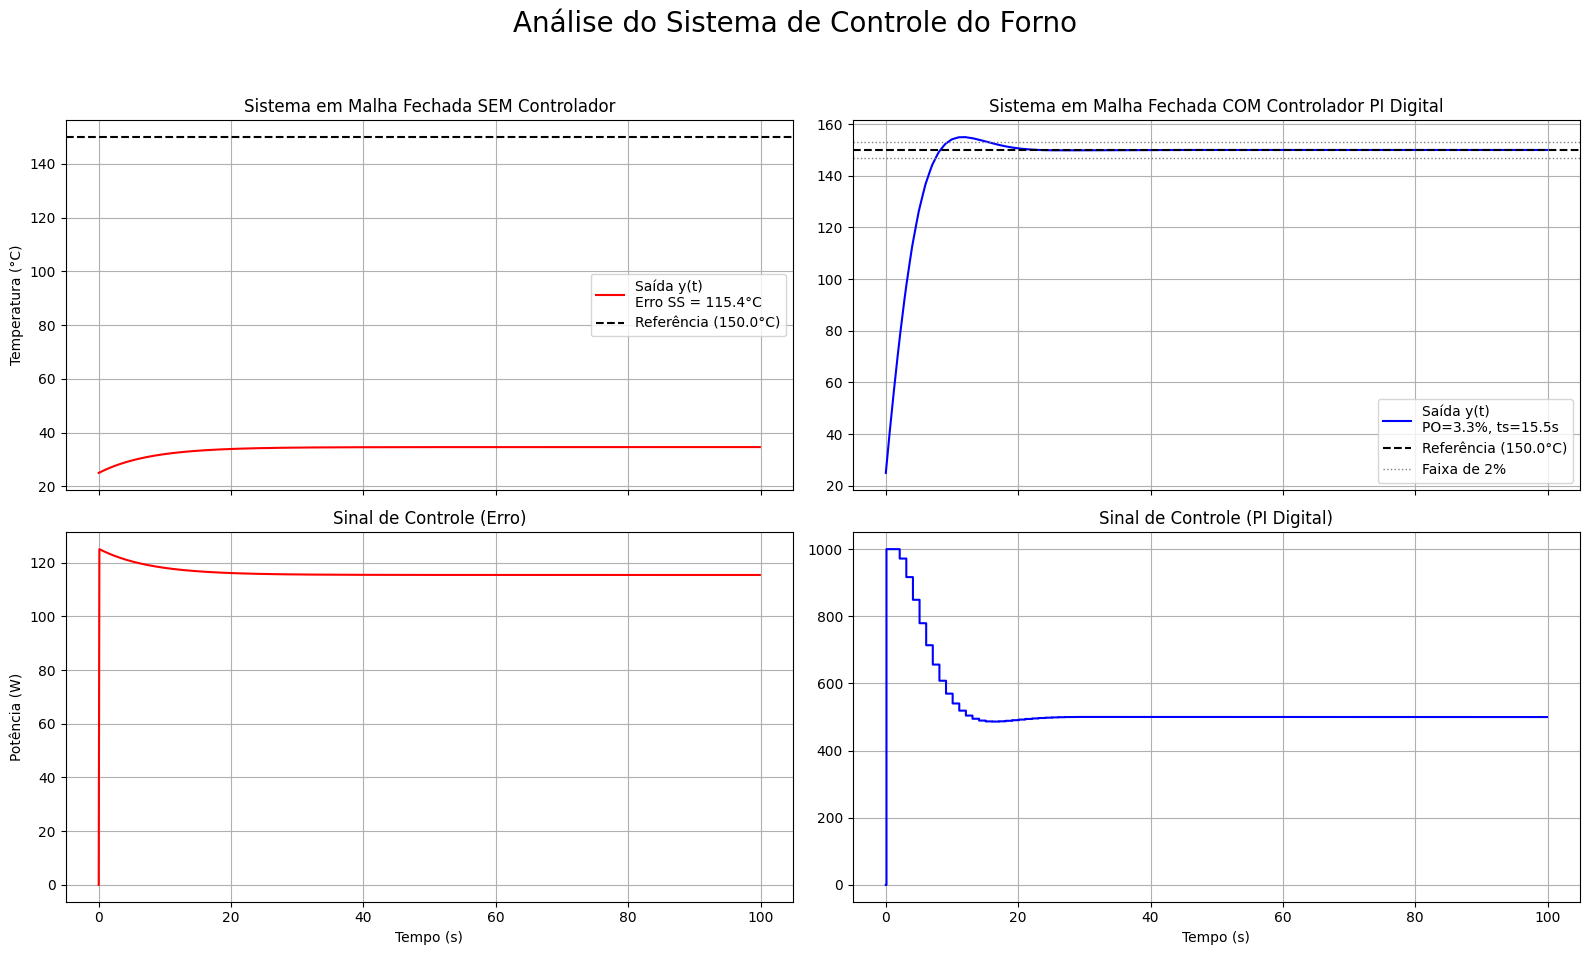

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (Mantidas, pois estão corretas)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    usando um método de alocação de polos baseado em especificações de 2ª ordem.
    """
    # Calcula os parâmetros do sistema de 2ª ordem desejado (zeta e wn)
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1 # Criticamente amortecido se PO = 0

    wn = 4 / (zeta * ts_desejado) # Tempo de acomodação (2% critério)

    # Calcula os ganhos Kp e Ki por alocação de polos
    # Equação característica: s*(tau*s+1) + K*(Kp*s + Ki) = 0
    # tau*s^2 + (1 + K*Kp)*s + K*Ki = 0
    # Comparando com s^2 + 2*zeta*wn*s + wn^2 = 0
    ki = (wn**2 * tau_planta) / K_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta
    return kp, ki

def simular_malha_aberta(y0, u_const, t_sim, T_int, K, tau):
    """Simula a resposta da planta em malha aberta a uma entrada constante."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.full(len(t), u_const)
    y[0] = y0
    for k in range(1, len(t)):
        dydt = (K * u[k-1] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_ganho_unitario(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com ganho unitário (sem controlador PI)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_sem_controlador(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com realimentação unitária (sem controlador)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro  # Ação de controle é o próprio erro
        # Integração da equação diferencial da planta (Método de Euler)
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0, u_min=0.0):
    """
    Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH),
    seguindo as regras de amostragem do trabalho.
    """
    # Parâmetros de tempo conforme as regras do trabalho
    T_int = tau / 100.0  # Passo de integração da planta
    Ts = tau / 10.0      # Período de amostragem do controlador

    passos_por_amostra = int(round(Ts / T_int)) # Quantos passos da planta por amostra do controlador

    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0

    # Variáveis de estado do controlador PI digital
    erro_anterior = 0.0
    u_anterior = 0.0
    u_held = 0.0 # Valor da ação de controle mantido pelo ZOH

    for k in range(1, len(t)):
        # O controlador só executa a cada 'passos_por_amostra'
        if (k - 1) % passos_por_amostra == 0:
            # 1. Medir o erro
            erro_atual = r - y[k-1]

            # 2. Calcular a nova ação de controle (Equação de Diferenças do PI)
            # u(k) = u(k-1) + Kp*(e(k) - e(k-1)) + Ki*Ts*e(k)
            # Esta é a forma incremental (velocity form), robusta contra wind-up.
            u_calculado = u_anterior + Kp * (erro_atual - erro_anterior) + Ki * Ts * erro_atual

            # 3. Saturação do atuador (anti-windup implícito)
            u_held = np.clip(u_calculado, u_min, u_max)

            # 4. Atualizar estados do controlador
            erro_anterior = erro_atual
            u_anterior = u_held # Atualiza com o valor saturado para evitar wind-up

        # O ZOH mantém o valor da ação de controle até a próxima amostragem
        u[k] = u_held

        # Simulação da planta (ocorre a cada passo de integração T_int)
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt

    return t, y, u

def medir_metricas(t, y, r):
    """Calcula PO, ts2 e o erro de regime permanente."""
    # Garante que r não é zero para evitar divisão por zero
    if abs(r) < 1e-9:
        return 0.0, t[-1], y[-1], -y[-1]

    # Sobressinal Percentual (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100)

    # Tempo de Acomodação (ts, critério de 2%)
    ts2 = np.nan
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Encontra o último ponto fora da faixa de 2%
    indices_fora = np.where((y > limite_superior) | (y < limite_inferior))[0]
    if len(indices_fora) > 0:
        ultimo_fora = indices_fora[-1]
        if ultimo_fora + 1 < len(t):
            ts2 = t[ultimo_fora + 1]
        else: # Se a resposta nunca se acomoda
            ts2 = t[-1]
    else: # Se a resposta já começa dentro da faixa
        ts2 = t[0]

    # Erro em Regime Permanente (Erro SS)
    valor_final = y[-1]
    erro_ss = r - valor_final
    return po, ts2, valor_final, erro_ss
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (Mantidas, pois estão corretas)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    usando um método de alocação de polos baseado em especificações de 2ª ordem.
    """
    # Calcula os parâmetros do sistema de 2ª ordem desejado (zeta e wn)
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1 # Criticamente amortecido se PO = 0

    wn = 4 / (zeta * ts_desejado) # Tempo de acomodação (2% critério)

    # Calcula os ganhos Kp e Ki por alocação de polos
    # Equação característica: s*(tau*s+1) + K*(Kp*s + Ki) = 0
    # tau*s^2 + (1 + K*Kp)*s + K*Ki = 0
    # Comparando com s^2 + 2*zeta*wn*s + wn^2 = 0
    ki = (wn**2 * tau_planta) / K_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta
    return kp, ki

def simular_malha_fechada_sem_controlador(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com realimentação unitária (sem controlador)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro  # Ação de controle é o próprio erro
        # Integração da equação diferencial da planta (Método de Euler)
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0, u_min=0.0):
    """
    Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH),
    seguindo as regras de amostragem do trabalho.
    """
    # Parâmetros de tempo conforme as regras do trabalho
    T_int = tau / 100.0  # Passo de integração da planta
    Ts = tau / 10.0      # Período de amostragem do controlador

    passos_por_amostra = int(round(Ts / T_int)) # Quantos passos da planta por amostra do controlador

    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0

    # Variáveis de estado do controlador PI digital
    erro_anterior = 0.0
    u_anterior = 0.0
    u_held = 0.0 # Valor da ação de controle mantido pelo ZOH

    for k in range(1, len(t)):
        # O controlador só executa a cada 'passos_por_amostra'
        if (k - 1) % passos_por_amostra == 0:
            # 1. Medir o erro
            erro_atual = r - y[k-1]

            # 2. Calcular a nova ação de controle (Equação de Diferenças do PI)
            # u(k) = u(k-1) + Kp*(e(k) - e(k-1)) + Ki*Ts*e(k)
            # Esta é a forma incremental (velocity form), robusta contra wind-up.
            u_calculado = u_anterior + Kp * (erro_atual - erro_anterior) + Ki * Ts * erro_atual

            # 3. Saturação do atuador (anti-windup implícito)
            u_held = np.clip(u_calculado, u_min, u_max)

            # 4. Atualizar estados do controlador
            erro_anterior = erro_atual
            u_anterior = u_held # Atualiza com o valor saturado para evitar wind-up

        # O ZOH mantém o valor da ação de controle até a próxima amostragem
        u[k] = u_held

        # Simulação da planta (ocorre a cada passo de integração T_int)
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt

    return t, y, u

def medir_metricas(t, y, r):
    """Calcula PO, ts2 e o erro de regime permanente."""
    # Garante que r não é zero para evitar divisão por zero
    if abs(r) < 1e-9:
        return 0.0, t[-1], y[-1], -y[-1]

    # Sobressinal Percentual (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100)

    # Tempo de Acomodação (ts, critério de 2%)
    ts2 = np.nan
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Encontra o último ponto fora da faixa de 2%
    indices_fora = np.where((y > limite_superior) | (y < limite_inferior))[0]
    if len(indices_fora) > 0:
        ultimo_fora = indices_fora[-1]
        if ultimo_fora + 1 < len(t):
            ts2 = t[ultimo_fora + 1]
        else: # Se a resposta nunca se acomoda
            ts2 = t[-1]
    else: # Se a resposta já começa dentro da faixa
        ts2 = t[0]

    # Erro em Regime Permanente (Erro SS)
    valor_final = y[-1]
    erro_ss = r - valor_final
    return po, ts2, valor_final, erro_ss

# =============================================================================
# PARTE 2: BLOCO PRINCIPAL DE EXECUÇÃO DO PROJETO
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta e Especificações (Conforme o enunciado) ---
    print("--- 1. PARÂMETROS DO PROJETO ---")
    K_planta = 0.3      # Ganho Estático (°C/W)
    tau_planta = 10.0   # Constante de Tempo (s)
    PO_desejado = 5.0   # Sobressinal Percentual Máximo (%)
    ts_desejado = 20.0  # Tempo de Acomodação Máximo (s)

    print(f"Planta: K = {K_planta}, tau = {tau_planta} s")
    print(f"Especificações: PO <= {PO_desejado}%, ts(2%) <= {ts_desejado} s")

    # --- 2. Projeto do Controlador PI ---
    print("\n--- 2. PROJETO DO CONTROLADOR ---")
    Kp, Ki = projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado)
    print(f"Ganhos Calculados (método contínuo): Kp = {Kp:.4f}, Ki = {Ki:.4f}")

    # --- 3. Parâmetros da Simulação (Conforme regras do trabalho) ---
    print("\n--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---")
    T_sim = 100.0                # Tempo total de simulação (s)
    y0 = 25.0                    # Temperatura inicial (°C)
    r = 150.0                    # Temperatura de referência (Setpoint °C)
    potencia_max = 1000.0        # Potência máxima do atuador (W)
    T_int_calculado = tau_planta / 100.0
    Ts_calculado = tau_planta / 10.0
    print(f"Passo de Integração da Planta (T_int): {T_int_calculado:.3f} s (tau/100)")
    print(f"Período de Amostragem do Controlador (Ts): {Ts_calculado:.2f} s (tau/10)")

    # --- 4. Execução das Simulações ---
    print("\n--- 4. EXECUTANDO SIMULAÇÕES ---")

    # Cenário 1: Malha fechada SEM controlador
    t_sem_c, y_sem_c, u_sem_c = simular_malha_fechada_sem_controlador(y0, r, T_sim, T_int_calculado, K_planta, tau_planta)
    po_sem_c, ts_sem_c, yf_sem_c, ess_sem_c = medir_metricas(t_sem_c, y_sem_c, r)
    print("Simulação SEM controlador... concluída.")

    # Cenário 2: Malha fechada COM o controlador PI digital
    t_com_c, y_com_c, u_com_c = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, Kp, Ki, u_max=potencia_max)
    po_com_c, ts_com_c, yf_com_c, ess_com_c = medir_metricas(t_com_c, y_com_c, r)
    print("Simulação COM controlador PI Digital... concluída.")

    # --- 5. Análise e Apresentação dos Resultados ---
    print("\n--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---")
    print("\nCenário 1: Malha Fechada SEM Controlador")
    print(f"  - Valor Final: {yf_sem_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_sem_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_sem_c:.2f} %")
    print(f"  - Tempo de Acomodação (ts): {ts_sem_c:.2f} s")

    print("\nCenário 2: Malha Fechada COM Controlador PI Digital")
    print(f"  - Valor Final: {yf_com_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_com_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_com_c:.2f} % (Especificado: <= {PO_desejado}%)")
    print(f"  - Tempo de Acomodação (ts): {ts_com_c:.2f} s (Especificado: <= {ts_desejado} s)")

    if po_com_c <= PO_desejado and ts_com_c <= ts_desejado:
        print("\n[AVALIAÇÃO]: As especificações de desempenho FORAM ATENDIDAS.")
    else:
        print("\n[AVALIAÇÃO]: As especificações de desempenho NÃO FORAM ATENDIDAS. Pode ser necessário um ajuste fino.")

    # --- 6. Geração dos Gráficos para o Relatório ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    fig.suptitle('Análise do Sistema de Controle do Forno', fontsize=20)

    # Gráfico 1: Resposta SEM Controlador
    ax_y1 = axs[0, 0]
    ax_y1.plot(t_sem_c, y_sem_c, 'r', label=f'Saída y(t)\nErro SS = {ess_sem_c:.1f}°C')
    ax_y1.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y1.set_title('Sistema em Malha Fechada SEM Controlador')
    ax_y1.set_ylabel('Temperatura (°C)')
    ax_y1.grid(True); ax_y1.legend()

    ax_u1 = axs[1, 0]
    ax_u1.plot(t_sem_c, u_sem_c, 'r')
    ax_u1.set_title('Sinal de Controle (Erro)')
    ax_u1.set_ylabel('Potência (W)')
    ax_u1.set_xlabel('Tempo (s)')
    ax_u1.grid(True)

    # Gráfico 2: Resposta COM Controlador
    ax_y2 = axs[0, 1]
    ax_y2.plot(t_com_c, y_com_c, 'b', label=f'Saída y(t)\nPO={po_com_c:.1f}%, ts={ts_com_c:.1f}s')
    ax_y2.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y2.axhline(y=r*1.02, color='gray', linestyle=':', lw=1, label='Faixa de 2%')
    ax_y2.axhline(y=r*0.98, color='gray', linestyle=':', lw=1)
    ax_y2.set_title('Sistema em Malha Fechada COM Controlador PI Digital')
    ax_y2.grid(True); ax_y2.legend()

    ax_u2 = axs[1, 1]
    # 'steps-post' visualiza perfeitamente o comportamento do ZOH
    ax_u2.plot(t_com_c, u_com_c, 'b', drawstyle='steps-post')
    ax_u2.set_title('Sinal de Controle (PI Digital)')
    ax_u2.set_xlabel('Tempo (s)')
    ax_u2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

--- 1. PARÂMETROS DO PROJETO ---
Planta: K = 0.3, tau = 10.0 s
Especificações: PO <= 5.0%, ts(2%) <= 20.0 s

--- 2. PROJETO DO CONTROLADOR ---
Ganhos Calculados (método contínuo): Kp = 10.0000, Ki = 2.7997

--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---
Passo de Integração da Planta (T_int): 0.100 s (tau/100)
Período de Amostragem do Controlador (Ts): 1.00 s (tau/10)

--- 4. EXECUTANDO SIMULAÇÕES ---
Simulação SEM controlador... concluída.
Simulação COM controlador PI Digital... concluída.

--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---

Cenário 1: Malha Fechada SEM Controlador
  - Valor Final: 34.62 °C
  - Erro em Regime Permanente: 115.38 °C
  - Sobressinal (PO): 0.00 %
  - Tempo de Acomodação (ts): 99.90 s

Cenário 2: Malha Fechada COM Controlador PI Digital
  - Valor Final: 150.00 °C
  - Erro em Regime Permanente: -0.00 °C
  - Sobressinal (PO): 3.32 % (Especificado: <= 5.0%)
  - Tempo de Acomodação (ts): 15.50 s (Especificado: <= 20.0 s)

[AVALIAÇÃO]: As especificações de desempenho FO

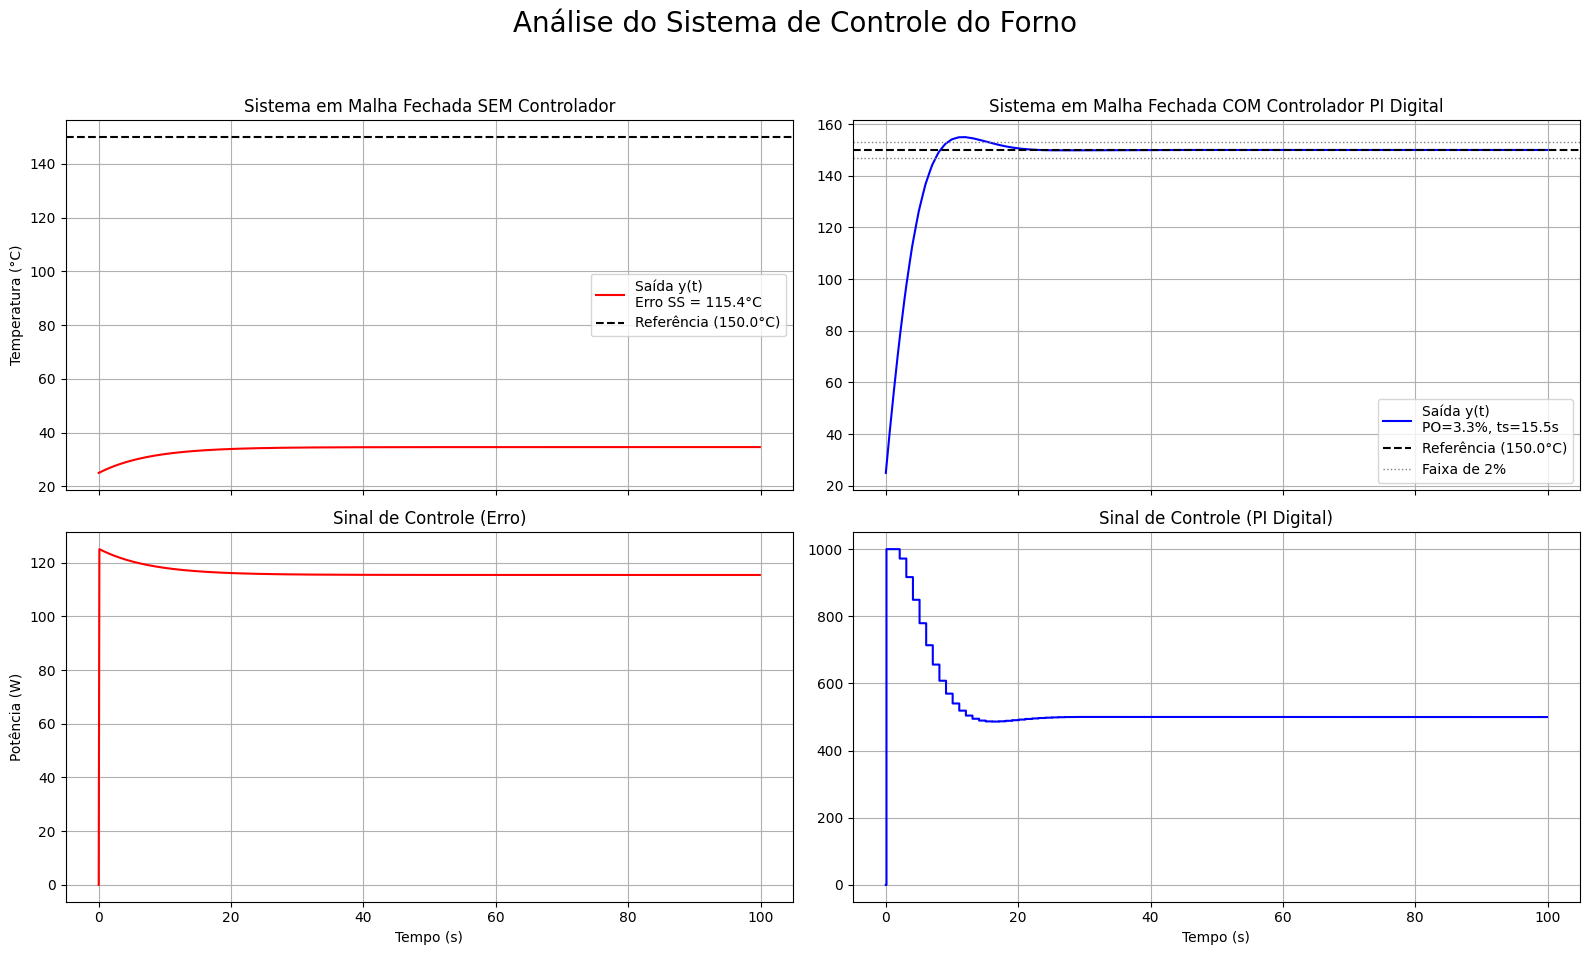

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# PARTE 1: FUNÇÕES DE PROJETO E SIMULAÇÃO (Mantidas, pois estão corretas)
# =============================================================================

def projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado):
    """
    Projeta um controlador PI para uma planta de 1ª ordem G=K/(tau*s+1)
    usando um método de alocação de polos baseado em especificações de 2ª ordem.
    """
    # Calcula os parâmetros do sistema de 2ª ordem desejado (zeta e wn)
    if PO_desejado > 0:
        zeta = -np.log(PO_desejado / 100) / np.sqrt(np.pi**2 + (np.log(PO_desejado / 100))**2)
    else:
        zeta = 1 # Criticamente amortecido se PO = 0

    wn = 4 / (zeta * ts_desejado) # Tempo de acomodação (2% critério)

    # Calcula os ganhos Kp e Ki por alocação de polos
    # Equação característica: s*(tau*s+1) + K*(Kp*s + Ki) = 0
    # tau*s^2 + (1 + K*Kp)*s + K*Ki = 0
    # Comparando com s^2 + 2*zeta*wn*s + wn^2 = 0
    ki = (wn**2 * tau_planta) / K_planta
    kp = (2 * zeta * wn * tau_planta - 1) / K_planta
    return kp, ki

def simular_malha_aberta(y0, u_const, t_sim, T_int, K, tau):
    """Simula a resposta da planta em malha aberta a uma entrada constante."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.full(len(t), u_const)
    y[0] = y0
    for k in range(1, len(t)):
        dydt = (K * u[k-1] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_malha_fechada_ganho_unitario(y0, r, t_sim, T_int, K, tau):
    """Simula a malha fechada com ganho unitário (sem controlador PI)."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        u[k] = erro
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_continuo(y0, r, t_sim, T_int, K, tau, Kp, Ki, u_max=1000.0):
    """Simula a malha fechada com um controlador PI 'contínuo'."""
    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0
    integral_erro = 0.0
    for k in range(1, len(t)):
        erro = r - y[k-1]
        integral_erro += erro * T_int
        u_calculado = Kp * erro + Ki * integral_erro
        u[k] = np.clip(u_calculado, 0, u_max)
        dydt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dydt
    return t, y, u

def simular_pi_digital_zoh(y0, r, t_sim, K, tau, Kp, Ki, u_max=1000.0, u_min=0.0):
    """
    Simula a malha fechada com controlador PI digital e Zero-Order Hold (ZOH),
    seguindo as regras de amostragem do trabalho.
    """
    # Parâmetros de tempo conforme as regras do trabalho
    T_int = tau / 100.0  # Passo de integração da planta
    Ts = tau / 10.0      # Período de amostragem do controlador

    passos_por_amostra = int(round(Ts / T_int)) # Quantos passos da planta por amostra do controlador

    t = np.arange(0, t_sim, T_int)
    y = np.zeros(len(t))
    u = np.zeros(len(t))
    y[0] = y0

    # Variáveis de estado do controlador PI digital
    erro_anterior = 0.0
    u_anterior = 0.0
    u_held = 0.0 # Valor da ação de controle mantido pelo ZOH

    for k in range(1, len(t)):
        # O controlador só executa a cada 'passos_por_amostra'
        if (k - 1) % passos_por_amostra == 0:
            # 1. Medir o erro
            erro_atual = r - y[k-1]

            # 2. Calcular a nova ação de controle (Equação de Diferenças do PI)
            # u(k) = u(k-1) + Kp*(e(k) - e(k-1)) + Ki*Ts*e(k)
            # Esta é a forma incremental (velocity form), robusta contra wind-up.
            u_calculado = u_anterior + Kp * (erro_atual - erro_anterior) + Ki * Ts * erro_atual

            # 3. Saturação do atuador (anti-windup implícito)
            u_held = np.clip(u_calculado, u_min, u_max)

            # 4. Atualizar estados do controlador
            erro_anterior = erro_atual
            u_anterior = u_held # Atualiza com o valor saturado para evitar wind-up

        # O ZOH mantém o valor da ação de controle até a próxima amostragem
        u[k] = u_held

        # Simulação da planta (ocorre a cada passo de integração T_int)
        dy_dt = (K * u[k] - y[k-1]) / tau
        y[k] = y[k-1] + T_int * dy_dt

    return t, y, u

def medir_metricas(t, y, r):
    """Calcula PO, ts2 e o erro de regime permanente."""
    # Garante que r não é zero para evitar divisão por zero
    if abs(r) < 1e-9:
        return 0.0, t[-1], y[-1], -y[-1]

    # Sobressinal Percentual (PO)
    pico = np.max(y)
    po = max(0, ((pico - r) / r) * 100)

    # Tempo de Acomodação (ts, critério de 2%)
    ts2 = np.nan
    limite_superior = r * 1.02
    limite_inferior = r * 0.98

    # Encontra o último ponto fora da faixa de 2%
    indices_fora = np.where((y > limite_superior) | (y < limite_inferior))[0]
    if len(indices_fora) > 0:
        ultimo_fora = indices_fora[-1]
        if ultimo_fora + 1 < len(t):
            ts2 = t[ultimo_fora + 1]
        else: # Se a resposta nunca se acomoda
            ts2 = t[-1]
    else: # Se a resposta já começa dentro da faixa
        ts2 = t[0]

    # Erro em Regime Permanente (Erro SS)
    valor_final = y[-1]
    erro_ss = r - valor_final
    return po, ts2, valor_final, erro_ss

# =============================================================================
# PARTE 2: BLOCO PRINCIPAL DE EXECUÇÃO DO PROJETO
# =============================================================================

if __name__ == "__main__":
    # --- 1. Definição da Planta e Especificações (Conforme o enunciado) ---
    print("--- 1. PARÂMETROS DO PROJETO ---")
    K_planta = 0.3      # Ganho Estático (°C/W)
    tau_planta = 10.0   # Constante de Tempo (s)
    PO_desejado = 5.0   # Sobressinal Percentual Máximo (%)
    ts_desejado = 20.0  # Tempo de Acomodação Máximo (s)

    print(f"Planta: K = {K_planta}, tau = {tau_planta} s")
    print(f"Especificações: PO <= {PO_desejado}%, ts(2%) <= {ts_desejado} s")

    # --- 2. Projeto do Controlador PI ---
    print("\n--- 2. PROJETO DO CONTROLADOR ---")
    Kp, Ki = projetar_controlador_pi(K_planta, tau_planta, PO_desejado, ts_desejado)
    print(f"Ganhos Calculados (método contínuo): Kp = {Kp:.4f}, Ki = {Ki:.4f}")

    # --- 3. Parâmetros da Simulação (Conforme regras do trabalho) ---
    print("\n--- 3. PARÂMETROS DA SIMULAÇÃO DIGITAL ---")
    T_sim = 100.0                # Tempo total de simulação (s)
    y0 = 25.0                    # Temperatura inicial (°C)
    r = 150.0                    # Temperatura de referência (Setpoint °C)
    potencia_max = 1000.0        # Potência máxima do atuador (W)
    T_int_calculado = tau_planta / 100.0
    Ts_calculado = tau_planta / 10.0
    print(f"Passo de Integração da Planta (T_int): {T_int_calculado:.3f} s (tau/100)")
    print(f"Período de Amostragem do Controlador (Ts): {Ts_calculado:.2f} s (tau/10)")

    # --- 4. Execução das Simulações ---
    print("\n--- 4. EXECUTANDO SIMULAÇÕES ---")

    # Cenário 1: Malha fechada SEM controlador
    t_sem_c, y_sem_c, u_sem_c = simular_malha_fechada_sem_controlador(y0, r, T_sim, T_int_calculado, K_planta, tau_planta)
    po_sem_c, ts_sem_c, yf_sem_c, ess_sem_c = medir_metricas(t_sem_c, y_sem_c, r)
    print("Simulação SEM controlador... concluída.")

    # Cenário 2: Malha fechada COM o controlador PI digital
    t_com_c, y_com_c, u_com_c = simular_pi_digital_zoh(y0, r, T_sim, K_planta, tau_planta, Kp, Ki, u_max=potencia_max)
    po_com_c, ts_com_c, yf_com_c, ess_com_c = medir_metricas(t_com_c, y_com_c, r)
    print("Simulação COM controlador PI Digital... concluída.")

    # --- 5. Análise e Apresentação dos Resultados ---
    print("\n--- 5. RESULTADOS E MÉTRICAS DE DESEMPENHO ---")
    print("\nCenário 1: Malha Fechada SEM Controlador")
    print(f"  - Valor Final: {yf_sem_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_sem_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_sem_c:.2f} %")
    print(f"  - Tempo de Acomodação (ts): {ts_sem_c:.2f} s")

    print("\nCenário 2: Malha Fechada COM Controlador PI Digital")
    print(f"  - Valor Final: {yf_com_c:.2f} °C")
    print(f"  - Erro em Regime Permanente: {ess_com_c:.2f} °C")
    print(f"  - Sobressinal (PO): {po_com_c:.2f} % (Especificado: <= {PO_desejado}%)")
    print(f"  - Tempo de Acomodação (ts): {ts_com_c:.2f} s (Especificado: <= {ts_desejado} s)")

    if po_com_c <= PO_desejado and ts_com_c <= ts_desejado:
        print("\n[AVALIAÇÃO]: As especificações de desempenho FORAM ATENDIDAS.")
    else:
        print("\n[AVALIAÇÃO]: As especificações de desempenho NÃO FORAM ATENDIDAS. Pode ser necessário um ajuste fino.")

    # --- 6. Geração dos Gráficos para o Relatório ---
    fig, axs = plt.subplots(2, 2, figsize=(16, 10), sharex=True)
    fig.suptitle('Análise do Sistema de Controle do Forno', fontsize=20)

    # Gráfico 1: Resposta SEM Controlador
    ax_y1 = axs[0, 0]
    ax_y1.plot(t_sem_c, y_sem_c, 'r', label=f'Saída y(t)\nErro SS = {ess_sem_c:.1f}°C')
    ax_y1.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y1.set_title('Sistema em Malha Fechada SEM Controlador')
    ax_y1.set_ylabel('Temperatura (°C)')
    ax_y1.grid(True); ax_y1.legend()

    ax_u1 = axs[1, 0]
    ax_u1.plot(t_sem_c, u_sem_c, 'r')
    ax_u1.set_title('Sinal de Controle (Erro)')
    ax_u1.set_ylabel('Potência (W)')
    ax_u1.set_xlabel('Tempo (s)')
    ax_u1.grid(True)

    # Gráfico 2: Resposta COM Controlador
    ax_y2 = axs[0, 1]
    ax_y2.plot(t_com_c, y_com_c, 'b', label=f'Saída y(t)\nPO={po_com_c:.1f}%, ts={ts_com_c:.1f}s')
    ax_y2.axhline(y=r, color='k', linestyle='--', label=f'Referência ({r}°C)')
    ax_y2.axhline(y=r*1.02, color='gray', linestyle=':', lw=1, label='Faixa de 2%')
    ax_y2.axhline(y=r*0.98, color='gray', linestyle=':', lw=1)
    ax_y2.set_title('Sistema em Malha Fechada COM Controlador PI Digital')
    ax_y2.grid(True); ax_y2.legend()

    ax_u2 = axs[1, 1]
    # 'steps-post' visualiza perfeitamente o comportamento do ZOH
    ax_u2.plot(t_com_c, u_com_c, 'b', drawstyle='steps-post')
    ax_u2.set_title('Sinal de Controle (PI Digital)')
    ax_u2.set_xlabel('Tempo (s)')
    ax_u2.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()